## Microgrid simulator
    - run in terminal: PATH_OF_THIS_FILE$ jupyter notebook
    - other folders in PATH_OF_THIS_FILE are referenced; (sibling folders untouched)
        
# Table of contents
2. [Model toolset](#eid8ieWi)   
3. [Data import/generation ](#AH4thie4)  
4. [Model building](#EiNie3ie)  

    4.1. [Model grid_20peers](#Aexe3Kai)  
    4.1.1. [Scenario 1: grid_20peers individual control](#Ooph2it9)  
    4.1.2. [Scenario 2: grid_20peers collective control](#shoh0Du4)    
    4.1.3. [Power-flow analysis](#ddd9nooM)    
    4.1.4. [Review results](#ood9nooM) 


5. [Appendix](#aeZae4ai)   
    5.1. [Notebook version ](#aeeae4ai)  
    5.2. [License  ](#aefae4ai)  
    

### Model Toolset <a name="eid8ieWi"></a>
    Helper functions to build the model

In [1]:
import math
import random
import time
import os
from collections import OrderedDict
from collections.abc import Iterable

import pickle#store/load simulation results
from gekko import GEKKO

import pandas as pd
from pandas import DataFrame as df
import numpy as np

from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import stats
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib import gridspec 
from matplotlib.colors import to_hex, to_rgb, LinearSegmentedColormap, Normalize
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from IPython.core.debugger import set_trace#for ipdb
from IPython.core.display import display, HTML, clear_output

In [2]:
display(HTML("<style>.container { width:98% !important; }</style>"))#this cell width

In [3]:
%matplotlib inline
np.seterr(all='raise')
plt.rcParams.update({'figure.figsize': (15, 2.5),
                     'font.size': 17, 
                     'legend.frameon': False, 
                     'axes.spines.top': False, 'axes.spines.right': False})

In [4]:
mcolor = {}#some resource colors, plot sugar only, https://matplotlib.org/examples/color/colormaps_reference.html
mcolor['ld'] = '#faa59e'
mcolor['pv'] = '#feca81'
mcolor['inv'] = '#d5bcdc'
mcolor['es'] = '#6BAED6'
mcolor['grid'] = '#bce5b3'
mcolor['col'] = '#636363'
mcolor['idv'] = '#969696'
mcolor['xfmr'] = '#808080'
for key, value in mcolor.items():
    mcolor[key] = np.array(to_rgb(mcolor[key]))
mcolor['loss'] = np.array([1, 0, 0])#red
mcolor['es_4'] = np.array([to_rgb(v) for v in ['#3182BD','#6BAED6','#9ECAE1','#C6DBEF']])

es_soc_map = LinearSegmentedColormap.from_list('es_soc_map', 
           [[1, 1, 1],
            [0.77647059, 0.85882353, 0.9372549 ],
            [0.61960784, 0.79215686, 0.88235294],
            [0.41960784, 0.68235294, 0.83921569],
            [0.19215686, 0.50980392, 0.74117647],
            [0.01176471, 0.25882353, 0.43921569],
            [0,0,0]], N=1000)
plt.register_cmap(cmap=es_soc_map)
plt.register_cmap(cmap=es_soc_map.reversed())
plt.register_cmap(cmap=LinearSegmentedColormap.from_list('es_soc_map_sym', 
           [[1,0,0],
            [1,1,1],
            [0,0,1]], N=1000))
plt.register_cmap(cmap=LinearSegmentedColormap.from_list('my_red', 
           [[1,0.74,0.74],
           [1,0.74,0.74],], N=1))
ubal_or = LinearSegmentedColormap.from_list('ubal_or', 
           [[1, 0.5, 0],
            [1,1,1],
            [1,1,1]], N=1000)
plt.register_cmap(cmap=ubal_or)
plt.register_cmap(cmap=ubal_or.reversed())
bal_or = LinearSegmentedColormap.from_list('bal_or', 
           [[1, 0.5, 0],
            [1,1,1]], N=1000)
plt.register_cmap(cmap=bal_or)
plt.register_cmap(cmap=bal_or.reversed())
bal_or_div = LinearSegmentedColormap.from_list('bal_or_div', 
           [[1,1,1],
            [1, 0.5, 0],
            [1,1,1]], N=1000)
plt.register_cmap(cmap=bal_or_div)
plt.register_cmap(cmap=bal_or_div.reversed())
w_g_b = LinearSegmentedColormap.from_list('w_g_b', 
           [[1,1,1],
            [0,0.7,0],
            [0,0,0]], N=1000)
plt.register_cmap(cmap=w_g_b)
plt.register_cmap(cmap=w_g_b.reversed())

class MidpointNormalize(Normalize):
    """from: https://stackoverflow.com/a/50003503/4933053"""
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return sp.ma.masked_array(sp.interp(value, x, y))

In [5]:
VERBOSE = 0
# control verbose level of simulation_load/store/init/run()
#     0:= silent
#     1:= stringify each resource each step
#     2:= 1 with repr() instead of str()

#### Parameters

#### Helper functions and resources

In [6]:
def to_kWh(E_in):
    """takes [Ws]"""
    return E_in /1000 /3600
def to_Ws(E_in):
    """takes [kWh]"""
    return E_in *1000 *3600

In [7]:
def get_params(param, ct_grp='', j=None):
    """Calculates given parameter p for each timestep k. It implements given formulas
    takes param which is the parameter of interest, str
    takes ct_grp which specifies the collection from the magg, defaults to all in R, str
    takes j specifying the entity in the collection, defaults to all in ct_grp, int
    returns param_k in 1,K-ndarray
    no-side effects;
    """
    param = param.upper()
    if ct_grp == '' and j is not None:
        raise ValueError(f'no ct_grp selected yet j={j} given')
    if param == 'SDR':
        if ct_grp == '':#lookup mrss
            P_k_prod = get_power(ct_rs=None, ct_flow='prod')
            P_k_cons = get_power(ct_rs=None, ct_flow='cons')
            if P_k_prod is None:
                P_k_prod = np.zeros( (Resource.K) )
            if P_k_cons is None:
                P_k_cons = np.zeros( (Resource.K) )
            E_k_loss_grid = 0
            SDR_k = np.ones( (Resource.K) )
            dividend = (-1 * P_k_cons + E_k_loss_grid)
            np.divide(P_k_prod, dividend, out=SDR_k, where=dividend!=0)#to go around ZeroDivisionError
            return SDR_k
        else:
            P_k_prod_ = get_power_grp(ct_grp, j=j, ct_rs=None, ct_flow='prod')#j=(j or None), indicated by _
            P_k_cons_ = get_power_grp(ct_grp, j=j, ct_rs=None, ct_flow='cons')
            SDR_k_ = np.ones( (Resource.K) )
            dividend = (-1 * P_k_cons_)
            np.divide(P_k_prod_, dividend, out=SDR_k_, where=dividend!=0)
            return SDR_k_
    elif param == 'SSR':
        SDR_k_ = get_params('SDR', ct_grp, j)
        return np.where(SDR_k_ <= 1, SDR_k_, 1) 
    elif param == 'SCR':
        SDR_k_ = get_params('SDR', ct_grp, j)
        return np.where(SDR_k_ >= 1, 1/SDR_k_, 1)
    elif param == 'RCR':
        if ct_grp == '':
            P_k_prod = get_power(ct_rs=None, ct_flow='prod')
            P_k_cons = get_power(ct_rs=None, ct_flow='cons')
            if P_k_prod is None:
                P_k_prod = np.zeros( (Resource.K) )
            if P_k_cons is None:
                P_k_cons = np.zeros( (Resource.K) )
            P_k_res = np.absolute(P_k_prod + P_k_cons)
            P_k_res_abs = np.absolute(P_k_prod) + np.absolute(P_k_cons)
            out = np.zeros( (Resource.K) )
            np.divide(P_k_res, P_k_res_abs, out=out, where=P_k_res_abs!=0)
            return 1 - out
        else:
            P_k_prod_ = get_power_grp(ct_grp, j=j, ct_rs=None, ct_flow='prod')
            P_k_cons_ = get_power_grp(ct_grp, j=j, ct_rs=None, ct_flow='cons')
            P_k_res_ = np.absolute(P_k_prod_ + P_k_cons_)
            P_k_res_abs_ = np.absolute(P_k_prod_) + np.absolute(P_k_cons_)
            out = np.zeros( (Resource.K) )
            np.divide(P_k_res_, P_k_res_abs_, out=out, where=P_k_res_abs_!=0)
            return 1 - out
    else:
        raise NotImplementedError(f'{param}')
        
def get_param(param, ct_grp='', j=None):
    """Calculates given parameter p for the simulated time; implements given formulas
    takes param which is the parameter of interest, str
    takes ct_grp which specifies the collection from the magg, defaults to all in R, str
    takes j specifying the entity in the collection, defaults to all in ct_grp, int
    returns param value
    side effects: reads from current mdata
    """
    param = param.upper()
    if ct_grp == '' and j is not None:
        raise ValueError(f'no ct_grp selected yet j={j} not None')
    if param == 'SDR':
        return np.mean(get_params(param, ct_grp, j))
    elif param == 'SSR':
        if ct_grp == '':
            P_k_res = get_power()
            P_k_res_cons = np.where(P_k_res < 0, P_k_res, 0)
            P_k_cons = get_power(ct_flow='cons')
            if np.sum(P_k_cons) != 0:
                return 1 - np.sum(P_k_res_cons) / np.sum(P_k_cons)
        else:#calc is equal to: (pv+dch)/(ld+ch+inv_loss), es loss is to be excl.
            P_k_res_ = get_power_grp(ct_grp, j=j)
            P_k_res_cons_ = np.where(P_k_res_ < 0, P_k_res_, 0)
            P_k_cons_ = get_power_grp(ct_grp, j=j, ct_flow='cons')
            if np.sum(P_k_cons_) != 0:
                return 1 - np.sum(P_k_res_cons_) / np.sum(P_k_cons_)
        return 1#no cons means no res_cons
    elif param == 'SCR':
        if ct_grp == '':
            P_k_res = get_power()
            P_k_res_prod = np.where(P_k_res > 0, P_k_res, 0)
            P_k_prod = get_power(ct_flow='prod')
            if np.sum(P_k_prod) != 0:
                return 1 - np.sum(P_k_res_prod) / np.sum(P_k_prod)
        else:
            P_k_res_ = get_power_grp(ct_grp, j=j)
            P_k_res_prod_ = np.where(P_k_res_ > 0, P_k_res_, 0)
            P_k_prod_ = get_power_grp(ct_grp, j=j, ct_flow='prod')
            if np.sum(P_k_prod_) != 0:
                return 1 - np.sum(P_k_res_prod_) / np.sum(P_k_prod_)
        return 1#no prod means no res_prod
    elif param == 'RCR':
        return np.mean(get_params(param, ct_grp, j))
    elif param == 'GUR':
        if ct_grp == '':
            raise NotImplementedError(f'{param}: choose ct_grp')
        else:
            P_k_J_res = np.zeros( (Resource.K) )
            P_k_RJ_res = np.zeros( (Resource.K) )
            if j is None:#all j
                j_ = range(len(magg[ct_grp]))
            else:#one j
                j_ = [j]
            for j__ in j_:
                P_k_J_res += np.absolute(get_power_grp(ct_grp, j=j__))
                P_k_RJ_res += get_power_grp(ct_grp, j=j__, ct_flow='prod')
                P_k_RJ_res += get_power_grp(ct_grp, j=j__, ct_flow='cons')*-1
            if P_k_RJ_res.sum() != 0:
                return P_k_J_res.sum() / P_k_RJ_res.sum()
        return 1#no RJ_res means no J_res, since |x|+|y| is 0, so is |x+y|
    else:
        raise NotImplementedError(f'{param}')        

In [8]:
def arc_to_deg(arc):
    """convert spherical arc length [m] to great circle distance [deg]"""
    return float(arc)/6371/1000 * 180/math.pi

def deg_to_arc(deg):
    """convert great circle distance [deg] to spherical arc length [m]"""
    return float(deg)*6371*1000 * math.pi/180

def latlon_to_xyz(lat,lon):
    """Convert angluar to cartesian coordiantes
     
    latitude is the 90deg - zenith angle in range [-90;90]
    lonitude is the azimuthal angle in range [-180;180] 
    """
    r = 6371 # https://en.wikipedia.org/wiki/Earth_radius
    theta = math.pi/2 - math.radians(lat) 
    phi = math.radians(lon)
    x = r * math.sin(theta) * math.cos(phi) # bronstein (3.381a)
    y = r * math.sin(theta) * math.sin(phi)
    z = r * math.cos(theta)
    return [x,y,z]

def xyz_to_latlon (x,y,z):
    """Convert cartesian to angular lat/lon coordiantes"""
    r = math.sqrt(x**2 + y**2 + z**2)
    theta = math.asin(z/r) # https://stackoverflow.com/a/1185413/4933053
    phi = math.atan2(y,x)
    lat = math.degrees(theta)
    lon = math.degrees(phi)
    return [lat,lon]

def gen_coords(seed, N, center=(500,500), edge=1000, is_latlon=False):
    """Generates batch of coords inside a square
    with specified edge length [m] and its center
    
    takes seed to reproduce batch, int
    takes N is batch size of tupels
    takes center of square, [m]
    takes edge length of square
    takes is_latlon bool flag
    returns N,2 ndarray
    """
    half_edge = (float(edge) / 2)
    if is_latlon:
        half_edge /= (6371 * 1000 * math.pi/180)#to deg
        if abs(center[0])+ half_edge > 90:#reject unhandled corner-cases
            raise ValueError('bad lat center due to cornercase')
        if abs(center[1])+ half_edge > 180:
            raise ValueError('bad lon center due to cornercase')
    np.random.seed(seed)#to reproduce batch
    batch = np.random.random(2 * N).reshape(2, N)#[0;1[
    batch[0] = (center[0] - half_edge) + batch[0] * half_edge * 2
    batch[1] = (center[1] - half_edge) + batch[1] * half_edge * 2
    return batch.transpose()

def center_point(resources):
    """calculate the coordinate center of rss batch
    
    takes resources list
    each dimension is averaged on arithmetic mean
    returns the center (x,y,z)
    (if: for latlon see geopy.distance.great_circle or geopy.geocoders)
    """
    center = [0,0,0]
    for rs in resources:
        xyz = latlon_to_xyz(rs.cord2, rs.cord1)
        center[0] += xyz[0]
        center[1] += xyz[1] 
        center[2] += xyz[2]
    center[:] = [axis / len(resources) for axis in center]
    return center

In [9]:
def sample_sinus(steps, period=2*math.pi, phase=0, amp=1, offset=0):
    """Sample specified sinus-wave into array
    
    takes period and phase in radians;
    takes amplitude and offset to scale and move up/down
    returns flat ndarray of steps length
    """
    assert steps != 0
    samples = np.zeros( (steps) , dtype=np.float64)#default
    step_size = period / steps
    for i in range(steps):
        samples[i] = amp * math.sin(phase + step_size * i) + offset
    return samples

def sample_recs(recs, repeat=1):
    """Builds rectangular pattern
    
    takes recs in .,3 ndarray used to build the pattern
        start,length are non-negative integers
        amp is integer
        eg [[start,length,amp],[0,4,2],[2,1,-1]]
    takes repeat to concat the period repeat times
    returns flat ndarray with specified pulse
    """
    size = recs[:,:2].sum(1).max()#number of elements 
    pattern = np.zeros( (size) )
    for rec in recs:
        start = rec[0]
        end = rec[0] + rec[1]
        amp = rec[2]
        pattern[start:end] += amp
    return np.tile(pattern, repeat)#clone and concat

In [10]:
def get_rss(ct_grp, j=None, ct_rs=None):
    """Access helper to return resources by j
    takes ct_grp which is a key from magg, str
    takes j the positional index the entity has in the magg, None is all, int
    takes ct_rs to include only resources of this category, None is all, str
        eg get_rss('hh', 1, 'es') 
            gets prosumed power es of second entity in magg['hh']
    returns list of resources of j/all and [] if no such resource(s)
    side-effect: reads from mrss,magg,mmap
    """
    ret_val = []
    if j is None:#get rss of all j
        allr_of_js = magg[ct_grp]
    else:#get rss of j
        allr_of_js = [magg[ct_grp][j]]
    for allr_of_j in allr_of_js:
        for r in allr_of_j:
            if r not in mmap:
                raise KeyError(f'magg[{j}] has r={r}, which is not in mrss')
            location = mmap[r]
            rs = mrss[location[0]][location[1]]
            if ct_rs is not None and ct_rs != rs.ct:
                continue
            ret_val.append(rs)
    return ret_val
    
def get_power(ct_rs=None, ct_flow=None):
    """Access helper to aggregate resource logs 
    takes ct_rs to include only resources of this category, None is all, str
        if ct_rs does not exist, power returned 0 and no raise
    takes ct_flow to include only 'prod' or 'cons', None is both, str
        eg get_power('es') 
            gets prosumed power of all es
    returns power in 1,K ndarray, and 1,K zeros if no such resource(s)
    side-effect: reads from mrss
    """
    ret_val = np.zeros( (Resource.K) )
    for key, value in mrss.items():
        for rs in value:
            if ct_rs is not None and ct_rs != rs.ct:#wrong rs type
                continue
            if rs.log_index_P is None:
                #print('log_index_P',rs)#prints eg inverters
                continue
            tmp = rs.view[rs.log_index_P]#select power
            if ct_flow is None:
                ret_val += tmp
            elif ct_flow == 'prod':
                ret_val += np.where(tmp > 0, tmp, 0)
            elif ct_flow == 'cons':
                ret_val += np.where(tmp < 0, tmp, 0)
            else:
                raise ValueError(f"no such flow '{ct_flow}'")
    return ret_val
    
def get_power_grp(ct_grp, j=None, ct_rs=None, ct_flow=None):
    """Access helper to aggregate resource logs by j
    takes ct_grp which is a key from magg, str
    takes j the positional index the entity has in the magg, None is all, int
    takes ct_rs to include only resources of this category, None is all, str
    takes ct_flow to include only 'prod' or 'cons', None is both, str
        eg get_power_grp('hh', 1, 'es') 
            gets prosumed power es of second hh in magg['hh']
    returns power in 1,K ndarray, and 1,K zeros if no such resource(s)
    side-effect: reads from mrss,magg,mmap
    """
    if ct_grp not in magg:
        raise ValueError(f"ct_grp '{ct_grp}' not in magg")
    ret_val = np.zeros( (Resource.K) )
    if j is None:#get rss of all j
        allr_of_js = magg[ct_grp]
    else:#get rss of j
        allr_of_js = [magg[ct_grp][j]]
    for allr_of_j in allr_of_js:
        for r in allr_of_j:
            if r not in mmap:
                raise KeyError(f'magg[{j}] has r={r}, which is not in mrss')
            location = mmap[r]
            rs = mrss[location[0]][location[1]]
            if ct_rs is not None and ct_rs != rs.ct:
                continue
            if rs.log_index_P is None:
               # print('log_index_P',rs)
                continue
            tmp = rs.view[rs.log_index_P]#select power
            if ct_flow is None:
                ret_val += tmp
            elif ct_flow == 'prod':
                ret_val += np.where(tmp > 0, tmp, 0)
            elif ct_flow == 'cons':
                ret_val += np.where(tmp < 0, tmp, 0)
            else:
                raise ValueError(f"no such flow '{ct_flow}'")
    return ret_val

In [11]:
def plot_cords(rsss, colors=None, is_latlon=False):
    """plots resources by their geospatial coordinates
    
    takes rsss list of resource lists, eg [[pv0,pv1,..],[ld]]
    takes colors list, strings from matplotlib eg ['red','green',..]
    takes is_latlon flag, bool
    each rss list is offset to prevent overpainting dots
    """
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,5))
    for rss,m in zip(rsss, range(len(rsss))):
        cords = np.zeros( (len(rss), 2) )
        for i in range(len(rss)):
            cords[i] = [rss[i].cord1+m*3, rss[i].cord2+m*3]
        if colors is None:
            plt.scatter(cords[:,0], cords[:,1])
        else:
            if len(colors) != len(rsss):
                raise ValueError(f'number of colors dont match number of rss')
            plt.scatter(cords[:,0], cords[:,1], color=colors[m], s=40)
#     axs.set_aspect('equal')
    axs.grid(True)
    axs.set_title('resource locations (x,y)', y=1, pad=+10, va="bottom",ha='center', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
    axs.spines['top'].set_visible(True)
    axs.spines['right'].set_visible(True)
    if is_latlon == True:
        xticks = ax.get_xticks()
        yticks = ax.get_yticks()
        print((f'x_resolution {deg_to_arc(xticks[2] - xticks[1]):.0f}m ' +
              f'y_resolution {deg_to_arc(yticks[2] - yticks[1]):.0f}m'))
    plt.show()

def plot_logs(rss=[], nums=[], titles=[], use_area=True):
    """Plots one log per given resource. wraps plot_bar
    takes rss resources, list
    takes nums to pick one log of the resource at the same rss position, list
    takes titles for log, optional, list of strings
    takse use_area for fast area plot instead of bars, bool
    """
    if type(rss) != list:
        raise TypeError(f'rss bad type {type(rss)}')
    if type(nums) != list:
        raise TypeError(f'nums bad type {type(nums)}')
    if len(rss) != len(nums):
        raise ValueError(f'length not equal rss:{len(rss)} nums:{len(nums)}')
    if len(titles) < len(rss):
        titles.extend(['']*(len(rss)-len(titles)))
    for rs, num in zip(rss, nums):
        if num >= len(rs.log_titles):
            print(f'num {num} out of bounds for {rs}')
    logs =  [None] * len(rss)
    for i,rs,idc,title in zip(range(len(rss)), rss, nums, titles):#pull logs out of rss
        logs[i] = rs.view[idc]
        titles[i] = rs.log_titles[idc] + ' ' + title
    plot_bar(logs, titles, use_area)

def plot_bar(ys=[[]], titles=[''], use_area=False):
    """Plots multiple data series. wraps pyplot bar
    takes list of y lists, eg [[1,2], [3,4]]
    takes titles which get appended to each plot title; list of str
    takes use_area to use area instead of bars, boolean
    """
    if not isinstance(ys[0], Iterable):
        raise TypeError(f"'ys' not a list of lists, wrap even one y, eg [[1,2],], have {type(ys[0])}")
    if not isinstance(titles[0], Iterable):
        raise TypeError(f"'titles' not a list of lists, wrap even on one y, eg [[1,2],], have {type(titles[0])}")
    if len(titles) < len(ys):#extend for zip
        titles.extend('-' * (len(ys)-len(titles)))

    fig, axs = plt.subplots(len(ys),1, figsize=(15,len(ys)*2.5), sharex=True)
    if not isinstance(axs,np.ndarray):
        axs = np.array( [axs] )
    for ax,y,title in zip(axs,ys,titles):
        ax.set_title(title)
        x = np.arange(len(y))
        if use_area:
            ax.fill_between(x, y, color='blue', alpha=0.3)
        else:
            ax.bar(x, y, width=1, align='edge', color='ghostwhite', edgecolor='grey')
    plt.show()            

In [12]:
def print_(keys_values):
    """verbose helper"""
    line = ''
    for key,value in keys_values:
        if VERBOSE == 1:
            line += f'{key}={value}, '
        elif VERBOSE == 2:
            line += f'{repr(key)}={repr(value)}, '
    if line:
        print(line)

def _views_to_mrss(mdata):
    """used internally, see function simulation_load"""
    r_set = set()
    for key, value in mrss.items():#set data
        for i in range(len(value)):
            view = mdata[key][i]#get slice of cuboid
            mrss[key][i].set_view(view)#set to resource
            if value[i].r in r_set:#check that r is unique
                raise ValueError(f'r of {value[i]} already in use')
            else:
                r_set.add(value[i].r)
            print_([[key, mrss[key][i]]])#ct_grp_rs
            
def simulation_load(name):
    """push views of mdata into each resource
    
    takes name of binary file in load_store folder to load logs from.
    ensure to have the same mrss/rs structure in place 
    from when it got saved, else mdata mismatches and errors.
    rs internal states, except number of logs are irrelevant.
    same mmap,magg not needed except when calling helpers, eg get_power
    side-effect: writes to mrss,mdata
    """
    global mdata
    with open('load_store/' + name,"rb") as f:
        mdata = pickle.load(f) 
    _views_to_mrss(mdata)
            
def simulation_store(name, obj=None): 
    """saves mdata to file
    
    takes name to create file in load_store folder to binary dump.
    overwrites existing file 
    """
    with open('load_store/' + name,"wb") as f:
        if obj is None:
            pickle.dump(mdata,f)
        else:
            pickle.dump(obj,f)
            
def simulation_init():
    """Generates references alias numpy-views from the data model
    and saves them to each resource in the resource model.
        eg mrss['hh_ld'][0].view[1] --views--> mdata['hh_ld'][0][1]
        
    Also generates lookup table mmap used internally for 'no-search'
    in helper functions when associating resources to collections in magg.
    returns mdata, mmap
    side-effect: reads mdata, writes mrss
    """
    mdata = {}
    for key, value in mrss.items():#allocate data
        if len(value) == 0:
            print(f'please remove empty key {key} from mrss')
        cuboid = np.zeros( (len(mrss[key]), len(mrss[key][0].log_titles), Resource.K) )
        mdata[key] = cuboid
    _views_to_mrss(mdata)
    
    mmap = {}
    for key, value in mrss.items():#access map
        for i in range(len(value)):
            location = (key, i)
            mmap[value[i].r] = location
    return mdata, mmap        

def rollback_run(k):
    """Calls rollback() on each rs,
    errors if at least one rs did not overwrite base class
    """
    for key, value in mrss.items():
        for rs in value:
            print_([['k',k], [key, rs]])
            rs.rollback(Control.rollback_to_k)
    return Control.rollback_to_k, None#reset flag
            
def simulation_run(up_to_k, clear_output_=True):
    """Runs the simulation for simulated_time = K * kclock
    takes up_to_k to run the simulation up to but excluding this value, int
    side-effect write/read on mdata/mrss
    """
    if 'ctrl' in mrss and next(iter(mrss.keys())) != 'ctrl':
        raise KeyError(f"key 'ctrl' in dict not first")
        
    k = 0#global counter
    time_start = time.time() 
    for key, value in mrss.items():#init round
        for rs in value:
            rs.init()
            print_([['init','-'], [key, rs]])
    while k < up_to_k:
        for key, value in mrss.items():#rs step ahead of global count
            for rs in value:
                print_([['k',k], [key, rs]])
                rs.step(k)#local step
        if clear_output_:
            clear_output(wait=True)
        time_yet = (time.time() - time_start) / (k+1) * (up_to_k-k-1)#[s] elapsed time per step * steps_yet
        print(f'progress k {k}  {k+1}/{up_to_k} {(k+1)/up_to_k*100:.0f}%  rem {time_yet/60:.2f}m')                
        k += 1#progress global time
        if Control.rollback_to_k is not None:#rollback requested
            k,Control.rollback_to_k = rollback_run(k)
    for key, value in mrss.items():#ended round, k == up_to_k
        for rs in value:
            rs.end(k)
            print_([['k',k], [key, rs]])

In [13]:
class Resource:
    """Base class to build grid components. 
    Each resource has a unique number r and is at simulation step _k.
    The time-log aggregates simulation results for later analysis.
    """
    K = None
    kclock = None#[s] see notation
    rollbacks = None#count occured rbs
    
    def __init__(self, r, ct, cord1=0., cord2=0.):
        """takes r to identify resource, unique, int
        takes ct to specify category of this resource, str
        takes coordinates, float, optional;
            cord1/cord2 for x/y or lon/lat
        """
        assert Resource.K is not None, 'set K first'
        assert Resource.kclock is not None, 'set kclock first'
        self.r = r
        self.ct = ct               
        self.cord1 = cord1            
        self.cord2 = cord2
        self._k = 0
        self.view = None#simulation_init

    def __repr__(self):
        return (f'Resource(r={self.r}, ct={self.ct}, ' +
                f'cord1={self.cord1}, cord2={self.cord2}, K={self.K}, _k={self._k}, kclock={self.kclock})')
    
    def __str__(self):
        return (f'Resource(r={self.r}, ct={self.ct}, cord1={self.cord2}, cord2={self.cord1})')

    def set_view(self, view):
        """Hands in data each resource operates on; Done by simulation_init
        """
        self.view = view
        
    def rollback(self, k):
        """Set the state to k; to be overwritten by subclasses
        takes k the timepoint to set the state to, k >= 0 and k <= current k
        
        Called after each resource concluded the last step and gets
        reset to the state at rollback_to_k ktime. 
        Ctrl is the first to be rolled back.
        """
        raise NotImplementedError(f'on {self}')
    
    def init(self):
        """Called before simulation starts stepping
        """
        
    def end(self,K):
        """Called once after simulation ended, eg to assert etc
        """
    def get_k(self):
        """Returns local k
        """
        return self._k  
    
    def set_k(self, k):
        """Returns local k
        """
        self._k = k
    
    def step(self, k):
        """Perform state transition and run local time behavior.
        
        Progress time on this resource to run step of global counter k
        which runs it to k+1 ktime moving it 1 kspan forward
        function to be sub-class @extended and called right at start
        """
        if k != self._k:
            raise ValueError((f'out-of-step self._k={self._k} != '+
                              f'k={k}, please re-initialize resource model mrss'))
        else:
            self._k += 1
            
class TimeSeries(Resource):
    """Predefined power specialized resource
    """
    log_titles = (#number of logs read/written during simulation
        'P_pros [W]',#0 := produced/consumed power
        'E_pros [Ws]'#1 := produced/consumed energy
    )
    log_index_P = 0#logs index for power prosumed, else None
    
    def __init__(self, *args, **kwargs):
        super(TimeSeries, self).__init__(*args, **kwargs)
                           
    def __repr__(self):
        return (f'TimeSeries({super(TimeSeries, self).__repr__()}), ' +
                f'log_index_P={self.log_index_P}, logs)')

    def __str__(self):
        return (f'TimeSeries({super(TimeSeries, self).__repr__()})')
        
    def rollback(self, k):
        """see base class"""
        local_k = self.get_k()
        if k > local_k:
            raise ValueError(f'unable to roll to future, k {k} greater than local k {local_k}')
        if k < local_k:#rolling logs/variables back to k
            self.view[1,k:] = 0
            self.set_k(k)
            
    def step(self,k):
        Resource.step(self, k)
        E_prod = self.view[0,k] * Resource.kclock
        self.view[1,k] = E_prod
            
class Inverter(Resource):
    """Used to model inverter loss DC/AC conversion, true power;
    Device not source nor sink, so in/outflow have the same sign.
    Choose P_set sign arbitrayly but consistent, eg >0: DC/AC <0:AC/DC,
    so to indicate flow direction alias >0:inverter <0:rectifier,
    behaviour for +/- on P_set the same;     
    
    [1] doi 10.3390/en8064853 model and parameters
    [2] https://www.researchgate.net/publication/319351878
    """
    log_titles = (#number of logs read/written during simulation
        'P_set [W]',#0 := power inflow, 
        'P_loss [W]'#1 := power loss reducing power outflow
    )
    log_index_P = 1#logs index for power prosumed, inverter is a 'consumer'
    
    def __init__(self, P_nom, CC, *args, **kwargs):
        """takes P_nom nominal power, float, + or -"""
        super(Inverter, self).__init__(*args, **kwargs)
        self.P_nom_abs = abs(P_nom)#soft/hard upper bound
        self.CC_A = CC[0]
        self.CC_B = CC[1]
        self.CC_C = CC[2]
        self.P_loss = None
            
    def __repr__(self):
        return (f'Inverter({super(Inverter, self).__repr__()}), ' +
                f'log_index_P={self.log_index_P}, logs)')

    def __str__(self):
        return (f'Inverter({super(Inverter, self).__repr__()})')
    
    def get_eff(self,k):
        """returns efficiency [0;1] for P_set; 
        do set P_set at k ktime before calling
        """
        P_set = self.view[0,k]
        if P_set == 0:
            return 1e-3
        else:
            return (abs(P_set) + self.P_loss) / abs(P_set)
        
    def rollback(self, k):
        """see base class"""
        local_k = self.get_k()
        if k > local_k:
            raise ValueError(f'unable to roll to future, k {k} greater than local k {local_k}')
        if k < local_k:#rolling logs/variables back to k
            self.view[:,k:] = 0
            self.set_k(k)
            
    @staticmethod
    def _lookup_eff(P_out):
        """returns eff for given abs(P_out) inverter outflow
        lookup tables are precalculated for given inverter
        CC_i in simulation are all the same, so one lookup suff.
        side-effect: read from lookup_P_out and lookup_eff
        """
        idx = (np.abs(lookup_P_out - P_out)).argmin()#nearest
        eff = lookup_eff[idx]
        if eff == 0:
            eff = 1e-3#cvent div0, even on low P_out since lookup nearest
        return eff
    
    def _get_eff(self, P_set):
        """calculate eff, corresponds to the backwards lookup"""
        eff = self.CC_A * P_set / (self.CC_B - P_set) + self.CC_C * P_set
        return eff

    def set_P_by_out(self,k, P_out):
        """Set inflow for given outflow
        eff from external lookup table (for now)
        returns self
        """
        P_out_abs = abs(P_out)
        eff = Inverter._lookup_eff(P_out_abs)
        self.P_loss = (1/eff - 1) * P_out_abs *-1#loss convention
        P_set = self.P_loss*-1*math.copysign(1,P_out) + P_out
        if abs(P_set) > self.P_nom_abs and False:#and TRUE to not allow P_nom exceed
            raise ValueError(f'Inverter P_set={P_set} exceeds P_nom_abs={self.P_nom_abs}')
        self.view[0,k] = P_set
        self.view[1,k] = self.P_loss
        return self
        
    def set_P(self,k, P_set):
        """Sets the power inflow
        returns self
        """
        if abs(P_set) > self.P_nom_abs and False:#s.a.
            raise ValueError(f'Inverter P_set={P_set} exceeds P_nom_abs={self.P_nom_abs}')
        if P_set == 0:
            eff = 1
        else:
            eff = self._get_eff(abs(P_set))
        self.P_loss = (1 - eff) * abs(P_set) *-1#loss convention
        self.view[0,k] = P_set
        self.view[1,k] = self.P_loss
        return self
            
    def step(self,k):
        Resource.step(self, k)
        #loss precalculated when set

In [14]:
class BatteryRPL(Resource):
    """Prosumage specialized resource with three states charge/discharge/idle    
    
    BatteryRPL rewrites the loss of BatteryR from constant to a percentage of 
    the current soc. This models the effect of increased loss on high socs
    
    Furthermore it adds idle losses to charge,discharge powers equal or
    below pivot_P_idle. This models the effect of idle loss when 'about' idle.
    
    Since the model/parameters are highly depended on the batt/circuit/env,
    abstraction prevents misconfig, yet models relevant effects for scheduling.

    Maximum charge/discharge power = function(soc)
    Idle loss = percent * current_soc
    Efficiency = constant

    [0] http://science.sciencemag.org/content/334/6058/928
    [1] http://dx.doi.org/10.1016/j.jpowsour.2012.10.060
    [2] https://doi.org/10.1016/j.electacta.2017.10.153
    [3] https://www.researchgate.net/publication/319351878
    [4] https://doi.org/10.1007/s11465-018-0516-8
    """
    log_titles = ('P_ext [W]',#1 := P_ext produced/consumed power
                  'E_ext [Ws]',#2 := E_ext produced/consumed energy
                  'E_loss [Ws]',#3 := E_loss energy loss, be it charge/discharge/idle
                  'E_soc [Ws]',#4 := E_soc total energy stored at k ktime
                 )
    log_index_P = 0#index in log_titles that logs power prosumed
    
    def __init__(self, E_soc, E_soc_max, P_ch_const, P_dch_const, pct_dch_idle,  eff_rt, pivot_soc_dch=0, *args, **kwargs):
        """constructor for initial state
        takes E_soc and E_soc_max for initial and maximum state of charge, <=0
        takes P_ch_const and P_dch_const for desired charge/discharge
            these are eventually undercut but not exceeded
        takes pct_dch_idle percent of current soc before the step to assign to loss
        takes eff_rt round-trip efficiency to simulate loss, [0;1]
        """
        assert E_soc <= 0 and E_soc >= E_soc_max, 'bad args'
        assert P_ch_const <= 0 and P_dch_const >= 0, 'bad args'
        assert eff_rt <= 1 and eff_rt >= 0, 'bad args'
        
        super(BatteryRPL, self).__init__(*args, **kwargs)
        self.E_soc = float(E_soc)
        self.E_soc_max = float(E_soc_max) 
        self.P_ext = None
        self.E_ext = None
        self.E_loss = None
        self.P_ch_const = float(P_ch_const)
        self.P_dch_const = float(P_dch_const)        
        self.P_set = 0#fix, use set_P

        """Charge and discharge power are limited for operational safety
        Charge power is constant, but linearly decreases if pivot_soc_ch exceeded.
        Discharge power is constant, but instant 0 if pivot_soc_dch undercut.
        
        power ch   |---linear increase--|---------const--------|
        soc        soc_max              pivot_soc_ch*          0
        power dch  |------------const----------|-------0-------|
        soc        soc_max                     pivot_soc_dch*  0
        """
        self.pivot_soc_ch = 0.9#[0;1]
        self.pivot_soc_dch = pivot_soc_dch#[0;1]
        self.pivot_P_ch = 1/3#[0;1] of P_ch_const to charge at soc_max
        self.P_ch_max = np.zeros( (1,2) )#P_dch_max for [eff_pivot, eff_rt]
        self.P_dch_max = np.zeros( (1,2) )

        """Idle losses are a fraction of the current soc, positive float"""
        self.pct_dch_idle = abs(float(pct_dch_idle))
        
        """charge and discharge efficiency instant-drops on low power rate
        Charge/discharge are subject to loss of eff_pivot or sqrt(eff_rt)
        
        eff      |---------sqrt(eff_rt)--------|-----+idle-----|
        power    P_ch/dch_const                pivot_P_idle    0
        """
        self.pivot_P_idle = abs(10.)#inspired by [3]
        self.eff_rt = float(eff_rt)
        
        self.update_max_ch_dch_power()
       
    def __repr__(self):#verbose
        return (f'BatteryRPL({super(BatteryRPL, self).__repr__()}, ' +
                f'E_soc={self.E_soc}, E_soc_max={self.E_soc_max}, '+
                f'E_ext={self.E_ext}, E_loss={self.E_loss}, '+
                f'P_ch_const={self.P_ch_const}, P_dch_const={self.P_dch_const}, '+
                f'P_set={self.P_set}, pivot_soc_ch={self.pivot_soc_ch}, '+
                f'pivot_soc_dch={self.pivot_soc_dch}, pivot_P_ch={self.pivot_P_ch}, '+
                f'P_ch_max={self.P_ch_max}, P_dch_max={self.P_dch_max}, '+
                f'pct_dch_idle={self.pct_dch_idle}, pivot_P_idle={self.pivot_P_idle}, '+
                f'eff={self.eff_rt}, log_index_P={self.log_index_P}, logs)')
    
    def __str__(self):
        return f'BatteryRPL({super(BatteryRPL, self).__repr__()})'
        
    def rollback(self, k):
        """see base class"""
        local_k = self.get_k()
        if k > local_k:
            raise ValueError(f'unable to roll to future, k {k} greater than local k {local_k}')
        if k == 0:
            self.P_set = 0
            self.P_ext = None
            self.E_ext = None
            self.E_loss = None
            self.E_soc = self.view[3,0]#from start
        elif k < local_k:#rolling logs/variables back to k
            self.P_set = self.view[0,k-1]#same as P_ext
            self.P_ext = self.view[0,k-1]
            self.E_ext = self.view[1,k-1]
            self.E_loss = self.view[2,k-1]
            self.E_soc = self.view[3,k]#from k
        self.view[:,k:] = 0
        self.set_k(k)
        self.update_max_ch_dch_power()

    def set_P(self, k, P_set):
        """charge/discharge/idle power -/+/0 respectively, int/float
        
                |---P_ch----|---P_dch---|
                P_ch_max   -0+          P_dch_max
        """
        P_set = float(P_set)
        self.view[0, k] = P_set#expose right after set but before step for get_power(_grp)
        if P_set >= self.P_ch_max and P_set <= self.P_dch_max:
            self.P_set = P_set
        else:
            raise ValueError((f'limits exceeded ' +
                f'ch<=have<=dch {self.P_ch_max}<={P_set}<={self.P_dch_max}'))

    def update_max_ch_dch_power(self):
        #charge limits pysical
        if self.E_soc == self.E_soc_max:#full limit
            self.P_ch_max = 0
        elif self.E_soc <= self.pivot_soc_ch * self.E_soc_max:#pivot reached
            """linear function interpolating charging power between two points
            (E_soc_max,pivot_P_ch*P_ch_const) (pivot_soc_ch*E_soc_max,P_ch_const)
            """
            m = ((self.P_ch_const - self.pivot_P_ch * self.P_ch_const) / 
                 (self.pivot_soc_ch * self.E_soc_max - self.E_soc_max))
            t = (self.P_ch_const - m * self.pivot_soc_ch * self.E_soc_max)
            self.P_ch_max = m * self.E_soc + t
        else:
            self.P_ch_max = self.P_ch_const
            
        #charge limits discretization
        P_ch_max_suff = (self.E_soc_max - self.E_soc) / math.sqrt(self.eff_rt) / Resource.kclock
        
        #charge limits, necessary and sufficient
        self.P_ch_max = max(self.P_ch_max, P_ch_max_suff)*(1-1e-9)#prevent flip soc>0 
        
        #discharge limits pysical
        if self.E_soc >= self.pivot_soc_dch * self.E_soc_max:#pivot reached
            self.P_dch_max = 0
        else:#necessary
            self.P_dch_max = self.P_dch_const
            
        #discharge limits discretization, sufficient
        P_dch_max_suff = -1 * self.E_soc * math.sqrt(self.eff_rt) / Resource.kclock
        
        #discharge limits, necessary and sufficient
        self.P_dch_max = min(self.P_dch_max, P_dch_max_suff)*(1-1e-9) 
        if self.P_dch_max < 25:
            self.P_dch_max = 0
            
    def step(self,k):
        Resource.step(self, k)
        E_ext = self.P_set * Resource.kclock#externally prosumed
                            
        self.view[3,k] = self.E_soc#at k ktime
        eff = math.sqrt(self.eff_rt)
        
        if self.P_set > 0:#discharge
            self.P_ext = self.P_set
            self.E_ext = E_ext 
            self.E_loss = (E_ext / eff - E_ext) * -1#loss sign convention
            self.E_soc += E_ext / eff
        elif self.P_set < 0:#charge
            self.P_ext = self.P_set
            self.E_ext = E_ext
            self.E_loss = E_ext * (1 - eff)
            self.E_soc += E_ext * eff                
        elif self.P_set == 0:#idle
            self.P_ext = 0
            self.E_ext = 0
            self.E_loss = self.pct_dch_idle * self.E_soc
            self.E_soc += self.pct_dch_idle * self.E_soc * -1
        
        if self.P_set != 0 and abs(self.P_set) <= self.pivot_P_idle:#add idle loss on low ch/dch P
            self.E_loss += self.pct_dch_idle * self.E_soc
            self.E_soc += self.pct_dch_idle * self.E_soc * -1
        
        assert self.E_soc <= 0, 'soc flipped'#probably prec. err
        assert abs(self.E_soc - (self.view[3,k] + self.E_ext + self.E_loss*-1))<1e-6#energy conservation
        
        if self.E_soc > -1e-9:#classify as loss
            self.E_loss += self.E_soc
            self.E_soc = 0
            
        #log to data store, at k kspan
        self.view[0,k] = self.P_ext
        self.view[1,k] = self.E_ext
        self.view[2,k] = self.E_loss 
        
        #transition done, forward simulation time on device                               
        self.update_max_ch_dch_power()

### Data import/generation <a name="AH4thie4"></a>
    Import/sample data for later model input

In [15]:
%%bash
ls time_series

crest
epex
exaa
lpg


In [16]:
mimp = {}#store

In [17]:
# import ,60s,1d from CREST_Integrated_PV_electricity_demand_model_1.0B1.xlsm
mimp['pv_1qm_clearness_index_varies.csv'] = np.genfromtxt('time_series/crest/pv_1qm_clearness_index_varies.csv', delimiter=",").transpose()
mimp['ld_one_resident_weekday.csv'] = np.genfromtxt('time_series/crest/ld_one_resident_weekday.csv', delimiter=",").transpose()
mimp['ld_two_resident_weekday.csv'] = np.genfromtxt('time_series/crest/ld_two_resident_weekday.csv', delimiter=",").transpose()
mimp['ld_three_resident_weekday.csv'] = np.genfromtxt('time_series/crest/ld_three_resident_weekday.csv', delimiter=",").transpose()
mimp['ld_four_resident_weekday.csv'] = np.genfromtxt('time_series/crest/ld_four_resident_weekday.csv', delimiter=",").transpose()
mimp['ld_five_resident_weekday.csv'] = np.genfromtxt('time_series/crest/ld_five_resident_weekday.csv', delimiter=",").transpose()

In [18]:
#import 21hh,60s,1y, from https://ieeexplore.ieee.org/document/8571506
mimp['ld_lpg500.csv'] = np.zeros( (21, 1440*7*4) )
for i in range(21):
    mimp['ld_lpg500.csv'][i] = np.genfromtxt('time_series/lpg/'+f'{i:03}.csv', max_rows=1440*7*4)

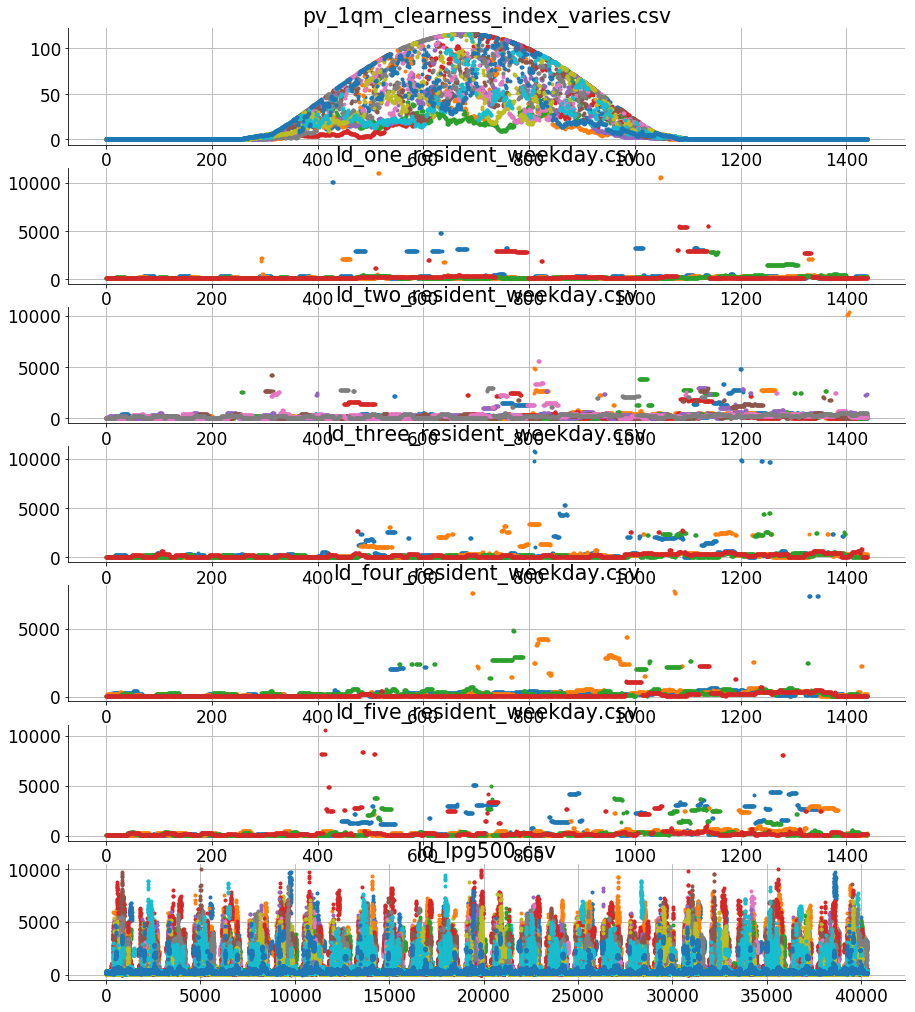

In [19]:
fig, axes = plt.subplots(len(mimp),1, figsize=(15,len(mimp)*2.5), sharex=False)
for ax, (key, value) in zip(axes, mimp.items()):
    ax.grid(True)
    ax.plot(value.transpose(), '.')
    ax.set_title(key)


In [20]:
mimp['de_epex_spot_intraday_continuous.csv'] = pd.read_csv('time_series/epex/de_epex_spot_intraday_continuous.csv', sep=',', skipinitialspace=True)[24:]#skip last july day
# http://www.epexspot.com/en/market-data/intradaycontinuous/intraday-table/2018-08-01/DE

In [21]:
def map_ppl_to_mimp_key(ppl):
    """helper function for crest load profiles"""
    if ppl == 1:
        key = 'ld_one_resident_weekday.csv'
    elif ppl == 2:
        key = 'ld_two_resident_weekday.csv'
    elif ppl == 3:
        key = 'ld_three_resident_weekday.csv'
    elif ppl == 4:
        key = 'ld_four_resident_weekday.csv'
    elif ppl == 5:
        key = 'ld_five_resident_weekday.csv'
    return key

### Model grid_20peers<a name="Aexe3Kai"></a>

### Model building <a name="EiNie3ie"></a>
    Parametrise and build the scenario

##### Preprocessing
    which import data and parameters to use for the mrss

In [22]:
# pv profile from incl. parameters at file: CREST_Integrated_PV_electricity_demand_model_1.0B1.xlsm
prp_profile_pv_1mo = np.tile(mimp['pv_1qm_clearness_index_varies.csv'][0],1*7*4)

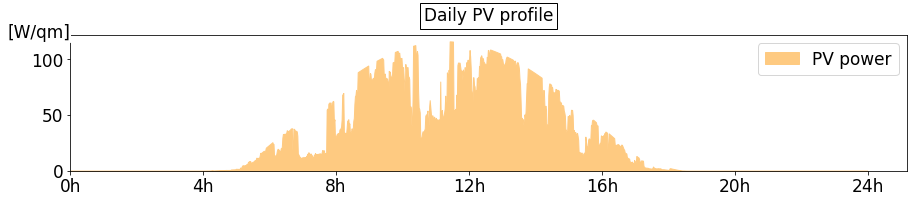

In [23]:
days = 1
tmp0 = np.arange(1440*days)
tmp1 = prp_profile_pv_1mo[:1440*days]

fig, axs = plt.subplots(1,1, figsize=(15,2.5*1))
axs = [axs]
axs[0].fill_between(x=tmp0, y1=tmp1, color=mcolor['pv'])
axs[0].set_ylim(0)
axs[0].set_xlim(0)
axs[0].set_xticks([x for x in range(0,1440+1,60*4)])
axs[0].set_xticklabels( [*(f'{i}h' for i in range(0,24+1,4))])
axs[0].text(0,0.95,'[W/qm]', va='bottom', ha='right', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':0})
fig.legend((['PV power']), bbox_to_anchor=(1,1), bbox_transform=axs[0].transAxes, frameon=True)
axs[0].set_title('Daily PV profile', y=1, pad=+10, va="bottom",ha='center', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].spines['top'].set_visible(True)
axs[0].spines['right'].set_visible(True)
plt.show()

In [24]:
# pv profile repeats each day; res 60s; hh has power output of profile[W/qm] * panel[m]
# from cha5aiQu: pvs range from 5 to 40qm with mean 18 on std 7
# LATER kWpeak and links
pd.DataFrame(tmp1).describe().T

count       mean      std  min  25%     50%       75%      max
0  1440.0  27.707972  36.2735  0.0  0.0  5.0345  49.14625  116.082

In [25]:
to_kWh(27 * 1440*60)*10

6.48

In [26]:
grid_20peers = np.array(#holds microgrid info; helps to build mrss; CREST only: #ppl #ld_idx #pv_idx
        #hh_j #x #y #ppl #ld_idx #pv_idx #qm #chmax #dchmax #Psocmax
    [  [  1,  30,  60,   2,   0,   0,  0,     0,     0,     0],#no es, no pv
       [  2,  50,  60,   3,   0,   0,  0,     0,     0,     0],#no es
       [  3,  70,  60,   4,   0,   0,  0,     0,     0,     0],
       [  4,  90,  60,   1,   0,   0,  0,     0,     0,     0],
       [  4,  95,  60,   2,   4,   0,  0,     0,     0,     0],#2. floor
       [  5,  110,  60,  5,   0,   0,  0,     0,     0,     0],#two pv
       [  6,  30,  20,   2,   1,   0,  0,     0,     0,     0],
       [  7,  50,  20,   3,   1,   0,  0,     0,     0,     0],
       [  8,  70,  20,   4,   1,   0,  0,     0,     0,     0],
       [  9,  90,  20,   5,   1,   0,  0,     0,     0,     0],
       [ 10, 110,  20,   2,   5,   0,  0,     0,     0,     0],
       [ 11,  30, -20,   2,   2,   0,  0,     0,     0,     0],
       [ 12,  50, -20,   3,   2,   0,  0,     0,     0,     0],
       [ 13,  70, -20,   4,   2,   0,  0,     0,     0,     0],
       [ 14,  90, -20,   5,   2,   0,  0,     0,     0,     0],
       [ 15, 110, -20,   1,   2,   0,  0,     0,     0,     0],
       [ 16,  30, -60,   2,   3,   0,  0,     0,     0,     0],
       [ 17,  50, -60,   3,   3,   0,  0,     0,     0,     0],
       [ 18,  70, -60,   4,   3,   0,  0,     0,     0,     0],
       [ 19,  90, -60,   5,   3,   0,  0,     0,     0,     0],
       [ 20, 110, -60,   1,   3,   0,  0,     0,     0,     0]])

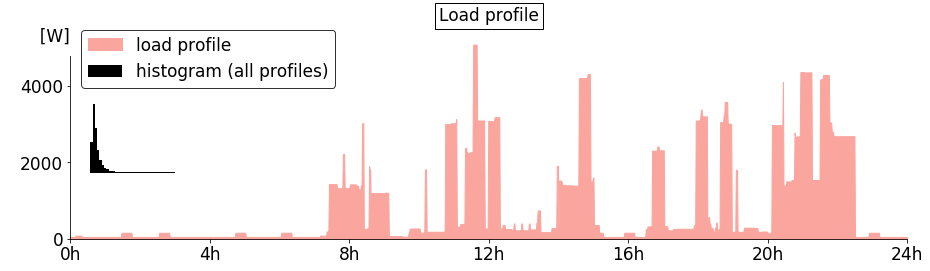

In [27]:
tmp0 = mimp['ld_five_resident_weekday.csv'][0]
tmp1 = mimp['ld_lpg500.csv']
fig, axs = plt.subplots(figsize=(15,1.5*2.5))
gs = gridspec.GridSpec(1,1,width_ratios=[1]) 
axs0 = plt.subplot(gs[0])
axs0.fill_between(np.arange(1440), tmp0, color=mcolor['ld'])
axs0.set_xlim(0,1440)
axs0.set_ylim(0)
axs0.set_xticks([x for x in range(0,1440+1,60*4)])
axs0.set_xticklabels( [*(f'{i}h' for i in range(0,24+1,4))])

axs_ins = inset_axes(axs0, width="30%", height=1., loc='center left')#inset histo
axs_ins.set_axis_off()
axs_ins.hist(tmp1.flatten(), bins=100, color='k')

axs0.text(0,0.95,'  [W]', va='bottom', ha='right', transform=axs0.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':10})
fig.legend((['load profile', 'histogram (all profiles)']), bbox_to_anchor=(0.37,0.9), bbox_transform=fig.transFigure, frameon=True, ncol=1, borderaxespad=0., edgecolor='k')
axs0.text(0.5,1.05,'Load profile', va='bottom', ha='center', transform=axs0.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
plt.show()

In [28]:
pd.DataFrame(tmp0).describe().T

count        mean       std   min   25%    50%     75%     max
0  1440.0  864.705556  1242.391  49.0  49.0  184.0  1399.0  5076.0

In [29]:
#  typical ld profile with five residents (crest)
    # power load profile histogramm


In [30]:
foo = np.sum(mimp['ld_lpg500.csv'], axis=1) * 12 *60 / 1000 / 3600 #per hh consum kWh/year


In [31]:
pd.DataFrame(foo).describe().T

count         mean          std          min          25%          50%  \
0   21.0  4199.608504  1722.055575  1294.719015  3204.626303  4044.372113   

           75%          max  
0  5242.707818  9185.375584

In [32]:
def get_pv_qm(P_ld, P_pv_profile_1qm):
    """returns pv size in qm on given load profile so that E_ld == E_pv_1qm * qm
    profiles must have same stepsize
    """
    return abs(P_ld.sum() / P_pv_profile_1qm.sum())

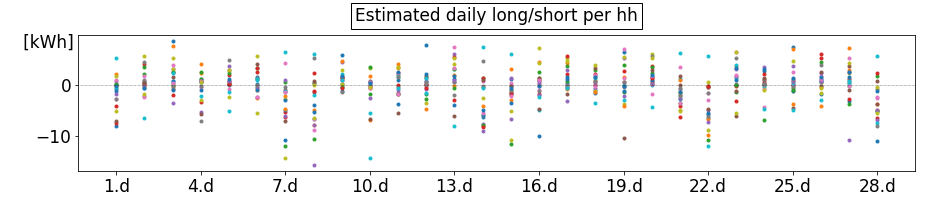

In [33]:
for i in range(21):#LPG
    prp_profile_ld_j_day = mimp['ld_lpg500.csv'][i].reshape(4*7,1440)
#     prp_profile_ld_j_day_ref = np.average(np.sum(prp_profile_ld_j_day, axis=1))#avg day ld
    prp_profile_ld_j_day_ref = np.percentile(np.sum(prp_profile_ld_j_day, axis=1), q=50)#3of4w auton.
    qm = get_pv_qm(prp_profile_ld_j_day_ref, prp_profile_pv_1mo[:1440])
    grid_20peers[i,6] = qm#save qm that covers the ref load

    P_k_pv = prp_profile_pv_1mo*qm
    P_k_ld = mimp['ld_lpg500.csv'][i]*-1     
    prp_profile_j_res_est = to_kWh((P_k_pv[:1440].sum() - np.sum(prp_profile_ld_j_day, axis=1))*60)#res
    plt.plot(prp_profile_j_res_est, '.')#>0 oversupply
    
    grid_20peers[i,7] = np.percentile(P_k_pv[:1440], q=100)*-1#test P_pv <= P_ch, is max, chmax
    #test P_ld > P_dch holds for 95 percentil, otherwise P_dch_max unrealistic
    grid_20peers[i,8] = np.percentile(P_k_ld*-1, q=95)#dchmax, fits to chmax of typical es
    Psocmax = P_k_pv[:1440].sum()*-1*0.5# == prp_profile_ld_j_day_ref*-1*scalef
    grid_20peers[i,9] = Psocmax
grid_20peers[:,9] = np.where(to_kWh(grid_20peers[:,9]*60)<-15, to_Ws(-15)/60, grid_20peers[:,9])
plt.gca().set_title('Estimated daily long/short per hh', y=1, pad=+10, va="bottom",ha='center', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
plt.gca().set_xticks(np.arange(0,29,3))
plt.gca().set_xticklabels( [*(f'{i}.d' for i in range(1,29,3))])
plt.gca().axhline(y=0, linestyle=':', lw=0.5, color='k')
plt.gca().text(-0.005,0.88,'   [kWh]', va='bottom', ha='right', transform=plt.gca().transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':0})
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.show()

In [34]:
# per day great vary prod-cons ratio; per day same pv 16kWh diff load makes hh pot. able to self-supply SSR, eg hh1 8 to 22 kWh dayly with 16-8>0 long
# on monthly basis slightly short; 
#     LATER detail pv dim: dayly pctl 50 fits, eg makes hh1 16/28 dayly short
df((prp_profile_pv_1mo.sum() * grid_20peers[:,6] ) / mimp['ld_lpg500.csv'][:21].sum(axis=1)).T.round(2)#pv/ld month ratio

0     1     2     3     4     5     6     7     8     9   ...    11  \
0  0.92  0.97  0.97  0.99  0.91  0.86  1.02  0.92  0.96  0.81  ...  0.93   

     12    13    14    15    16    17    18    19    20  
0  0.88  0.97  0.83  0.84  0.89  0.98  0.95  0.96  0.98  

[1 rows x 21 columns]

In [35]:
to_kWh((P_k_pv[:1440].sum() - np.sum(prp_profile_ld_j_day, axis=1))*60)#res

array([-0.33686856, -0.6579078 , -1.11875009, -1.07669413,  1.02410662,
       -1.16158957, -3.02272287, -3.96126   ,  1.57405571,  0.23101594,
        2.47641955,  2.15770801,  1.64982056, -4.91042182, -0.72201863,
       -0.23101594,  1.4049571 ,  1.46352737, -1.16842782,  1.83869986,
       -1.48825419, -5.61772344,  3.25811484,  2.98420485,  1.24886575,
        1.39439282,  2.47540233, -1.29469519])

In [36]:
to_kWh(prp_profile_pv_1mo[:1440].sum() * grid_20peers[0,6] )*60, to_kWh(mimp['ld_lpg500.csv'][1].reshape(4*7,1440).sum(axis=1))*60

(15.959791599999997,
 array([16.03505576, 15.96104923, 15.93443757, 13.37365385, 15.04636458,
        18.26090032, 17.94981043, 20.67673193, 14.49602745, 13.92958775,
        12.38134144, 15.70885483, 16.00163   , 19.88899486, 18.8065663 ,
        15.52993585, 11.38996184, 14.87822013, 14.21288558, 14.43549945,
        17.40356408, 22.3939543 , 14.24303852, 15.6790676 ,  8.787374  ,
        16.22587209, 12.78794138, 19.41956986]))

In [37]:
pctl = (prp_profile_pv_1mo[:1440].sum() * grid_20peers[1,6] ) / mimp['ld_lpg500.csv'][1].reshape(4*7,1440).sum(axis=1)
pctl, (pctl<1).sum(), (pctl<1).sum() / 28

(array([0.95383518, 0.95825782, 0.95985818, 1.14365157, 1.01651134,
        0.83757099, 0.85208701, 0.73971072, 1.05510288, 1.09800811,
        1.23531044, 0.97364197, 0.95582764, 0.76900821, 0.81326915,
        0.98485921, 1.34283157, 1.02799933, 1.0761221 , 1.05952692,
        0.8788315 , 0.68298792, 1.07384392, 0.9754917 , 1.74054277,
        0.94261807, 1.19603303, 0.78759727]), 16, 0.5714285714285714)

In [38]:

# cha5aiQu
display(pd.DataFrame(grid_20peers[:,-4]).T)#prints #qm 
pd.DataFrame(grid_20peers[:,-4]).describe().T#meta pv

0   1   2   3   4   5   6   7   8   9   ...  11  12  13  14  15  16  17  \
0  24  23  15  17  22   5  21   9  19   9  ...  25  16  40  14  16  11  23   

   18  19  20  
0  15  22  14  

[1 rows x 21 columns]

count      mean       std  min   25%   50%   75%   max
0   21.0  17.52381  7.730582  5.0  14.0  16.0  22.0  40.0

##### about es:

In [39]:
# detail es dim: 0.5*full_day_pv_kWh so 50% instant consum, v CREST  4.4kWh CREST
# max/min/mean soc
tmp0 = to_kWh(grid_20peers[:,9]*60)
display(df(tmp0).describe().T)
tmp0

count      mean       std        min       25%       50%       75%    max
0   21.0 -6.011399  2.583031 -13.483317 -7.581983 -5.466283 -4.740433 -1.882

array([ -8.11686667,  -7.84696667,  -5.17081667,  -5.671     ,
        -7.58166667,  -1.882     ,  -7.17478333,  -3.21455   ,
        -6.56951667,  -3.16206667,  -2.8327    ,  -8.59466667,
        -5.33618333, -13.48331667,  -4.90783333,  -5.46628333,
        -3.80746667,  -7.8902    ,  -5.20808333,  -7.58198333,
        -4.74043333])

    About es loss:
    es eff_rt is set to 0.95 for CHC+ES with DC input; also have MPPT
    [1] https://core.ac.uk/download/pdf/148682273.pdf see 4.1
    [2] https://onlinelibrary.wiley.com/doi/pdf/10.1002/9780470974704.ch21 see 21.1.1.8
    [3] https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8341567 for DC/DC configurations
    
    es pct_dch_idle is set to 0.05*E_soc per month which is 
    [4] http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.401.7780&rep=rep1&type=pdf

In [40]:
pct_dch_idle = 5/100 / (30*24*60)#siml will be 60s kclock, so min a mo not s a mo
# pct_dch_idle = 1-(0.95)**(1/(30*24*60)) #exact solution, postum determined
soc = -10
for k in range(30*24*60):
    soc = soc * (1 - pct_dch_idle)
print(f'start {-10}kWh, end month {soc:.3}kWh, {1-soc/-10:.2}%, pct_dch_idle {pct_dch_idle*1e2:.3}%/min')

start -10kWh, end month -9.51kWh, 0.049%, pct_dch_idle 0.000116%/min


##### about inverter:

In [41]:
#data kindly provided from the contact person of paper DOI: 10.3390/en8064853
tmp0 = np.array([[50.77,44.13,58.41,70.73,86.74], #3% #
        [69.6,67.3,75.23,82.56,90.9], #5%
        [83.56,84.46,87.69,91.31,93.98], #10%
        [90.18,92.59,93.58,95.44,95.43], #20%
        [92.07,94.9,95.24,96.6,95.83], #30%
        [93,96,96,97.1,96], #60%
        [92.03,94.76,95.04,96.38,95.73],])/100 #100%
dff = pd.DataFrame(tmp0, columns=["Sunny Boy SWR 1100LV", "PVIN05KS", "IG Plus 12", "Ingecon Sun 100 LV", "Sinvert 200 MS"], index=["Pdc 3%", "5%", "10%", "20%", "30%", "60%", "100%"])
dff['OpenDSS Generic'] = ['-', '-', 0.86, 0.90, 0.92, 0.94, 0.97]
dff

Sunny Boy SWR 1100LV  PVIN05KS  IG Plus 12  Ingecon Sun 100 LV  \
Pdc 3%                0.5077    0.4413      0.5841              0.7073   
5%                    0.6960    0.6730      0.7523              0.8256   
10%                   0.8356    0.8446      0.8769              0.9131   
20%                   0.9018    0.9259      0.9358              0.9544   
30%                   0.9207    0.9490      0.9524              0.9660   
60%                   0.9300    0.9600      0.9600              0.9710   
100%                  0.9203    0.9476      0.9504              0.9638   

        Sinvert 200 MS OpenDSS Generic  
Pdc 3%          0.8674               -  
5%              0.9090               -  
10%             0.9398            0.86  
20%             0.9543             0.9  
30%             0.9583            0.92  
60%             0.9600            0.94  
100%            0.9573            0.97

In [42]:
def func(x, a, b, c):
    return a*x / (b-x) + c*x
xdata = np.array([0, 10, 100, 1000, 2000, 5000, 1e4])
ydata = np.array([0, 0.1, 0.45, 0.97, 0.94, 0.92, 0.8])
popt, pcov = curve_fit(func, xdata, ydata)
popt#inverter coeff ABC

array([-1.09363625e+00, -1.34235172e+02, -2.83214366e-05])

In [43]:
def inv_effs_m1(P_max, num=1000, CC_A=popt[0], CC_B=popt[1], CC_C=popt[2]):
    """returns eff [0;1] array of given P_nom,float of length num;  num is resolution
    more info see Inverter class; chosen over _m2 since Continuous function and defined at 0
    """
    P_set = np.linspace(0,P_max, num=num)
    eff = CC_A * P_set / (CC_B - P_set) + CC_C * P_set
    return P_set,eff

In [44]:
def inv_effs_m2(P_max, num=1000, CC_A=98.236, CC_B=-4.786, CC_C=-1.42):
    """returns eff [0;1] array of given P_max,float of length num; 
    more info see Inverter class, diff params:
    ABC = [[1,1.1,93,98.236,-4.786,-1.42,0.998],
            [5,-,96,102.53,-6.019,-1.75,1],
            [12,12.6,96,100.83,-4.517,-1.27,1],
            [100,105,97.1,100.56,-3.283,-0.89,0.998],
            [200,210,96,97.24,-1.194,-0.31,0.995],]
    """
    P_set = np.linspace(0,P_max, num=num)#num is resolution
    P_pu = P_set / P_max
    eff = np.zeros( (num) )#eff 1 for P_set=0
    eff[1:] = CC_A + CC_B*P_pu[1:] + CC_C/P_pu[1:]
    eff[1:] = np.where(eff[1:]>10, eff[1:], 10) / 100
    return P_set,eff

In [45]:
num=10000#generate lookup_P_out and lookup_P_in
lookup_eff = np.zeros( (num) )
lookup_P_out = np.zeros( (num) )
P_max = 1e4
P_set, lookup_eff = inv_effs_m1(P_max, num=num)
lookup_P_out = lookup_eff * P_set

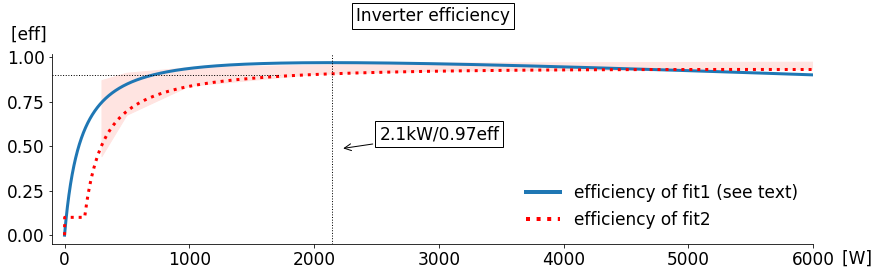

In [46]:
#P_nom is about 3500, MPP-tracking; all except one on 95.pctl ld; all pv; is num suff -> plots
P_set_m2, eff_m2 = inv_effs_m2(P_max, num=num)

P_out = np.arange(num)#aequidistant in P lookup not eff
eff_by_out = np.zeros( (num) )
for i in range(num):
    eff_by_out[i] = Inverter._lookup_eff(P_out[i])

fig, axs = plt.subplots(1,2, figsize=(15*2,2*1.75))
axs[0].text(0.5,1.15,'Inverter efficiency', va='bottom', ha='center', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].fill_between(np.array([3,5,10,20,30,60,100])/100*1e4, tmp0.min(axis=1), tmp0.max(axis=1), color='mistyrose')# plt.fill_between()
axs[0].plot(P_set,lookup_eff, lw=3)
axs[0].plot(P_set_m2, eff_m2, 'r:', lw=3) 
axs[0].set_xlim(-100,6000)
ax0t = axs[0].twinx()
# ax0t.plot(P_set, eff_m2, color='k', lw=0.5)
ax0t.set_axis_off()
leg = axs[0].legend(('efficiency of fit1 (see text)', 'efficiency of fit2'))
plt.setp(leg.get_lines(), lw=4)

axs[1].text(0.5,1.15,'Detailed efficiency on lower powers', va='bottom', ha='center', transform=axs[1].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[1].plot(P_set[:1000],lookup_eff[:1000], lw=3)
axs[1].plot(P_set[:1000]*lookup_eff[:1000], lookup_eff[:1000], lw=3, color='green')#exact to test eff_by_out
axs[1].plot(P_out[:200],eff_by_out[:200], lw=4, ls='--', color='orange')#lookup
leg = axs[1].legend(('P_set', 'P_out', 'P_out lookup'))
plt.setp(leg.get_lines(), lw=4) 
axs[0].axvline(lookup_eff.argmax(), linestyle=':', lw=1, color='k') 
axs[0].axhline(0.9, xmax=0.3, linestyle=':', lw=1, color='k')
# plt.delaxes(axs[0])
plt.delaxes(axs[1])
axs[0].text(-0.0,1.05,'[eff] ', va='bottom', ha='right', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':0})
axs[0].text(1.085,-0.125,'[W] ', va='bottom', ha='right', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':0})
axs[1].text(-0.02,1.05,'[eff] ', va='bottom', ha='right', transform=axs[1].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':0})
axs[1].text(1.11,-0.125,'[W] ', va='bottom', ha='right', transform=axs[1].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':0})
xy = np.array((0.38,0.5))
axs[0].annotate('2.1kW/0.97eff', xy, xytext=xy+[0.05,0.05], size=17, xycoords='axes fraction', bbox={'facecolor':'white'}, arrowprops={'arrowstyle':'->'})

plt.show()

In [47]:
lookup_eff.argmax()

2142

In [48]:
lookup_eff[[100,250, 500, 600, 800,2142]]

array([0.46409101, 0.70451077, 0.84802546, 0.87671602, 0.91385164,
       0.96847732])

In [49]:
# inverter  
# [0] doi:10.3390/en8064853 
# [1] https://doi.org/10.1109/APEC.2018.8341567 high eff invs (..folder)
#  0.47
# left plot:
#     two eff funcs: _m1 blue used and _m2 (undef in 0 since limx0 -inf, excl close to0 range)
display((lookup_eff[[100,250, 500]], lookup_eff.max(), lookup_eff.argmax()))#blue: 
#       red:  higher eff so bestcase, effect would increase on low P lower eff
#     clsoe to 'where fit from' but up to 10k, so unbounded: heat prob above nom, but range seldom, no cap to not inv bottleneck
# right plot: low eff on low P (blue); use lookup since no simple inverse, efficient and 'precision ok' on 10k points gree_orange overlay;
#     lookup  needs unique similar to inverse needs bijection
display(np.all((P_set*lookup_eff)[1:] >= (P_set*lookup_eff)[:-1]))#ASM3 validwhat???  gray line monoton output
#     green_orange curve is look efff from output side: for 10w out need 40 in
10 / Inverter._lookup_eff(P_out=10), Inverter._lookup_eff(P_out=10)#P_in,eff to test lookup 
#     df(lookup_eff)[700:] #when 0.9

(array([0.46409101, 0.70451077, 0.84802546]), 0.9684773180040092, 2142)

True

(40.00677450268998, 0.24995766652789314)

##### Scenario 1: grid_20peers individual control<a name="Ooph2it9"></a>
    each hh controls es on its own:
                 pv ---xl--- inv --xr--- grid-
                       |           |
                       es          ld

In [50]:
class Control0(Resource):#NoInvNoPvNoEs
    """Implements microgrid control logic
    """
    log_titles = ('P_j_res [W]'#grid counter-flows this; logged for later energy conservation test
                 )
    log_index_P = None#index in log_titles that logs power prosumed
    
    rollback_to_k = None
    
    def __init__(self, **kwargs):
        super(Control0, self).__init__(**kwargs)
        
    def __repr__(self):
        return (f'Control0({super(Control0, self).__repr__()})')

    def __str__(self):
        return (f'Control0({super(Control0, self).__repr__()})')
            
    def end(self, K):
        pass
            
    def step(self, k):
        Resource.step(self, k)
        """place logic here, make sure to have energy conservation in==out
        """
        P_bal = 0#energy conservation 
        
        P_j_ld = get_power_grp('hh', j=0, ct_rs='ld')[k]
        P_j_res = P_j_ld
        P_bal = P_j_res
        
        assert abs(get_power_grp('hh', j=0)[k] - P_j_res) < 1e-6
        
        self.view[0,k] = P_bal#keep track of in/outflow
        P_bal += self.view[0,k] *-1#now satisfy in/outflow locally
        assert P_bal == 0, 'power inflow != outflow'

        
class Control1(Resource):#NoEs
    """Implements microgrid Control1 logic
    """
    log_titles = ('P_j_res [W]'
                 )
    log_index_P = None#index in log_titles that logs power prosumed
    
    rollback_to_k = None
    
    def __init__(self, **kwargs):
        super(Control1, self).__init__(**kwargs)
        
    def __repr__(self):
        return (f'Control1({super(Control1, self).__repr__()})')

    def __str__(self):
        return (f'Control1({super(Control1, self).__repr__()})')
    
    def step(self, k):
        Resource.step(self, k)
        """place logic here, make sure to have energy conservation in==out
        """
        P_bal = 0#energy conservation
        
        P_j_pv = get_power_grp('hh', j=1, ct_rs='pv')[k]
        rs_inv = get_rss('hh', j=1, ct_rs='inv')[0]#unpack the only inv
        P_j_pv_xr = rs_inv.set_P(k, P_j_pv).get_eff(k) * P_j_pv#go right over inv
        P_j_res = P_j_pv_xr + get_power_grp('hh', j=1, ct_rs='ld')[k]#add load
        P_bal = P_j_res#residual to/from extern
        
        assert abs(get_power_grp('hh', j=1)[k] - P_j_res) < 1e-6
        
        self.view[0,k] = P_bal#keep track of in/outflow
        P_bal += self.view[0,k] *-1#now satisfy in/outflow locally
        assert P_bal == 0, 'power inflow != outflow'

        
class Control2(Resource):
    """Implements microgrid Control2 logic
    """
    log_titles = ('P_j_res [W]',
                 )
    log_index_P = None#index in log_titles that logs power prosumed
    
    rollback_to_k = None
    
    def __init__(self, j=None, **kwargs):
        super(Control2, self).__init__(**kwargs)
        self.j = j
        
    def __repr__(self):
        return (f'Control2({super(Control2, self).__repr__()})')

    def __str__(self):
        return (f'Control2({super(Control2, self).__repr__()})')
            
    def step(self, k):
        Resource.step(self, k) 
        """place logic here, make sure to have energy conservation in==out
        """
        P_bal = 0#energy conservation

        P_j_pv = get_power_grp('hh', j=self.j, ct_rs='pv')[k]
        P_j_ld = get_power_grp('hh', j=self.j, ct_rs='ld')[k]
        rs_inv = get_rss('hh', j=self.j, ct_rs='inv')[0]#unpack the only inv
        rs_es = get_rss('hh', j=self.j, ct_rs='es')[0]#unpack the only es
        assert P_j_pv + rs_es.P_ch_const <= 0, 'es unable to consume pv surplus'#ASM0 violated
        
        P_j_ld_xl =  P_j_ld / rs_inv.set_P_by_out(k, abs(P_j_ld)).get_eff(k)#assume self-suff at k
        P_j_ld_xl_pv = P_j_ld_xl + P_j_pv 
            
        if P_j_ld_xl_pv >= 0:#charge es with surplus
            if P_j_ld_xl_pv + rs_es.P_ch_max <= 0:#es can consume surplus
                rs_es.set_P(k, P_j_ld_xl_pv*-1)
                P_j_res = 0
            else:#oversupply despite charging; soc=full, do balancing at xr since inv eff changes
                rs_es.set_P(k, rs_es.P_ch_max)
                P_j_ch_pv = rs_es.P_ch_max + P_j_pv
                assert P_j_ch_pv > 0, 'able to charge pv output'#bad branch
                if abs(P_j_ch_pv) < 1e-9 and abs(P_j_ch_pv) != 0:
                    set_trace()
                P_j_ch_pv_xr = rs_inv.set_P(k, P_j_ch_pv).get_eff(k) * P_j_ch_pv
                P_j_res = P_j_ch_pv_xr + P_j_ld 
                assert P_j_res >= -1, 'lower inv eff causes hh to swap short'#ASM1 viol.
        else:#discharge es since shortage
            if P_j_ld_xl_pv + rs_es.P_dch_max >= 0:#es can produce whats short
                rs_es.set_P(k, P_j_ld_xl_pv*-1)
                P_j_res = 0
            else:#short desp. discharging, 95.pctl+pv or soc=0; do balancing at xr since inv eff changes
                rs_es.set_P(k, rs_es.P_dch_max)
                P_j_dch_pv = rs_es.P_dch_max + P_j_pv
                if abs(P_j_dch_pv) < 1e-9 and abs(P_j_dch_pv) != 0:
                    set_trace()
                P_j_dch_pv_xr = rs_inv.set_P(k, P_j_dch_pv).get_eff(k) * P_j_dch_pv
                P_j_res = P_j_dch_pv_xr + P_j_ld
                assert P_j_res <= 1, 'higher inv eff causes hh to swap surplus'#ASM1 viol.
        #endif 
        assert abs(get_power_grp('hh', j=self.j)[k] - P_j_res) < 1e-9#res ok incl. prec.e
                
        P_bal += P_j_res#residual from/to extern 
        
        self.view[0,k] = P_bal#keep track of in/outflow
        P_bal += self.view[0,k] *-1#now satisfy in/outflow locally since tracked
        assert P_bal == 0, 'power inflow != outflow'
        

In [51]:
Resource.K = 1440*7*4
Resource.kclock = 60
mrss = OrderedDict({
    'ctrl': [Control0(r=200,ct='ctrl',cord1=30,cord2=60), Control1(r=201,ct='ctrl',cord1=50,cord2=60),
             Control2(r=202,ct='ctrl',cord1=70,cord2=60,j=2), Control2(r=203,ct='ctrl',cord1=90,cord2=60,j=3),
             *(Control2(r=i+204,ct='ctrl',cord1=x,cord2=y,j=i+4) for (i),(x,y) in zip(range(16),grid_20peers[5:,1:3]))],
    'hh_ld': [TimeSeries(r=i+1,ct='ld',cord1=x,cord2=y) for (i),(x,y) in zip(range(21),grid_20peers[:,1:3]) ],
    'hh_pv': [TimeSeries(r=31,ct='pv',cord1=50,cord2=60),
              TimeSeries(r=32,ct='pv',cord1=70,cord2=60),
              TimeSeries(r=33,ct='pv',cord1=90,cord2=60),
              TimeSeries(r=34,ct='pv',cord1=110,cord2=60),
              TimeSeries(r=35,ct='pv',cord1=115,cord2=60),
              *(TimeSeries(r=i+36,ct='pv',cord1=x,cord2=y) for (i),(x,y) in zip(range(15),grid_20peers[6:,1:3])) ],
    'hh_es': [BatteryRPL(r=61,ct='es',cord1=70,cord2=60,E_soc=-0*1000*3600,E_soc_max=grid_20peers[2,9]*Resource.kclock,\
                      P_ch_const=-3800,P_dch_const=3800,pct_dch_idle=pct_dch_idle, eff_rt=0.95),
            BatteryRPL(r=62,ct='es',cord1=90,cord2=60,E_soc=-0*1000*3600,E_soc_max=grid_20peers[3,9]*Resource.kclock,\
                      P_ch_const=-3800,P_dch_const=3800,pct_dch_idle=pct_dch_idle, eff_rt=0.95),#no[4,9]
            *(BatteryRPL(r=i+63,ct='es',cord1=x,cord2=y,E_soc=-0*1000*3600,E_soc_max=E_soc_max*Resource.kclock,\
                      P_ch_const=-3800,P_dch_const=3800,pct_dch_idle=pct_dch_idle, eff_rt=0.95)\
              for (i),(x,y),E_soc_max in zip(range(8),grid_20peers[5:13,1:3], grid_20peers[5:13,9])),
            BatteryRPL(r=71,ct='es',cord1=70,cord2=-20,E_soc=-0*1000*3600,E_soc_max=grid_20peers[13,9]*Resource.kclock,\
                      P_ch_const=-5043,P_dch_const=5043,pct_dch_idle=pct_dch_idle, eff_rt=0.95),
            *(BatteryRPL(r=i+72,ct='es',cord1=x,cord2=y,E_soc=-0*1000*3600,E_soc_max=E_soc_max*Resource.kclock,\
                      P_ch_const=-3800,P_dch_const=3800,pct_dch_idle=pct_dch_idle, eff_rt=0.95)\
              for (i),(x,y),E_soc_max in zip(range(7),grid_20peers[14:21,1:3], grid_20peers[14:21,9])) 
             ],
    'hh_inv': [Inverter(r=91,ct='inv',cord1=50,cord2=60,P_nom=3500, CC=popt),#ABC defaults
               Inverter(r=92,ct='inv',cord1=70,cord2=60,P_nom=3500, CC=popt),
               Inverter(r=93,ct='inv',cord1=90,cord2=60,P_nom=3500, CC=popt),
               *(Inverter(r=i+94,ct='inv',cord1=x,cord2=y,P_nom=3500, CC=popt) for (i),(x,y) in zip(range(8),grid_20peers[5:13,1:3])),
               Inverter(r=102,ct='inv',cord1=70,cord2=-20,P_nom=5043, CC=popt),
               *(Inverter(r=i+103,ct='inv',cord1=x,cord2=y,P_nom=3500, CC=popt) for (i),(x,y) in zip(range(7),grid_20peers[14:21,1:3])),
              ],
})
magg = {
    'hh': [[1,200], [2,31,91,201], [3,32,61,92,202], [4,5,33,62,93,203], [6,34,35,63,94,204],
           [7,36,64,95,205], [8,37,65,96,206], [9,38,66,97,207], [10,39,67,98,208], [11,40,68,99,209],
           [12,41,69,100,210], [13,42,70,101,211], [14,43,71,102,212], [15,44,72,103,213], [16,45,73,104,214],
           [17,46,74,105,215], [18,47,75,106,216], [19,48,76,107,217], [20,49,77,108,218], [21,50,78,109,219], ]
}
mdata, mmap = simulation_init()

mdata['hh_ld'][0] = mimp['ld_lpg500.csv'][0] *-1#j=0, might use mdata directly
get_rss('hh', j=1, ct_rs='ld')[0].view[0] = mimp['ld_lpg500.csv'][1] *-1
get_rss('hh', j=2, ct_rs='ld')[0].view[0] = mimp['ld_lpg500.csv'][2] *-1
get_rss('hh', j=3, ct_rs='ld')[0].view[0] = mimp['ld_lpg500.csv'][3] *-1
get_rss('hh', j=3, ct_rs='ld')[1].view[0] = mimp['ld_lpg500.csv'][4] *-1
get_rss('hh', j=4, ct_rs='ld')[0].view[0] = mimp['ld_lpg500.csv'][5] *-1

get_rss('hh', j=1, ct_rs='pv')[0].view[0] = prp_profile_pv_1mo * grid_20peers[1,6]
get_rss('hh', j=2, ct_rs='pv')[0].view[0] = prp_profile_pv_1mo * grid_20peers[2,6]
get_rss('hh', j=3, ct_rs='pv')[0].view[0] = prp_profile_pv_1mo * grid_20peers[3,6]#short since two lds
get_rss('hh', j=4, ct_rs='pv')[0].view[0] = prp_profile_pv_1mo * grid_20peers[5,6]/2
get_rss('hh', j=4, ct_rs='pv')[1].view[0] = prp_profile_pv_1mo * grid_20peers[5,6]/2
for j in range(5,20):#profile import, each round one hh;
    rs = get_rss('hh', j=j, ct_rs='ld')[0]#load
    rs.view[0] = mimp['ld_lpg500.csv'][j+1] *-1
    
    rs = get_rss('hh', j=j, ct_rs='pv')[0]#pv
    qm = grid_20peers[j+1,6]
    rs.view[0] = prp_profile_pv_1mo * qm

In [52]:
%%time 
# simulation_run(up_to_k=Resource.K)
simulation_load('mdata_idv_v0')#instead of run or save

CPU times: user 28 ms, sys: 140 ms, total: 168 ms
Wall time: 170 ms


##### Postprocessing
    store all info for postproess, so another siml can run. 
    check results for plausibility

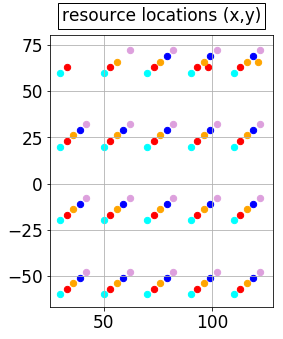

In [53]:
# plot_cords([[rs for key in mrss for rs in mrss[key]]])#plots all
plot_cords([[*(rs for rs in mrss['ctrl'])],[*(rs for rs in mrss['hh_ld'])],
                      [*(rs for rs in mrss['hh_pv'])],[*(rs for rs in mrss['hh_es'])],
                      [*(rs for rs in mrss['hh_inv'])],
                     ],colors=['cyan','red','orange','blue','plum'])

In [54]:
# LATER use nice plot


In [55]:
pop_idv = {}

In [56]:
J = len(magg['hh'])
pop_idv['P_j0toJ_es_ext'] = np.zeros( (J, Resource.K) )#calc. later
pop_idv['E_j0toJ_es_soc'] = np.zeros( (J, Resource.K) )
pop_idv['E_j0toJ_es_soc_max'] = np.zeros( (J) )
pop_idv['P_j0toJ_inv_loss'] = np.zeros( (J, Resource.K) )
pop_idv['P_j0toJ_inv_set_normed'] = np.zeros( (J, Resource.K) )
pop_idv['P_J_ld'] = np.sum(mdata['hh_ld'][:,0], axis=0).copy()
pop_idv['P_J_pv'] = np.sum(mdata['hh_pv'][:,0], axis=0).copy()
pop_idv['P_j2_ld'] = get_rss('hh', j=2, ct_rs='ld')[0].view[0].copy()#hh j2
pop_idv['P_j2_inv_loss'] = get_rss('hh', j=2, ct_rs='inv')[0].view[1].copy()
pop_idv['P_j2_pv'] = get_rss('hh', j=2, ct_rs='pv')[0].view[0].copy()
pop_idv['E_J_loss_es_total'] = np.sum(mdata['hh_es'][:,2], axis=0).copy()
pop_idv['E_J_loss_es_ch'] = np.where(mdata['hh_es'][:,0] < 0, mdata['hh_es'][:,2], 0).sum(axis=0).copy()
pop_idv['E_J_loss_es_dch'] = np.where(mdata['hh_es'][:,0] > 0, mdata['hh_es'][:,2], 0).sum(axis=0).copy()
pop_idv['E_J_loss_es_idle'] = np.where(mdata['hh_es'][:,0] == 0, mdata['hh_es'][:,2], 0).sum(axis=0).copy()
pop_idv['E_J_loss_inv'] = np.sum(mdata['hh_inv'][:,1,:], axis=0).copy()*Resource.kclock
pop_idv['P_J_res'] = get_power_grp('hh', j=None)
pop_idv['P_J_res_ctrl'] = np.zeros( (Resource.K) )#calc. later, should equal P_J_res
pop_idv['P_xfmr'] = None
pop_idv['P_j0toJ_res'] = np.zeros( (J, Resource.K) )#calc. later
pop_idv['C_j0toJ_res'] = None#calc. later from pop_idv
pop_idv['SSR_j0toJ'] = np.zeros( (J) )#each j
pop_idv['SCR_j0toJ'] = np.zeros( (J) )
pop_idv['SDR_k0toK'] = get_params('SDR', ct_grp='hh', j=None)#per k
pop_idv['RCR_k0toK'] = get_params('RCR', ct_grp='hh', j=None)#per k
pop_idv['SSR'] = get_param('SSR', ct_grp='', j=None)#grid-wide
pop_idv['SCR'] = get_param('SCR', ct_grp='', j=None)
pop_idv['RCR'] = get_param('RCR', ct_grp='', j=None)
pop_idv['GUR'] = get_param('GUR', ct_grp='hh', j=None)

for j in range(J):#extract E_j0toJ_res
    pop_idv['SSR_j0toJ'][j] = get_param('SSR', ct_grp='hh', j=j)
    pop_idv['SCR_j0toJ'][j] = get_param('SCR', ct_grp='hh', j=j)
    pop_idv['P_j0toJ_res'][j] += get_power_grp('hh', j=j)
    pop_idv['P_J_res_ctrl'] += get_rss('hh', j=j, ct_rs='ctrl')[0].view[0]
    for rs_inv in get_rss('hh', j=j, ct_rs='inv'):
        pop_idv['P_j0toJ_inv_loss'][j] += rs_inv.view[1]
        pop_idv['P_j0toJ_inv_set_normed'][j] += rs_inv.view[0] / rs_inv.P_nom_abs
    for rs_es in get_rss('hh', j=j, ct_rs='es'):
        pop_idv['P_j0toJ_es_ext'][j] += rs_es.view[0]
        pop_idv['E_j0toJ_es_soc'][j] += rs_es.view[3]
        pop_idv['E_j0toJ_es_soc_max'][j] += rs_es.E_soc_max

In [57]:
# assumptions
# ASM1 inverter eff not allowed to swap hh short/long on r2l2r, asserted
# ASM2 few stop-outs due ch/dch limit incl pv: have soc but could not dch more, p95., deepcycle no bursts
# ASM3 LATER inv should not exceed dchmax_happend + pv <mostly invPnom, to see if lax cond is valid %total

#### Scenario 2: grid_20peers collective control <a name="shoh0Du4"></a>
    Peers have central control

In [58]:
class Control(Resource):
    """Implements microgrid Control logic
    """
    log_titles = ('P_J_res [W]',
                 )
    log_index_P = None#index in log_titles that logs power prosumed
    
    rollback_to_k = None
    gekko_log = [None]*Resource.K*9
    
    def __init__(self, CC, **kwargs):
        super(Control, self).__init__(**kwargs)
        self.rss_es = None
        self.rss_inv = None
        self.N = 18#hardcode, num es
        self.CC = CC
        self.opts = ((1, 0), (2, 0), (1, 1), (2, 1), (1, 2), (2, 2), (3, 0),(3, 1),(3, 2),)
        self.range = range(len(self.opts))
        #combi: solver and 012 c loss / cnoloss / open_xfmr loss
    def __repr__(self):
        return (f'Control({super(Control, self).__repr__()})')

    def __str__(self):
        return (f'Control({super(Control, self).__repr__()})') 

    def init(self):#called after simulation_init
        self.rss_es = get_rss('hh', j=None, ct_rs='es')#j2toJ
        self.rss_inv = get_rss('hh', j=None, ct_rs='inv')#j1toJ      
    
    def build_solve_nlp(self, k, N, P_kJ_ld, P_kJ_pv, P_k_pv_, lbs, ubs):
        """returns P_J_res*-1 alias counter-flow of peers residual power, int
        returns P_k_es_ext_ es power to be set at each peer, list
        """
        for i in self.range:
            opt = self.opts[i]
            if opt[0] < 3:
                m = GEKKO(remote=False)
            else:
                m = GEKKO(remote=True)
            m.options.SOLVER = opt[0]#1:apopt 2:bpopt 3:ipopt
            m.options.IMODE = 3#try RTO
            A = m.Const(value=self.CC[0])#static scalar
            B = m.Const(value=self.CC[1])
            C = m.Const(value=self.CC[2])
            D = m.Const(value=(1/math.sqrt(0.95) - 1))#0.95 eff_rt
            F = m.Param(value=P_kJ_ld)#dyn. scalar
            G = m.Param(value=P_kJ_pv)
            S_j = [m.Param(value=v) for v in P_k_pv_]#list
            eff_j = [None]*N#(IM1)
            loss_j = [None]*N#(IM2)
            x = [m.Var(value=v, lb=M_j, ub=H_j) for v,M_j,H_j in\
                 zip(ubs, lbs, ubs)]#variables, incl. (C2)
            for j in range(N):
                m.Equation(S_j[j] + x[j] >= 0)#(C3)
                eff_j[j] = m.Intermediate(A*(x[j]+S_j[j]) / (B-(x[j]+S_j[j])) + C*(x[j]+S_j[j]))#inv eff
                loss_j[j] = m.Intermediate( (x[j]+S_j[j]) * (1 - eff_j[j]) )#inv loss
            
            if opt[1] < 2:
                Q = m.Const(value=0)
            else:#open up xfmr on no convergence
                Q = m.Var(value=0)
                m.Obj(Q**4)#(OBJ2)
                
            m.Equation(F + G + sum(x[j] for j in range(N)) - sum(loss_j[j] for j in range(N)) + Q == 0)#(C1)
            if opt[1] < 1:
                m.Obj(sum(loss_j[j] for j in range(N)) + sum(D*m.sqrt(x[j]**2) for j in range(N)) )#(OBJ1) inv+es

            m.solve(disp=False, debug=0)
            Control.gekko_log[k*len(self.range)+i] = (k, m.path, *opt, m.options.SOLVESTATUS)
            if m.options.SOLVESTATUS == 1:
                if k % 1000 == 0:
                    plt.plot(mdata['hh_es'][:,3,:k].sum(axis=0))
                    plt.show()
                break#solved
            #else retry on diff. options
            
        x_vals = np.array([var.value[0] for var in x])#unwrap results
        if opt[1] < 2:
            Q_val = Q.value.value
        else:
            Q_val = Q.value[0]
        return Q_val, x_vals
        
    def step(self, k):
        Resource.step(self, k) 
        """place logic here, make sure to have energy conservation in==out
        """ 
        P_bal = 0#energy conservation

        P_kJ_ld = get_power_grp('hh', j=None, ct_rs='ld')[k]#of community
        P_k0toJ_pv = np.zeros( (20) ) #j0 no pv
        P_k0toJ_pv[1] = get_power_grp('hh', j=1, ct_rs='pv')[k]#j1 no es
        
        for j in range(2,20):
            P_k0toJ_pv[j] = get_power_grp('hh', j=j, ct_rs='pv')[k]
            
        lbs = [int(rs_es.P_ch_max) for rs_es in self.rss_es]
        ubs = [int(rs_es.P_dch_max) for rs_es in self.rss_es]
        
        #loss of inv j1 reduces pv also but has no es, so no dof, not modelled in C1
        P_kj1_loss_inv = (1-self.rss_inv[0].set_P(k, P_k0toJ_pv[1]).get_eff(k)) * P_k0toJ_pv[1]*-1

        P_xfmr_,P_j2toJ_es_ext = self.build_solve_nlp(k, self.N, P_kJ_ld, P_k0toJ_pv.sum()+P_kj1_loss_inv,\
                                                      P_k0toJ_pv[2:], lbs, ubs)
    
        for rs_es,rs_inv,P_j_es_ext,P_j_pv in zip(self.rss_es,self.rss_inv[1:],\
                                                  P_j2toJ_es_ext,P_k0toJ_pv[2:]):
            rs_es.set_P(k, P_j_es_ext)#set es
            P_j_es_ext_pv = P_j_es_ext + P_j_pv
            rs_inv.set_P(k, P_j_es_ext_pv)#set inv inflow
          
        # is equal to P_xfmr_ (C1): P_kJ_ld + P_k0toJ_pv.sum() + P_j2toJ_es_ext.sum() + get_power_grp('hh', j=None, ct_rs='inv')[k]
        # but i verify by P_kJ_res against P_xfmr_ from nlp
        P_kJ_res = get_power_grp('hh', j=None, ct_rs=None)[k]# re-check (C1)
        try:
            assert abs(P_kJ_res + P_xfmr_) < 0.1#[W] div nlp vs simulator allowed
        except:
            set_trace()
            
        P_bal += P_kJ_res
        self.view[0,k] = P_kJ_res
        P_bal += P_kJ_res*-1#xfmr counter flows
        assert P_bal == 0, 'power inflow != outflow'

In [59]:
Resource.K = 1440*7*4
Resource.kclock = 60
mrss = OrderedDict({
    'ctrl': [Control(r=200,ct='ctrl',cord1=0,cord2=0, CC=popt), ],
    'hh_ld': [TimeSeries(r=i+1,ct='ld',cord1=x,cord2=y) for (i),(x,y) in zip(range(21),grid_20peers[:,1:3]) ],
    'hh_pv': [TimeSeries(r=31,ct='pv',cord1=50,cord2=60),
              TimeSeries(r=32,ct='pv',cord1=70,cord2=60),
              TimeSeries(r=33,ct='pv',cord1=90,cord2=60),
              TimeSeries(r=34,ct='pv',cord1=110,cord2=60),
              TimeSeries(r=35,ct='pv',cord1=115,cord2=60),
              *(TimeSeries(r=i+36,ct='pv',cord1=x,cord2=y) for (i),(x,y) in zip(range(15),grid_20peers[6:,1:3])) ],
    'hh_es': [BatteryRPL(r=61,ct='es',cord1=70,cord2=60,E_soc=-0*1000*3600,E_soc_max=grid_20peers[2,9]*Resource.kclock,\
                      P_ch_const=-3800,P_dch_const=3800,pct_dch_idle=pct_dch_idle, eff_rt=0.95),
            BatteryRPL(r=62,ct='es',cord1=90,cord2=60,E_soc=-0*1000*3600,E_soc_max=grid_20peers[3,9]*Resource.kclock,\
                      P_ch_const=-3800,P_dch_const=3800,pct_dch_idle=pct_dch_idle, eff_rt=0.95),#no[4,9]
            *(BatteryRPL(r=i+63,ct='es',cord1=x,cord2=y,E_soc=-0*1000*3600,E_soc_max=E_soc_max*Resource.kclock,\
                      P_ch_const=-3800,P_dch_const=3800,pct_dch_idle=pct_dch_idle, eff_rt=0.95)\
              for (i),(x,y),E_soc_max in zip(range(8),grid_20peers[5:13,1:3], grid_20peers[5:13,9])),
            BatteryRPL(r=71,ct='es',cord1=70,cord2=-20,E_soc=-0*1000*3600,E_soc_max=grid_20peers[13,9]*Resource.kclock,\
                      P_ch_const=-5043,P_dch_const=5043,pct_dch_idle=pct_dch_idle, eff_rt=0.95),
            *(BatteryRPL(r=i+72,ct='es',cord1=x,cord2=y,E_soc=-0*1000*3600,E_soc_max=E_soc_max*Resource.kclock,\
                      P_ch_const=-3800,P_dch_const=3800,pct_dch_idle=pct_dch_idle, eff_rt=0.95)\
              for (i),(x,y),E_soc_max in zip(range(7),grid_20peers[14:21,1:3], grid_20peers[14:21,9])) 
             ],
    'hh_inv': [Inverter(r=91,ct='inv',cord1=50,cord2=60,P_nom=3500, CC=popt),#ABC defaults
               Inverter(r=92,ct='inv',cord1=70,cord2=60,P_nom=3500, CC=popt),
               Inverter(r=93,ct='inv',cord1=90,cord2=60,P_nom=3500, CC=popt),
               *(Inverter(r=i+94,ct='inv',cord1=x,cord2=y,P_nom=3500, CC=popt) for (i),(x,y) in zip(range(8),grid_20peers[5:13,1:3])),
               Inverter(r=102,ct='inv',cord1=70,cord2=-20,P_nom=5043, CC=popt),
               *(Inverter(r=i+103,ct='inv',cord1=x,cord2=y,P_nom=3500, CC=popt) for (i),(x,y) in zip(range(7),grid_20peers[14:21,1:3])),
              ],
})
magg = {
    'hh': [[1,], [2,31,91], [3,32,61,92], [4,5,33,62,93], [6,34,35,63,94],
           [7,36,64,95], [8,37,65,96], [9,38,66,97], [10,39,67,98], [11,40,68,99],#or use range() to init
           [12,41,69,100], [13,42,70,101], [14,43,71,102], [15,44,72,103], [16,45,73,104],
           [17,46,74,105], [18,47,75,106], [19,48,76,107], [20,49,77,108], [21,50,78,109], ]
}
mdata, mmap = simulation_init()

mdata['hh_ld'][0] = mimp['ld_lpg500.csv'][0] *-1#j=0, might use mdata directly
get_rss('hh', j=1, ct_rs='ld')[0].view[0] = mimp['ld_lpg500.csv'][1] *-1
get_rss('hh', j=2, ct_rs='ld')[0].view[0] = mimp['ld_lpg500.csv'][2] *-1
get_rss('hh', j=3, ct_rs='ld')[0].view[0] = mimp['ld_lpg500.csv'][3] *-1
get_rss('hh', j=3, ct_rs='ld')[1].view[0] = mimp['ld_lpg500.csv'][4] *-1
get_rss('hh', j=4, ct_rs='ld')[0].view[0] = mimp['ld_lpg500.csv'][5] *-1

get_rss('hh', j=1, ct_rs='pv')[0].view[0] = prp_profile_pv_1mo * grid_20peers[1,6]
get_rss('hh', j=2, ct_rs='pv')[0].view[0] = prp_profile_pv_1mo * grid_20peers[2,6]
get_rss('hh', j=3, ct_rs='pv')[0].view[0] = prp_profile_pv_1mo * grid_20peers[3,6]#short since two lds
get_rss('hh', j=4, ct_rs='pv')[0].view[0] = prp_profile_pv_1mo * grid_20peers[5,6]/2
get_rss('hh', j=4, ct_rs='pv')[1].view[0] = prp_profile_pv_1mo * grid_20peers[5,6]/2
for j in range(5,20):#profile import, each round one hh;
    rs = get_rss('hh', j=j, ct_rs='ld')[0]#load
    rs.view[0] = mimp['ld_lpg500.csv'][j+1] *-1
    
    rs = get_rss('hh', j=j, ct_rs='pv')[0]#pv
    qm = grid_20peers[j+1,6]
    rs.view[0] = prp_profile_pv_1mo * qm

In [60]:
%%time 
# simulation_run(up_to_k=Resource.K)
simulation_load('mdata_col_v0')#instead of run
with open('load_store/gekko_log_v0', "rb") as f:#solver log
    Control.gekko_log = pickle.load(f) 

CPU times: user 88 ms, sys: 48 ms, total: 136 ms
Wall time: 134 ms


##### Postprocessing

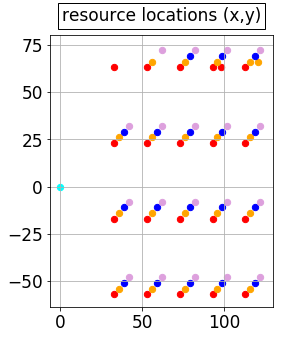

In [61]:
# plot_cords([[rs for key in mrss for rs in mrss[key]]])#plots all
plot_cords([[*(rs for rs in mrss['ctrl'])],[*(rs for rs in mrss['hh_ld'])],
                      [*(rs for rs in mrss['hh_pv'])],[*(rs for rs in mrss['hh_es'])],
                      [*(rs for rs in mrss['hh_inv'])],
                     ],colors=['cyan','red','orange','blue','plum'])

In [62]:
pop_col = {}#LATER move down

In [63]:
J = len(magg['hh'])
pop_col['P_j0toJ_es_ext'] = np.zeros( (J, Resource.K) )#calc. later
pop_col['E_j0toJ_es_soc'] = np.zeros( (J, Resource.K) )
pop_col['E_j0toJ_es_soc_max'] = np.zeros( (J) )
pop_col['P_j0toJ_inv_loss'] = np.zeros( (J, Resource.K) )
pop_col['P_j0toJ_inv_set_normed'] = np.zeros( (J, Resource.K) )
pop_col['P_J_ld'] = np.sum(mdata['hh_ld'][:,0], axis=0).copy()
pop_col['P_J_pv'] = np.sum(mdata['hh_pv'][:,0], axis=0).copy()
pop_col['P_j2_ld'] = get_rss('hh', j=2, ct_rs='ld')[0].view[0].copy()#hh j2
pop_col['P_j2_inv_loss'] = get_rss('hh', j=2, ct_rs='inv')[0].view[1].copy()
pop_col['P_j2_pv'] = get_rss('hh', j=2, ct_rs='pv')[0].view[0].copy()
pop_col['E_J_loss_es_total'] = np.sum(mdata['hh_es'][:,2], axis=0).copy()
pop_col['E_J_loss_es_ch'] = np.where(mdata['hh_es'][:,0] < 0, mdata['hh_es'][:,2], 0).sum(axis=0).copy()
pop_col['E_J_loss_es_dch'] = np.where(mdata['hh_es'][:,0] > 0, mdata['hh_es'][:,2], 0).sum(axis=0).copy()
pop_col['E_J_loss_es_idle'] = np.where(mdata['hh_es'][:,0] == 0, mdata['hh_es'][:,2], 0).sum(axis=0).copy()
pop_col['E_J_loss_inv'] = np.sum(mdata['hh_inv'][:,1,:], axis=0).copy()*Resource.kclock
pop_col['P_J_res'] = get_power_grp('hh', j=None)
pop_col['P_J_res_ctrl'] = mdata['ctrl'][0,0]
pop_col['P_j0toJ_res'] = np.zeros( (J, Resource.K) )#calc. later
pop_col['C_j0toJ_res'] = None#calc. later from pop_col
pop_col['C_k0toK_j0toJ_mmr'] = None
pop_col['SSR_j0toJ'] = np.zeros( (J) )#per j
pop_col['SCR_j0toJ'] = np.zeros( (J) )
pop_col['SDR_k0toK'] = get_params('SDR', ct_grp='hh', j=None)#per k
pop_col['RCR_k0toK'] = get_params('RCR', ct_grp='hh', j=None)#per k
pop_col['SSR'] = get_param('SSR', ct_grp='', j=None)#grid-wide LATER make sense gridwide?
pop_col['SCR'] = get_param('SCR', ct_grp='', j=None)
pop_col['RCR'] = get_param('RCR', ct_grp='', j=None)
pop_col['GUR'] = get_param('GUR', ct_grp='hh', j=None)

for j in range(J):#extract E_j0toJ_res
    pop_col['SSR_j0toJ'][j] = get_param('SSR', ct_grp='hh', j=j)
    pop_col['SCR_j0toJ'][j] = get_param('SCR', ct_grp='hh', j=j)
    pop_col['P_j0toJ_res'][j] = get_power_grp('hh', j=j)
    for rs_inv in get_rss('hh', j=j, ct_rs='inv'):
        pop_col['P_j0toJ_inv_loss'][j] += rs_inv.view[1]
        pop_col['P_j0toJ_inv_set_normed'][j] += rs_inv.view[0] / rs_inv.P_nom_abs
    for rs_es in get_rss('hh', j=j, ct_rs='es'):
        pop_col['P_j0toJ_es_ext'][j] += rs_es.view[0]
        pop_col['E_j0toJ_es_soc'][j] += rs_es.view[3]
        pop_col['E_j0toJ_es_soc_max'][j] += rs_es.E_soc_max

### Power-flow <a name="ddd9nooM"></a>
        OpenDSS for power-flow analysis takes time-series of multipliers 
        to form loadshapes, which are exported from this notebook. 
        !odss entry point for learning: 'Help Links.docx' in svn_repo/Docs from sourceforge

In [64]:
# prepare loadshape multiplier on basekW = 1 of load element
shapes_idv = pop_idv['P_j0toJ_res'] * -1e-3
shapes_col = pop_col['P_j0toJ_res'] * -1e-3
#export_path for profiles later imported by opendss
path = './opendss_scripts/LVTestCase/jupyter_profiles/'
for i in range(20):
    fpath = os.path.join(path, f'profile_idv_{i+1}.txt')
    np.savetxt(fpath, shapes_idv[i], delimiter=', ', fmt=' %.3f')
    fpath = os.path.join(path, f'profile_col_{i+1}.txt')
    np.savetxt(fpath, shapes_col[i], delimiter=', ', fmt=' %.3f')

    OpenDSS is currently driven from standard gui and the script Master.dss is the
    entry point to explore the project and run the simulation.
    about the feeder is base on
        [1] European_LV_Test_Feeder_v2/IEEE European LV Test Feeder - Draft.pdf
            http://sites.ieee.org/pes-testfeeders/resources/ see 2015 Test Feeder Cases
        
    Now import odss results

In [65]:
#import opendss results and attach to pop_idv and pop_col
# path = '/home/user/Downloads/marbeit/svni7/*/opendss_scripts/LVTestCase/'
path = './opendss_scripts/LVTestCase/'
tmp0 = pd.read_csv(os.path.join(path, 'di_idv/DI_yr_0/EnergyMeterTotals_1.CSV'), sep=',', skipinitialspace=True)
tmp1 = pd.read_csv(os.path.join(path, 'di_idv/DI_yr_0/m1_1.CSV'), sep=',', skipinitialspace=True)
tmp2 = pd.read_csv(os.path.join(path, 'di_col/DI_yr_0/EnergyMeterTotals_1.CSV'), sep=',', skipinitialspace=True)
tmp3 = pd.read_csv(os.path.join(path, 'di_col/DI_yr_0/m1_1.CSV'), sep=',', skipinitialspace=True)
tmp4 = pd.read_csv(os.path.join(path, 'di_idv_Mon_line3_vi_1.csv'), sep=',', skipinitialspace=True)
tmp5 = pd.read_csv(os.path.join(path, 'di_idv_Mon_line3_pq_1.csv'), sep=',', skipinitialspace=True)

pop_idv['dss_totals'] = tmp0
pop_col['dss_totals'] = tmp2
pop_idv['E_J_loss_grid'] = to_Ws(tmp1.loc[:,'Zone Losses kWh'].values)*-1/60#are <0
pop_idv['E_dss_zone'] = to_Ws(tmp1.loc[:,['Zone kWh','Zone kvarh']].values.transpose())*1/60
pop_col['E_J_loss_grid'] = to_Ws(tmp3.loc[:,'Zone Losses kWh'].values)*-1/60
pop_col['E_dss_zone'] = to_Ws(tmp3.loc[:,['Zone kWh','Zone kvarh']].values.transpose())*1/60
# FIXED stepsize in di-data is off, https://sourceforge.net/p/electricdss/discussion/beginners/thread/7754c5eca5/#1c3c
pop_idv['df_VI_dss_mon_line3'] = tmp4
pop_idv['df_P_dss_mon_line3'] = tmp5

In [66]:
pop_idv['P_xfmr'] = pop_idv['P_J_res']*-1 + pop_idv['E_J_loss_grid']/Resource.kclock*-1#xfmr counter-flows
pop_col['P_xfmr'] = pop_col['P_J_res']*-1 + pop_col['E_J_loss_grid']/Resource.kclock*-1

In [67]:
# to review AC side see 'dss_review' jpn


### Review results <a name="ood9nooM"></a>
    Plot and compare postprocessed data stored in pop_idv and pop_col

In [68]:
pop_idv['dss_totals_scaled'] = pd.read_csv(os.path.join(path, 'di_idv_scaled/DI_yr_0/EnergyMeterTotals_1.CSV'), sep=',', skipinitialspace=True)

In [69]:
from IPython.core.display import HTML
display(HTML(pop_idv['dss_totals_scaled'].to_html()))
display(HTML(pop_idv['dss_totals'].to_html()))
display(HTML(pop_col['dss_totals'].to_html()))

In [70]:

display(HTML(pop_idv['dss_totals_scaled'].loc[:,['kWh', 'kvarh', 'Zone kWh', 'Zone kvarh', 'Zone Losses kWh', 'Zone Losses kvarh', 'Line Losses', 'Max kW', 'Max kVA']].to_html()))
display(HTML(pop_idv['dss_totals'].loc[:,['kWh', 'kvarh', 'Zone kWh', 'Zone kvarh', 'Zone Losses kWh', 'Zone Losses kvarh', 'Line Losses', 'Max kW', 'Max kVA']].to_html()))
display(HTML(pop_col['dss_totals'].loc[:,['kWh', 'kvarh', 'Zone kWh', 'Zone kvarh', 'Zone Losses kWh', 'Zone Losses kvarh', 'Line Losses', 'Max kW', 'Max kVA']].to_html()))
# display(HTML(pop_col['dss_totals'].to_html()))

In [71]:
tmp0 = to_kWh(pop_idv['P_j0toJ_res'][:].sum() * 60)
tmp1 = to_kWh(pop_idv['E_dss_zone'][0,:]).sum() 
tmp2 = pop_idv['dss_totals']
display((tmp0, tmp1, tmp0 + tmp1))#do hhs consume what vscource delivers, loss excluded, nominal 1
display(to_kWh(pop_idv['E_J_loss_grid'].sum()) / pop_idv['dss_totals'].loc[0,'Zone Losses kWh'])# loss di vs totals, nominal 1
print(f"loss {tmp2.loc[0,'Zone Losses kWh']} of {tmp2.loc[0,'Zone kWh']} kWh consumed by hh")
tmp2 = pop_col['dss_totals']
print(f"loss {tmp2.loc[0,'Zone Losses kWh']} of {tmp2.loc[0,'Zone kWh']} kWh consumed by hh")      

(-2216.7456328314606, 2216.7462794913918, 0.0006466599311352184)

-0.9999999999999954

loss 4.460250912292611 of 2216.7462794914 kWh consumed by hh
loss 7.26457114747468 of 1919.07773349983 kWh consumed by hh


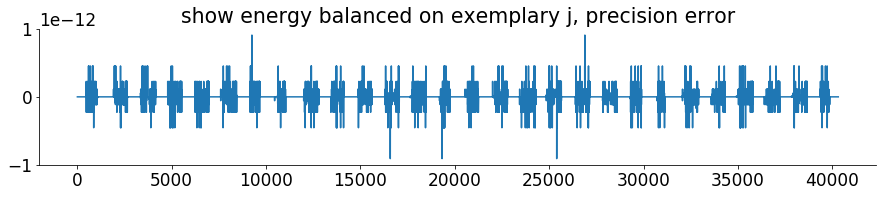

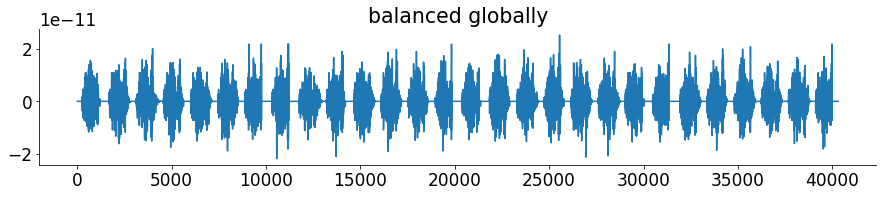

In [72]:
tmp0 = get_power_grp('hh', j=2,ct_rs='ld') + get_power_grp('hh', j=2,ct_rs='pv') + get_power_grp('hh', j=2,ct_rs='inv') + get_power_grp('hh', j=2,ct_rs='es') + get_power_grp('hh', j=2)*-1
plt.plot(tmp0)
plt.title('show energy balanced on exemplary j, precision error')
plt.show()

tmp1 = get_power(ct_rs='ld') + get_power(ct_rs='pv') + get_power(ct_rs='inv') + get_power(ct_rs='es') + get_power()*-1 #_grp j=None
plt.plot(tmp1)
plt.title('balanced globally')
plt.show()

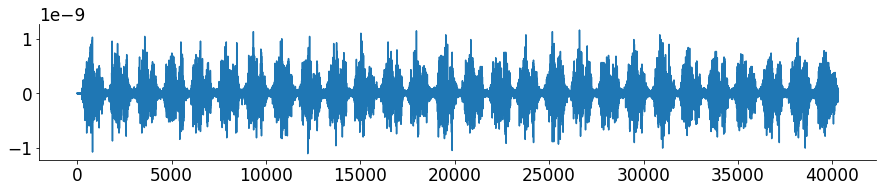

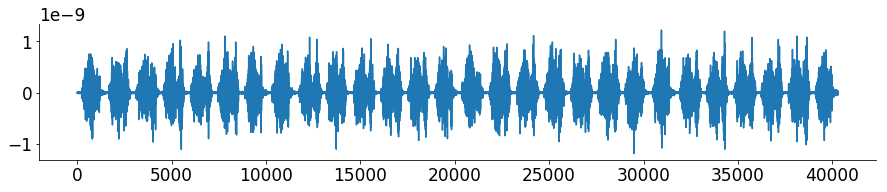

prec. error, energy created/destroyed? idv 5.087883324 col 4.796458057 uWs


In [73]:
tmp0 = pop_idv['E_J_loss_inv'] + pop_idv['E_J_loss_grid'] + (pop_idv['P_J_ld'] + pop_idv['P_J_pv'] + pop_idv['P_xfmr'] + np.sum(pop_idv['P_j0toJ_es_ext'], axis=0)) * Resource.kclock
tmp1 = pop_col['E_J_loss_inv'] + pop_col['E_J_loss_grid'] + (pop_col['P_J_ld'] + pop_col['P_J_pv'] + pop_col['P_xfmr'] + np.sum(pop_col['P_j0toJ_es_ext'], axis=0)) * Resource.kclock
plt.plot(tmp0)
plt.show()
plt.plot(tmp1)
plt.show()
tmp2 = np.absolute(tmp0).sum()
tmp3 = np.absolute(tmp1).sum()
print(f'prec. error, energy created/destroyed? idv {tmp2*1e6:.9f} col {tmp3*1e6:.9f} uWs')

In [74]:
assert np.absolute(pop_idv['P_J_res_ctrl'] + pop_idv['P_J_res']*-1).sum() < 1e-6 #is idv ctrl ok

##### about odss
    circuit and voltage profile, LATER overlay grid ![circuit plot and voltage profile](images/plot_cords_idv.png) 
    the actual circuit/bus/node is talked earlier 
![circuit plot and voltage profile](images/circuit_and_profile.png) 

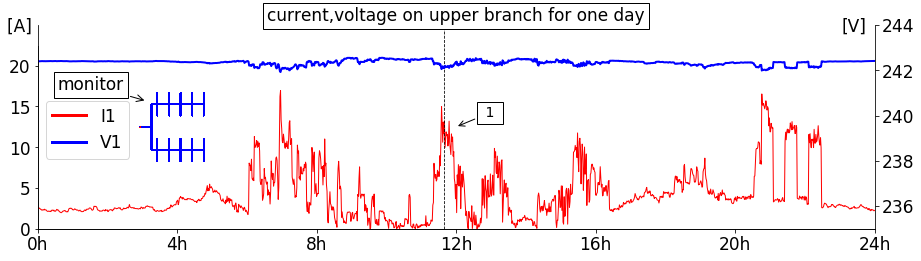

In [75]:
days = 1
tmp0 = pop_idv['df_VI_dss_mon_line3'].loc[0:1440*days, ['V1', 'V2', 'V3']]#LATER merge 1. 2. plot and current below
tmp1 = pop_idv['df_VI_dss_mon_line3'].loc[0:1440*days, ['I1', 'I2', 'I3']]
tmp2 = pop_idv['df_VI_dss_mon_line3'].loc[0:1440*days, ['VAngle1', 'VAngle2', 'VAngle3']]

fig, ax = plt.subplots(1,1, figsize=(15,2.5*1.5))
ax.plot(tmp1.loc[:,'I1'], color='red', lw=1)
ax.set_ylim(0,25)
ax.set_xlim(0,1440)
ax.set_xticks(np.arange(0,1440+1,60*4))
ax.set_xticklabels( [*(f'{i}h' for i in range(0,24+1,4))])

axs_ins = inset_axes(ax, width="30%", height=1., loc=6)#inset grid
import matplotlib.image as mpimg
axs_ins.imshow(mpimg.imread('images/dss_gskel.png'))
axs_ins.set_axis_off()
xy = np.array((0.13,0.86))
axs_ins.annotate('monitor', xy, xytext=xy+[-1.3,0.15], size=17, xycoords='axes fraction', bbox={'facecolor':'white'}, arrowprops={'arrowstyle':'->'})

axt = ax.twinx()
axt.plot(tmp0.loc[:,'V1'], color='blue', lw=2)
axt.set_xlim(0)
axt.set_ylim(235,244)#asdf
axt.spines['right'].set_visible(True)
leg = fig.legend(('I1', 'V1'), bbox_to_anchor=(0.21,0.6), bbox_transform=fig.transFigure, frameon=True, ncol=1, borderaxespad=0.)
plt.setp(leg.get_lines(), linewidth=3)
xy = np.array((0.5,0.5))
ax.annotate(' 1 ', xy, xytext=xy+[0.03,0.05], size=14, xycoords='axes fraction', bbox={'facecolor':'white'}, arrowprops={'arrowstyle':'->'})
ax.text(0,0.95,'[A] ', va='bottom', ha='right', transform=ax.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':10})
axt.text(0.99,0.95,'[V]', va='bottom', ha='right', transform=axt.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':5})
ax.axvline(700, linestyle='--', lw=0.8, color='k') 

ax.text(0.5,1,'current,voltage on upper branch for one day', va='bottom', ha='center', transform=ax.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
plt.show()

In [76]:
to_kWh(pop_idv['E_J_loss_grid'][699]), to_kWh(pop_col['E_J_loss_grid'][699])

(-0.00046508600394021, -0.000280134720900125)

In [77]:
display(pop_idv['df_VI_dss_mon_line3'].loc[699])
display(pop_idv['df_P_dss_mon_line3'].loc[699])
#relate and calc 1-2-3 paths from p300, show Yprim calc from "dss_review", maybe add terminald element for power

hour         11.0000
t(sec)     2400.0000
V1          242.1470
VAngle1     -30.0176
V2          242.1470
VAngle2    -150.0180
V3          242.1470
VAngle3      89.9824
I1           11.6496
IAngle1     -48.1886
I2           11.6496
IAngle2    -168.1890
I3           11.6496
IAngle3      71.8114
Name: 699, dtype: float64

hour          11.00000
t(sec)      2400.00000
S1 (kVA)       2.82093
Ang1          18.17100
S2 (kVA)       2.82093
Ang2          18.17100
S3 (kVA)       2.82093
Ang3          18.17100
Name: 699, dtype: float64

In [78]:


# now in general again:

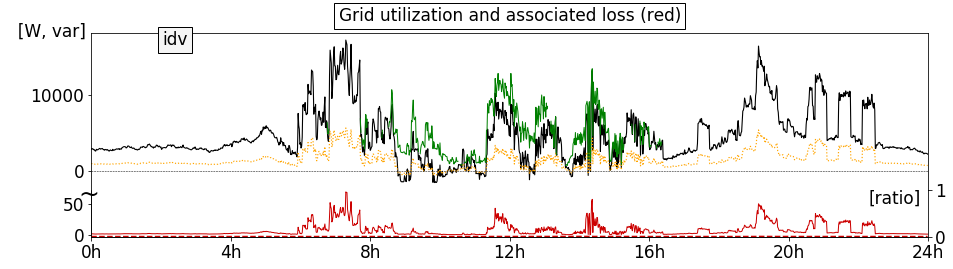

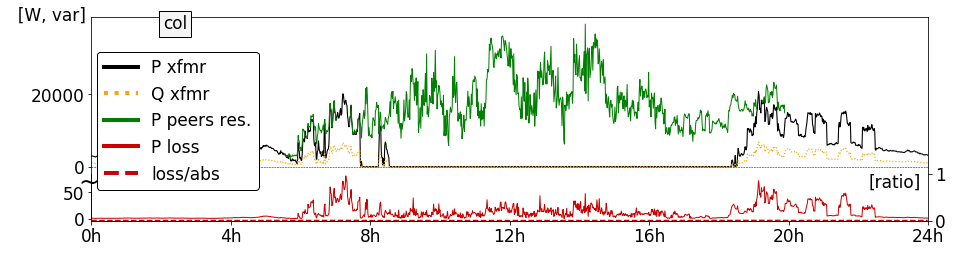

In [79]:
for s in range(2):
    if s == 0:
        tmp0 = pop_idv['E_dss_zone'][0,:1440]/Resource.kclock #to APPENDIX
        tmp1 = pop_idv['E_dss_zone'][1,:1440]/Resource.kclock
        tmp2 = np.absolute(pop_idv['P_j0toJ_res'][:,:1440]).sum(axis=0)
        tmp2_ = np.where(np.absolute(tmp2-tmp0)>100, tmp2, 0)#prevent overpaint, green line if diff 100W exceeded
        tmp2__ = np.ma.masked_where(tmp2_ == 0, tmp2)
        tmp3 = pop_idv['E_J_loss_grid'][:1440]/Resource.kclock*-1
    else:
        tmp0 = pop_col['E_dss_zone'][0,:1440]/Resource.kclock
        tmp1 = pop_col['E_dss_zone'][1,:1440]/Resource.kclock
        tmp2 = np.absolute(pop_col['P_j0toJ_res'][:,:1440]).sum(axis=0)
        tmp2_ = np.where(np.absolute(tmp2-tmp0)>100, tmp2, 0)
        tmp2__ = np.ma.masked_where(tmp2_ == 0, tmp2)
        tmp3 = pop_col['E_J_loss_grid'][:1440]/Resource.kclock*-1

    fig, axs = plt.subplots(2,1, figsize=(15,2.5*1.5), gridspec_kw = {'width_ratios':[1], 'height_ratios':[1,0.3]}) 
    axs[0].plot(tmp0, ls='-', color='k', lw=1.1)
    axs[0].plot(tmp1, ls=':', color='orange', lw=1.2)
    axs[0].plot(tmp2__, ls='-', color='g', lw=1)
    axs[0].set_xticks([])
    axs[0].text(-0.006,0.95,'  [W, var]', va='bottom', ha='right', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':4})
    axs[0].set_xlim(0,1440)
    
    axs[1].plot(tmp3, ls='-', color=mcolor['loss']*0.8, lw=1)
    axs[1].text(-21.5,55, r'~', fontsize=25)
    axs[1].set_xticks([x for x in range(0,1440+1,60*4)])
    axs[1].set_xticklabels( [*(f'{i}h' for i in range(0,24+1,4))])
    axs[1].set_xlim(0,1440)
    
    ax1t = axs[1].twinx()
    ax1t.plot(tmp3 / tmp2+0.005, color=mcolor['loss']*0.8, ls='--', lw=1.5)
    ax1t.set_ylim(0,1)
    ax1t.set_yticks([0,1])
    ax1t.spines['right'].set_visible(True)
    ax1t.set_ylabel('[ratio]', rotation=0, fontsize=17)
    ax1t.yaxis.set_label_coords(0.96,1.0)
    ax1t.set_xlim(0,1440)

    if s == 0:
        axs[0].text(0.5,1.05,'Grid utilization and associated loss (red)', va='bottom', ha='center', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
        axs[0].text(0.1,0.9,'idv', va='bottom', ha='center', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
    else:
        leg = fig.legend(('P xfmr', 'Q xfmr', 'P peers res.', 'P loss', 'loss/abs'), bbox_to_anchor=(0.28,0.75), bbox_transform=fig.transFigure, frameon=True, ncol=1, borderaxespad=0., framealpha=1, edgecolor='k')
        axs[0].text(0.1,0.9,'col', va='bottom', ha='center', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
    axs[0].axhline(0, ls='--', color='k', lw=0.5)
    plt.setp(leg.get_lines(), linewidth=4)
    plt.subplots_adjust(wspace=0., hspace=0.0, right=None)#left=None, bottom=None, right=None, top=None, 
    axs[0].spines['top'].set_visible(True)
    axs[0].spines['right'].set_visible(True)
    plt.show()

In [80]:
display(np.sort(pop_idv['E_dss_zone'][0,:1440]/Resource.kclock))
display(np.sort(pop_col['E_dss_zone'][0,:1440]/Resource.kclock))
display(np.sort(pop_idv['E_dss_zone'][0,:]/Resource.kclock))
display(np.sort(pop_col['E_dss_zone'][0,:]/Resource.kclock))
display('about peers res:')
# display(np.sort(pop_idv['P_j0toJ_res'][:,:1440].sum(axis=0)))#rough same xfmr
# display(np.sort(pop_col['P_j0toJ_res'][:,:1440].sum(axis=0)))
display(np.sort(np.absolute(pop_idv['P_j0toJ_res'][:,:1440]).sum(axis=0)))
display(np.sort(np.absolute(pop_col['P_j0toJ_res'][:,:1440]).sum(axis=0)))
display('when peers res peak:')
tmp0 = np.absolute(pop_idv['P_j0toJ_res']).reshape(20*28,1440).sum(axis=0)
tmp1 = np.absolute(pop_col['P_j0toJ_res']).reshape(20*28,1440).sum(axis=0)
tmp0.argmax(), tmp0[tmp0.argmax()], tmp1.argmax(), tmp1[tmp1.argmax()], pop_idv['P_J_res'].max()#when peak
#     446/60 = 7.25am
#     1161/60 = 19.35pm
# red: loss varys with grid utilisation yet dep. on xfmr or p2p flow: peek green 2x yet less loss, pics weigh_loss:
# red--: neglectible <1%   low on %

array([-1532.00023332, -1517.00002484, -1503.00105829, ...,
       16749.93064154, 16978.0025878 , 17311.79077648])

array([-4.00728005e+00, -3.99729760e+00, -3.00870143e+00, ...,
        1.97320159e+04,  2.01499673e+04,  2.07309270e+04])

array([-14678.00024619, -14565.0000811 , -14497.99948437, ...,
        27413.91596057,  28022.93303675,  28595.88622739])

array([-15767.9987885 , -15542.99982811, -15443.99915838, ...,
        34028.12714425,  35376.64112334,  37074.13793362])

'about peers res:'

array([  739.76518437,   756.38246351,   766.11033691, ...,
       16749.84057955, 16979.72256948, 17311.4581718 ])

array([ 2452.86875218,  2503.03366358,  2525.58408993, ...,
       36125.14685582, 36725.30834979, 39442.96759875])

'when peers res peak:'

(453, 313991.2901511998, 1161, 617028.4724633124, 14677.632432776998)

    circuit weighted power/loss for idv and col at k699 #LATER mark 2-3 line in rightest
    look at linecode examplary "0.01% P_loss for 20m of linecode 4c_.06 on 0.606 kVA" from dump debug
        TechNote CableModelling.pdf
        OpenDSSManual.pdf
![circuit power/loss](images/dss_idv_col_k699_power_and_loss.png)

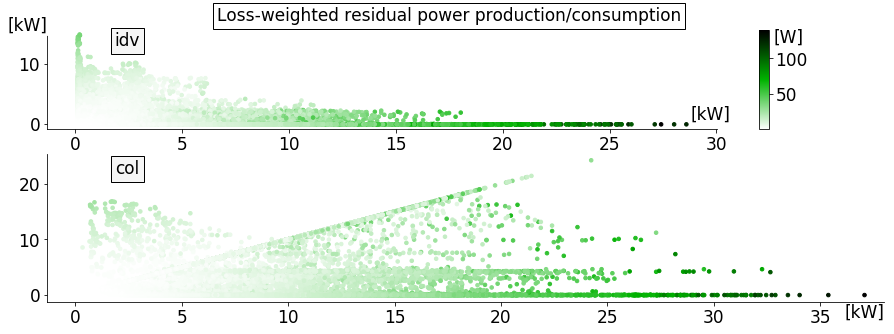

In [81]:
tmp0 = pop_idv['E_J_loss_grid'] /Resource.kclock *-1
tmp7 = pop_col['E_J_loss_grid'] /Resource.kclock *-1
tmp1 = pop_idv['E_dss_zone'][0,:] /Resource.kclock

tmp2 = pop_idv['P_j0toJ_res']
tmp3 = np.where(tmp2<0, tmp2, 0).sum(axis=0)*-1
tmp4 = np.where(tmp2>0, tmp2, 0).sum(axis=0)
tmp8 = pop_col['P_j0toJ_res']
tmp9 = np.where(tmp8<0, tmp8, 0).sum(axis=0)*-1
tmp10 = np.where(tmp8>0, tmp8, 0).sum(axis=0)


fig = plt.figure(figsize=(15,2.5*2))
gs = gridspec.GridSpec(2, 1, width_ratios=[1], height_ratios=[1, 1.5])
# ax = plt.subplot(gs[:,0])

# ax.scatter(tmp1,tmp0, marker='.', s=1, c='g')
# # ax.scatter(tmp1,tmp7, marker='.', s=1, c='green')#no info
# # ax.set_ylim(-0.0002, 0.0025)
# ax.set_yticklabels(ax.get_yticks()[:-1])
# leg = fig.legend((['P_active_loss']), bbox_to_anchor=(0.28,0.88), bbox_transform=fig.transFigure, frameon=True, ncol=1, borderaxespad=0., markerscale=20)
# plt.setp(leg.get_lines(), linewidth=3)

ax1 = plt.subplot(gs[0, 0])
sc = ax1.scatter(tmp3, tmp4, s=50, marker='.', c=tmp0, cmap='w_g_b')
fig.colorbar(sc, aspect=10)#almost same for both  
# ax1.axhline(10000, ls='--', color='k', lw=1)
ax1.set_xticklabels(np.array(ax1.get_xticks()/1000, dtype=int))
ax1.set_yticklabels(np.array(ax1.get_yticks()/1000, dtype=int))

ax2 = plt.subplot(gs[1, 0])
sc2 = ax2.scatter(tmp9, tmp10, s=50, marker='.', c=tmp7, cmap='w_g_b')
ax2.set_xlim(ax1.get_xlim()[0], 38000)

# ax2.axhline(10000, ls='--', color='k', lw=1)
ax2.set_xticklabels(np.array(ax2.get_xticks()/1000, dtype=int))
ax2.set_yticklabels(np.array(ax2.get_yticks()/1000, dtype=int))
# ax.text(-0.0,0.92,'[W,W]', va='bottom', ha='right', transform=ax1.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':10})
# ax.text(0,0.95,'[kW]', va='bottom', ha='right', transform=ax1.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':10})
ax1.text(-0.,0.95,'[kW]', va='bottom', ha='right', transform=ax1.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':0})
ax1.text(1.02,0.05,'[kW]', va='bottom', ha='right', transform=ax1.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':0})
ax2.text(1.25,-1.95,'[kW]', va='bottom', ha='right', transform=ax1.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':0})
ax1.text(1.13,0.83,'[W]', va='bottom', ha='right', transform=ax1.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':0})
ax.text(0.5,1.05,'loss idv on feed-in', va='bottom', ha='center', transform=ax.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
ax1.text(0.6,1.05,'Loss-weighted residual power production/consumption', va='bottom', ha='center', transform=ax1.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
ax1.text(0.12,0.8,'idv', va='bottom', ha='center', transform=ax1.transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
ax2.text(0.12,-0.5,'col', va='bottom', ha='center', transform=ax1.transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
plt.show() 

In [82]:
# about correlation power and loss for active power: 
# (loss significantly varys on load, but low on %)
# left:
# nonlinear eitherway
# right:
#     x:y way SDR=1 shows
#     10 prod line seems to push less loss, also 25 idv is 30 up in col: shorter ways cause 


In [83]:
pop_col['E_J_loss_grid'][700:]/60, pop_col['P_J_res'][700:]

(array([-20.59149121, -14.65161128, -15.66457617, ...,  -2.10328818,
         -2.21025382,  -2.31799233]),
 array([-6.62155473e-05,  1.73113696e-04, -1.04770336e-03, ...,
        -3.61949525e+03, -3.69972946e+03, -3.79058232e+03]))

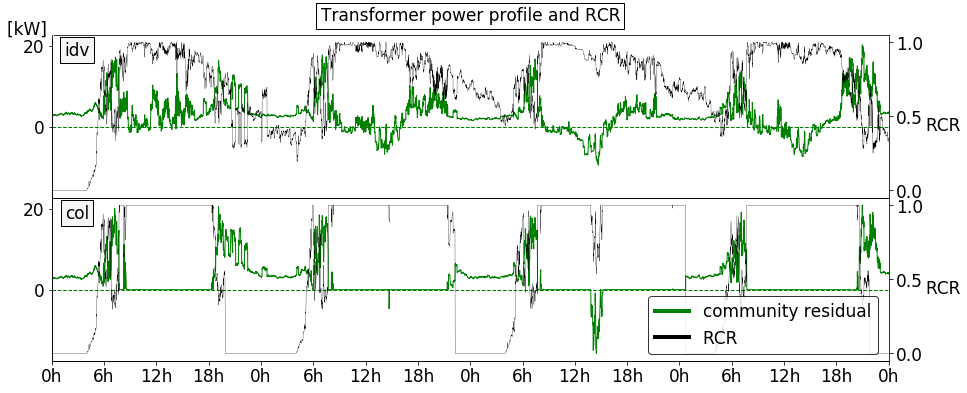

In [84]:
days = 4
tmp0 = np.arange(1440*days)
tmp1 = (pop_idv['E_J_loss_grid']/60*-1 + pop_idv['P_J_res'])[:1440*days]*1e-3 * -1#counter flow, grid loss = 0
tmp2 = (pop_col['E_J_loss_grid']/60*-1 + pop_col['P_J_res'])[:1440*days]*1e-3 * -1

fig, axs = plt.subplots(2,1, figsize=(15,4*1.5), sharey=True)
axs[0].plot(tmp1, color='g', lw=1)
axs[0].set_xlim(0, 4*1440)
axs[0].set_xticks([])
axs[0].set_xticklabels([])
axs0t = axs[0].twinx()
axs0t.plot(pop_idv['RCR_k0toK'][:1440*days], color='k', lw=0.3)
axs0t.set_ylabel('RCR', rotation=0, labelpad=20)
leg = fig.legend((['community residual', 'RCR']), bbox_to_anchor=(0.89,0.275), bbox_transform=fig.transFigure, frameon=True, ncol=1, borderaxespad=0., edgecolor='k')
plt.setp(leg.get_lines(), linewidth=4)

axs[1].plot(tmp2, color='g', lw=1)
axs[1].set_xlim(0, 4*1440)
axs[1].set_xticks([x for x in range(0,1440*days+1,60*6)])
axs[1].set_xticklabels( [*(f'{i%24}h' for i in range(0,24*days+1,6))])
axs1t = axs[1].twinx()
axs1t.plot(pop_col['RCR_k0toK'][:1440*days], color='k', lw=0.3)
axs1t.set_ylabel('RCR', rotation=0, labelpad=20)

axs[0].spines['top'].set_visible(True)
axs[0].spines['right'].set_visible(True)
axs[1].spines['top'].set_visible(True)
axs[1].spines['right'].set_visible(True)
axs[0].set_title('Transformer power profile and RCR', y=1, pad=+10, va="bottom",ha='center', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.001,0.98,'[kW] ', va='bottom', ha='right', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':0})
axs[0].text(0.03,0.85,'idv', va='bottom', ha='center', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[1].text(0.03,0.85,'col', va='bottom', ha='center', transform=axs[1].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].axhline(y=0, linestyle='--', lw=1, color='g') # horizontal lines
axs[1].axhline(y=0, linestyle='--', lw=1, color='g') # horizontal lines
plt.subplots_adjust(wspace=0.022, hspace=0., right=None)#left=None, bottom=None, right=None, top=None, 
plt.show()

In [85]:
# P_J_res used to show control ability, cancels on col and RCR 1, 
#     breakdown inbet:soc full, is xfmr profile excl lineloss; dawn/night:no soc
#     to prev plot: green 30k abs cancels and RCR 1
# if long comm able to self-sustaion SSR=1 during nonpv times -> downsize xfmr ^^
#     xfmr exchanged idv,col:
#    fully balance less swapp: flywheel/2battery, 

display(to_kWh(np.where(pop_idv['P_xfmr']>0, pop_idv['P_xfmr'], 0)*60).sum())
display(to_kWh(np.where(pop_col['P_xfmr']>0, pop_col['P_xfmr'], 0)*60).sum())


2532.225696834739

1972.630993007081

In [86]:
# some totals to wrap up
tmp1 = pop_idv['dss_totals'].loc[0,'Zone Losses kWh']
tmp2 = pop_idv['dss_totals'].loc[0,'kWh']

tmp3 = pop_col['dss_totals'].loc[0,'Zone Losses kWh']
tmp4 = pop_col['dss_totals'].loc[0,'kWh']

print(f'idv loss is {tmp1:.2f}kWh of fed-in {tmp2:.2f}kWh which is {tmp1/tmp2*100:.2f}% in on 28ct/kWh {tmp1*0.28:.2f} Eur cost')#epex
print(f'col loss is {tmp3:.2f}kWh of fed-in {tmp4:.2f}kWh which is {tmp3/tmp4*100:.2f}% in on 28ct/kWh {tmp3*0.28:.2f} Eur cost')

idv loss is 4.46kWh of fed-in 2221.21kWh which is 0.20% in on 28ct/kWh 1.25 Eur cost
col loss is 7.26kWh of fed-in 1926.34kWh which is 0.38% in on 28ct/kWh 2.03 Eur cost


##### About es

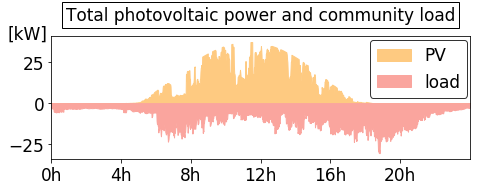

In [87]:
tmp0 = np.arange(1440*1)
tmp1 = pop_idv['P_J_ld'][1440*1:1440*2]/1000#same for both
tmp2 = pop_idv['P_J_pv'][1440*1:1440*2]/1000

fig, axs = plt.subplots(1,1, figsize=(15/2,1.5*1.5), sharey=True, sharex=True)#LATER ticks per day;
axs = [axs]
axs[0].fill_between(tmp0, tmp2, color=mcolor['pv'])
axs[0].fill_between(tmp0, tmp1, color=mcolor['ld'])
leg = fig.legend((['PV', 'load']), bbox_to_anchor=(0.895,0.86), bbox_transform=fig.transFigure, frameon=True, ncol=1, borderaxespad=0., edgecolor='k')
plt.setp(leg.get_lines(), linewidth=3)

axs[0].set_xlim(0,1440)
axs[0].set_xticks([x for x in range(0,1440*1,60*4)])
axs[0].set_xticklabels( [*(f'{i%24}h' for i in range(0,24*1,4))])

axs[0].text(-0.01,0.95,'[kW]', va='bottom', ha='right', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':0})
axs[0].text(0.5,1.1,'Total photovoltaic power and community load', va='bottom', ha='center', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].spines['top'].set_visible(True)
axs[0].spines['right'].set_visible(True)
plt.show()

In [88]:
# same profile on diff loads, stats:
# pop_idv['P_J_pv'].max(),pop_idv['P_J_pv'].argmax(), pop_idv['P_J_ld'].min(),pop_idv['P_J_ld'].argmin()#min and max global load
display(df(pop_idv['P_J_ld']).describe().T)
df(pop_idv['P_J_pv']).describe().T 

count          mean          std           min           25%  \
0  40320.0 -10936.480479  6755.296759 -48262.033995 -15107.915772   

            50%          75%          max  
0 -10130.012778 -5061.518103 -2415.725784

count         mean           std  min  25%       50%         75%  \
0  40320.0  8921.966832  11676.155599  0.0  0.0  1621.109  15825.0925   

         max  
0  37378.404

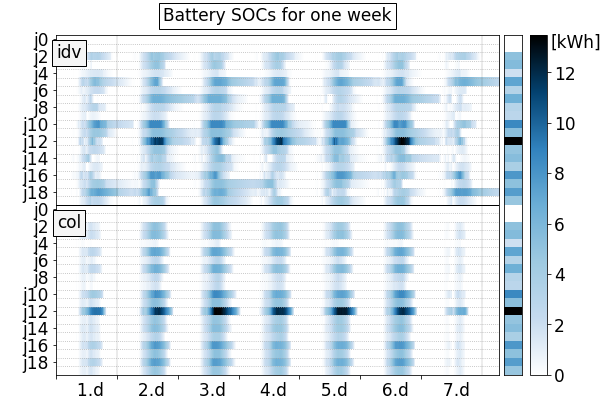

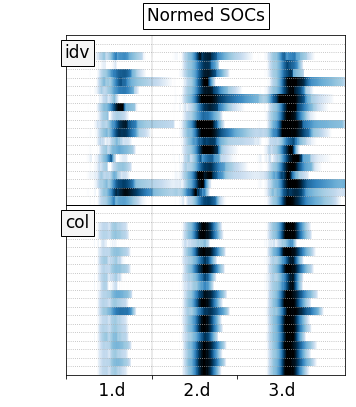

In [89]:
# ABOUT SOC
days = 7
grid = np.zeros( (20*2, 1440*days+400) )
grid[:20] = to_kWh(pop_idv['E_j0toJ_es_soc'][:,:1440*days+400])*-1
grid[20:] = to_kWh(pop_col['E_j0toJ_es_soc'][:,:1440*days+400])*-1
width = 100
grid1 = np.zeros( (20*2, width) )
grid1[:,:width] = np.repeat(np.tile(to_kWh(pop_col['E_j0toJ_es_soc_max']), 2), width).reshape(40,width)*-1

daysn = 3
gridn = np.zeros( (20*2, 1440*daysn+400) )
socs = to_kWh(pop_col['E_j0toJ_es_soc_max'])[2:20,None]#idv col same
gridn[2:20] = grid[2:20, :1440*daysn+400] / socs *-1
gridn[22:] = grid[22:, :1440*daysn+400] / socs *-1

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,2.5*2.5), gridspec_kw = {'width_ratios':[1,0.04], 'height_ratios':[1]})
ims = axs[0].imshow(grid, cmap='es_soc_map', aspect='auto')#GnBu_r
axs[0].spines['top'].set_visible(True)
axs[0].spines['right'].set_visible(True)
axs[0].set_xticks(np.arange(0,1440*7, 1440))
axs[0].set_xticklabels( [*(f'             {i}.d' for i in range(1,8))])#quick offset, else https://stackoverflow.com/a/49449590/4933053
axs[0].set_yticks(np.arange(0,20*2,2))
axs[0].set_yticklabels( [*(f'j{i%20}' for i in range(0,20*2,2))])
axs[0].set_yticks(np.arange(20*2)+0.5,minor=True)
axs[0].grid(which='minor', axis='y', ls=':')
axs[0].tick_params(axis='y', colors='white', which='minor')
axs[0].axvline(1440, ls=':', color='k', lw=0.4)
axs[0].axvline(1440*7, ls=':', color='k', lw=0.4)
axs[0].axhline(20-0.5, ls='-', color='k', lw=1)

ims = axs[1].imshow(grid1, cmap='es_soc_map', aspect='auto')#GnBu_r
axs[1].set_xticks([])
axs[1].set_xticklabels([])
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].spines['top'].set_visible(True)
axs[1].spines['right'].set_visible(True)
plt.subplots_adjust(wspace=0.022, hspace=None, right=None)#left=None, bottom=None, right=None, top=None, 
fig.colorbar(ims, ax=axs, pad=0.014)
axs[0].text(1.23,0.95,'[kWh]', va='bottom', ha='right', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':10})
axs[0].set_title('Battery SOCs for one week', y=1, pad=+10, va="bottom",ha='center', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.03,0.92,'idv', va='bottom', ha='center', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.03,0.42,'col', va='bottom', ha='center', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15/3,2.5*2.5), gridspec_kw = {'width_ratios':[1], 'height_ratios':[1]}) #NEXT to above, normalized
axs = [axs]
ims = axs[0].imshow(gridn, cmap='es_soc_map', aspect='auto')
axs[0].spines['top'].set_visible(True)
axs[0].spines['right'].set_visible(True)
axs[0].set_xticks(np.arange(0,1440*daysn, 1440))
axs[0].set_xticklabels( [*(f'                 {i}.d' for i in range(1,daysn+1))])#quick offset, else https://stackoverflow.com/a/49449590/4933053
axs[0].set_yticks([])
# axs[0].set_yticks(np.arange(0,20*2,2))
# axs[0].set_yticklabels( [*(f'j{i%20}' for i in range(0,20*2,2))])
axs[0].set_yticks(np.arange(20*2)+0.5,minor=True)
axs[0].grid(which='minor', axis='y', ls=':')
axs[0].tick_params(axis='y', colors='white', which='minor')
axs[0].axvline(1440, ls=':', color='k', lw=0.4)
axs[0].axhline(20-0.5, ls='-', color='k', lw=1)
axs[0].set_title('Normed SOCs', y=1, pad=+10, va="bottom",ha='center', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.04,0.92,'idv', va='bottom', ha='center', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.04,0.42,'col', va='bottom', ha='center', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
plt.show()

In [90]:
# all peers good soc size, 0to1 over day, ref later SCR
# full range use, shorter tail


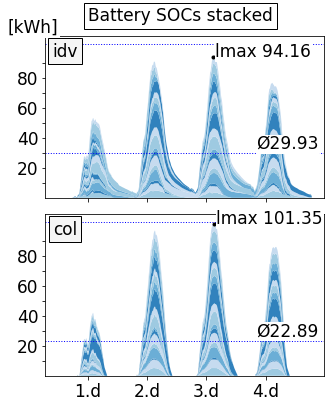

max soc reached 94.16 of E_soc_max 102.69 kWh is 91.69%
max soc reached 101.35 of E_soc_max 102.69 kWh is 98.69%


In [91]:
days = 4
tmp0 = np.arange(1440*days+400)
tmp1 = to_kWh(pop_idv['E_j0toJ_es_soc'][:,:1440*days+400]*-1)
tmp2 = to_kWh(pop_col['E_j0toJ_es_soc'][:,:1440*days+400]*-1)
tmp3 = to_kWh((grid_20peers[2:,9].sum() - grid_20peers[4,9])*-1*Resource.kclock)
tmp4 = np.array([tmp1.sum(axis=0).argmax(),tmp1.sum(axis=0).max(),\
                 tmp2.sum(axis=0).argmax(), tmp2.sum(axis=0).max()])
soc0 = to_kWh(pop_idv['E_j0toJ_es_soc'].sum(axis=0).mean())*-1
soc1 = to_kWh(pop_col['E_j0toJ_es_soc'].sum(axis=0).mean())*-1

fig, axs = plt.subplots(2,1, figsize=(10/2,2.5*2.5), sharey=True, sharex=True)#LATER ticks per day;
colors = mcolor['es_4']#[mcolor['es']*0.3, mcolor['es']*0.6, mcolor['es']*0.9]
axs[0].stackplot(tmp0, tmp1, colors=colors)
axs[0].axhline(y=tmp3, linestyle=':', lw=1, color='blue')
axs[0].annotate(f'lmax {tmp4[1]:.2f}', xy=tmp4[:2], xytext=tmp4[:2]+(40,0), transform = axs[0].transAxes, bbox={'facecolor':'white', 'edgecolor':'white', 'pad':0}, arrowprops={'arrowstyle':'->'})
axs[0].plot(*tmp4[:2], '.', c='k')
axs[1].stackplot(tmp0, tmp2, colors=colors)
axs[1].axhline(y=tmp3, linestyle=':', lw=1, color='blue')
axs[1].annotate(f'lmax {tmp4[3]:.2f}', xy=tmp4[2:], xytext=tmp4[2:]+(40,0), transform = axs[1].transAxes, bbox={'facecolor':'white', 'edgecolor':'white', 'pad':0}, arrowprops={'arrowstyle':'->'})
axs[1].plot(*tmp4[2:], '.', c='k')
for ax in axs:
    ax.set_xticks([i for i in range(int(1440/2), 1440*4+1, 1440)])
    ax.set_xticklabels(['1.d', '2.d', '3.d', '4.d'])
    ax.set_yticks([i for i in range(10,100,10)])
    ax.set_yticklabels(['', '20', '', '40','', '60','',  '80'])
#     ax.tick_params(axis="y",direction="out", pad=-30)
axs[0].axhline(y=soc0, linestyle=':', lw=1, color='blue')
axs[1].axhline(y=soc1, linestyle=':', lw=1, color='blue')
axs[0].text(0.045,1,'[kWh]', va='bottom', ha='right', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':1})
fig.text(0.5,0.905,'Battery SOCs stacked', va='bottom', ha='center', transform=fig.transFigure, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.07,0.85,'idv', va='bottom', ha='center', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[1].text(0.07,0.85,'col', va='bottom', ha='center', transform=axs[1].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.98,0.28,f'Ø{soc0:.2f}', va='bottom', ha='right', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':0})
axs[1].text(0.98,0.22,f'Ø{soc1:.2f}', va='bottom', ha='right', transform=axs[1].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':0})
plt.subplots_adjust(wspace=0.022, hspace=0.1, right=None)#left=None, bottom=None, right=None, top=None, 
axs[0].spines['top'].set_visible(True)
axs[0].spines['right'].set_visible(True)
axs[1].spines['top'].set_visible(True)
axs[1].spines['right'].set_visible(True)
plt.show()

print(f'max soc reached {tmp4[1]:.2f} of E_soc_max {tmp3:.2f} kWh is {tmp4[1]/tmp3*100:.2f}%')
print(f'max soc reached {tmp4[3]:.2f} of E_soc_max {tmp3:.2f} kWh is {tmp4[3]/tmp3*100:.2f}%')#local max

In [92]:
# from top view to stacked side view: course of total soc with peers stacked, collective [kWh], LATER legend colors j0 j19 stacked upwards
# soc_max can only marginally be reduced if same SSR/SCR
# +: the soc range is better utilized since peers swap energy and peers who could no load on peak due to full es can charge: confirmed below table
#          can charge since solver opti-choose results in uniform soc distribu. (ofcourse power-range bounded by soc), no time-model in ch/dch, swap

# shown by excpect 1.day that total charge greater noon, dch greater and earlier depleted, also less loss
#         no grid-charge since 2x inv/rect loss
# about idle loss, almost none but: pct_dch_idle 
print(f'''mean {soc0:.2f} and {soc1:.2f}kWh idv and col in es
this is {(1-soc1/soc0)*100:.2f}% less soc held mean
print(f'this is {(soc0-soc1)*0.05:.2f} kWh less loss on pct_dch_idle {5.:.3}%/mo''')

# 28days    max soc reached 95.92 of E_soc_max 102.69 kWh is 93.40%
#           max soc reached 102.10 of E_soc_max 102.69 kWh is 99.42%, better util, less hold, rather random/uniform, no causal by solver

mean 29.93 and 22.89kWh idv and col in es
this is 23.52% less soc held mean
print(f'this is 0.35 kWh less loss on pct_dch_idle 5.0%/mo


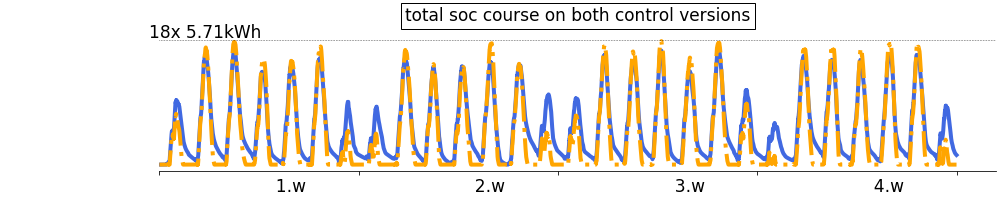

1     2     3     4     5     6     7     8     9     10     11  \
soc_idv  4.61  4.04  1.38  5.49  2.39  5.76  1.97  1.67  8.59  4.70   9.88   
soc_col  4.43  5.21  0.64  6.61  2.01  5.57  1.85  1.32  6.61  4.67   8.81   
soc_max  5.17  5.67  1.88  7.17  3.21  6.57  3.16  2.83  8.59  5.34  13.48   

           12    13    14    15    16    17    18  
soc_idv  3.84  3.60  2.50  7.89  4.91  6.59  2.93  
soc_col  4.07  4.69  2.41  6.67  4.38  6.81  3.98  
soc_max  4.91  5.47  3.81  7.89  5.21  7.58  4.74

In [93]:
# tmp0 = pop_idv['P_j0toJ_es_ext'][2:, 2242] 
# tmp1 = pop_col['P_j0toJ_es_ext'][2:, 2242]
tmp2 = pop_idv['E_j0toJ_es_soc'][2:, 2242]*-1
tmp3 = pop_col['E_j0toJ_es_soc'][2:, 2242]*-1
tmp4 = pop_col['E_j0toJ_es_soc_max'][2:]*-1
tmp8 = pop_idv['E_j0toJ_es_soc'].sum(axis=0)*-1
tmp9 = pop_col['E_j0toJ_es_soc'].sum(axis=0)*-1


fig, axs = plt.subplots(1,1, figsize=(15,2.5*1))
axs = [axs]
axs[0].plot(tmp8, lw=4, ls='-', color='royalblue')# why break in, we days in ld profile? LATER or ask
axs[0].plot(tmp9, lw=4, ls='-.', color='orange')
axs[0].set_xticks(np.arange(0,1440*28+120, 1440*7))
axs[0].set_xticklabels( [*(f'                                                  {i}.w ' for i in range(1,5))])
axs[0].set_yticks([])
axs[0].set_ylabel(f'18x {to_kWh(tmp4.sum())/18:.2f}kWh', rotation=0, fontsize=17)
axs[0].yaxis.set_label_coords(0.055,0.95)
axs[0].axhline(y=tmp4.sum(), lw=0.6, ls=':', color='k', xmin=0)
axs[0].set_xlim(0)#LATER set for all
axs[0].spines['left'].set_visible(False)
axs[0].set_title('total soc course on both control versions', y=1, pad=+10, va="bottom",ha='center', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
plt.show()

tmp5 = to_kWh(np.vstack((tmp2, tmp3, tmp4)))
pd.DataFrame(tmp5, index=['soc_idv', 'soc_col', 'soc_max'], columns=[i for i in range(1,19)]).round(2)

In [94]:
# conf: idv full #9,15 at max, add but with lower prec.
#     but not on col: so can charge util better range

# about charge/dch power how soc came to be:

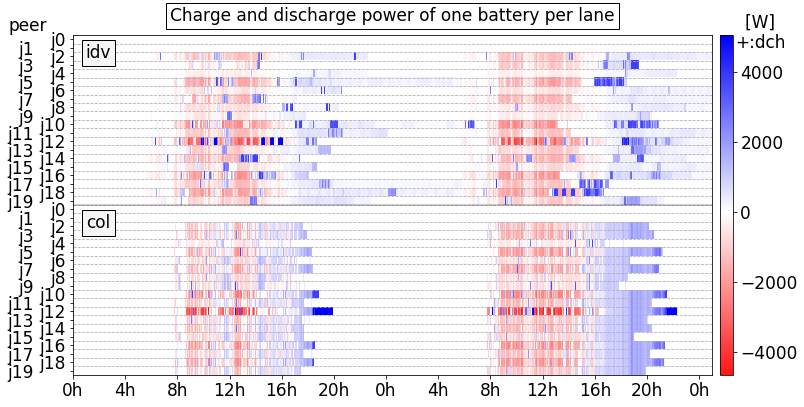

In [95]:
grid = np.zeros( (20*2, 1440*2+60) )
grid[2:20] = pop_idv['P_j0toJ_es_ext'][2:,:1440*2+60]
grid[22:40] = pop_col['P_j0toJ_es_ext'][2:,:1440*2+60]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15/1.1,2.5*2.5))
axs = [axs]
norm = MidpointNormalize(vmin=grid.min(), vmax=grid.max(), midpoint=0)
ims = axs[0].imshow(grid, cmap='es_soc_map_sym', norm=norm, aspect='auto')#GnBu_r
axs[0].set_yticks(np.arange(20*2))

axs[0].set_yticklabels([f'j{i%20}' if i%2==0 else f'j{i%20}      ' for i in range(0,20*2)], ha='right', fontsize=17)
axs[0].set_yticks(np.arange(20*2)+0.5,minor=True)
axs[0].grid(which='minor', axis='y', ls='--')
axs[0].tick_params(axis='y', colors='white', which='minor')
axs[0].set_xticks([x for x in range(0,1440*2+1,60*4)])
axs[0].set_xticklabels( [*(f'{i%24}h' for i in range(0,24*2+1,4))])
# axs[0].axvline(1000, ls='--', color='k', lw=0.4)
axs[0].axhline(20-0.5, ls='-', color='k', lw=0.4)
cbar = fig.colorbar(ims, aspect=25, pad=+0.01) 
axs[0].spines['top'].set_visible(True)
axs[0].spines['right'].set_visible(True)
axs[0].text(-0.04,1,'peer', va='bottom', ha='right', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':0})
axs[0].text(1.115,0.95,'[W]  \n+:dch', va='bottom', ha='right', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':10})
axs[0].set_title('Charge and discharge power of one battery per lane', y=1, pad=+10, va="bottom",ha='center', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.04,0.92,'idv', va='bottom', ha='center', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.04,0.42,'col', va='bottom', ha='center', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
plt.show()

In [96]:
# battery ch/dch power per peer, not normed: each hh diff size
display(df(pop_idv['P_j0toJ_es_ext'].flatten()).describe().T)
#     j12 biggest es pch/soc wise lasts longest col, pctl 50 0.0
# pattern:
#     01 no es, ch later, sundown blue, col dch ends earlier all socs empty sec day v idv tail, 
#     swap ch/dch increases: fine mosaic, 
# meta:
for tmp0 in [pop_idv['P_j0toJ_es_ext'], pop_col['P_j0toJ_es_ext']]:
    tmp1 = to_kWh(np.absolute(tmp0)[np.absolute(tmp0)<100].sum() * Resource.kclock)
    tmp3 = to_kWh(tmp0[tmp0>0].sum() * Resource.kclock)#dch
    tmp4 = to_kWh(tmp0[tmp0<0].sum() * Resource.kclock)#ch
    tmp2 = tmp3 + tmp4*-1
    print(f'dch/charged below 100W is {tmp1:.2f}kWh which is {tmp1/tmp2*100:.2f}% of total {tmp2:.2f}kWh of which ch:{tmp4:.2f} dch:{tmp3:.2f}kWh')


count       mean         std          min        25%  50%         75%  \
0  806400.0 -10.971654  792.525598 -4428.160261 -66.585761  0.0  152.516644   

           max  
0  5042.999995

dch/charged below 100W is 38.53kWh which is 0.71% of total 5434.95kWh of which ch:-2791.20 dch:2643.74kWh
dch/charged below 100W is 8.98kWh which is 0.16% of total 5773.55kWh of which ch:-2960.82 dch:2812.73kWh


#### About solver combi

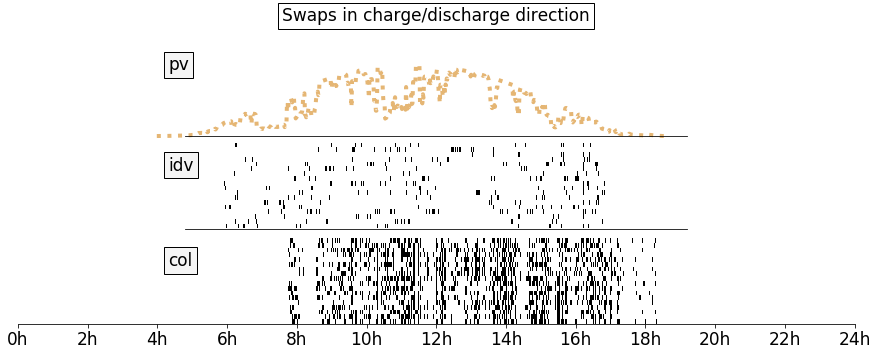

idv batteries swapped 580 times transfering 0.295kWh per swap;
col batteries swapped 2765 times transfering 0.054kWh per swap
col/idv ratio 4.77 energy ratio 0.18


In [97]:
tmp1 = np.sign(pop_idv['P_j0toJ_es_ext'][:,:1440])
tmp2 = np.logical_and(tmp1[:,1:]+tmp1[:,:-1]==0, tmp1[:,1:]!=0)
tmp1_col = np.sign(pop_col['P_j0toJ_es_ext'][:,:1440])
tmp2_col = np.logical_and(tmp1_col[:,1:]+tmp1_col[:,:-1]==0, tmp1_col[:,1:]!=0)#exclude non flips, eg 1001
tmp3 = pop_idv['P_J_pv'][:1440]
tmp4 = np.ma.masked_where(tmp3 == 0, tmp3)

grid = np.zeros( (20*2, 1440-1) )
grid[:20] = tmp2
grid[20:] = tmp2_col
grid_ = grid[:,60*0:1100]
tmp4_ = tmp4[60*0:]*-0.4e-3

fig, axs = plt.subplots(1,1, figsize=(15,2.5*2))
axs = [axs]
ims = axs[0].imshow(grid_, cmap='Greys', aspect='auto')#GnBu_r
axs[0].plot(tmp4_, ls=':', color=mcolor['pv']*0.9, lw=4)
axs[0].axhline(20-0.5, ls='-', color='k', lw=0.8, xmin=0.2, xmax=0.8)
axs[0].axhline(0, ls='-', color='k', lw=0.8, xmin=0.2, xmax=0.8)
axs[0].set_xticks(np.arange(0,1441, 120))
axs[0].set_xticklabels( [*(f'{i}h' for i in range(0,25,2))])
axs[0].set_yticks([])
axs[0].set_yticklabels([])
axs[0].spines['left'].set_visible(False)
axs[0].text(0.5,1.1,'Swaps in charge/discharge direction', va='bottom', ha='center', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.18,0.92,'pv', va='bottom', ha='left', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.18,0.55,'idv', va='bottom', ha='left', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.18,0.2,'col', va='bottom', ha='left', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
plt.show()# https://www.timeanddate.com/sun/germany/berlin?month=8 sundown

tmp5 = to_kWh(np.absolute(pop_idv['P_j0toJ_es_ext'][:,:1440]).sum() * Resource.kclock)
tmp6 = np.sum(tmp2)
tmp5_col = to_kWh(np.absolute(pop_col['P_j0toJ_es_ext'][:,:1440]).sum() * Resource.kclock)
tmp6_col = np.sum(tmp2_col)
print(f'''idv batteries swapped {tmp6} times transfering {tmp5/tmp6:.3f}kWh per swap;
col batteries swapped {tmp6_col} times transfering {tmp5_col/tmp6_col:.3f}kWh per swap
col/idv ratio {tmp6_col/tmp6:.2f} energy ratio {(tmp5_col/tmp6_col / (tmp5/tmp6))**1:.2f}''')

In [98]:
# battery cycles per peer [kWh] ^^, shifted backwards on col since each es sees all loads:
#    later start since feed others, idv earlier end in dch or 0 only since no extern load while in col. eventl. supplied by others making them charge last bit of pv -> swap
# not modeled in the solver objective

# now zoom in on j12:

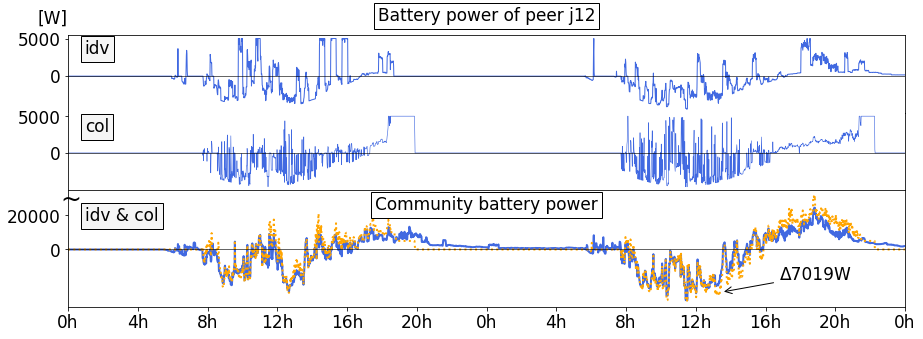

In [99]:
days = 2
tmp0 = pop_idv['P_j0toJ_es_ext'][12,:1440*days].transpose()
tmp1 = pop_col['P_j0toJ_es_ext'][12,:1440*days].transpose()
tmp2 = pop_idv['P_j0toJ_es_ext'].sum(axis=0)[:1440*days]
tmp3 = pop_col['P_j0toJ_es_ext'].sum(axis=0)[:1440*days]

fig, axs = plt.subplots(3,1, figsize=(15,2.5*2), gridspec_kw = {'width_ratios':[1], 'height_ratios':[1,1,1.5]}) 
axs[0].plot(tmp0, lw=1, ls='-', color='royalblue')
axs[0].set_xticks([])
axs[0].set_yticks([0,5000])
axs[0].spines['top'].set_visible(True)
axs[0].spines['right'].set_visible(True)
axs[1].spines['right'].set_visible(True)
axs[2].spines['right'].set_visible(True)

axs[1].plot(tmp1, lw=0.6, ls='-', color='royalblue')
axs[1].set_yticks([0,5000])
axs[1].set_xticks([])
axs[1].spines['bottom'].set_visible(False)

axs[2].plot(tmp2, lw=2, ls='-', color='royalblue')
axs[2].plot(tmp3, lw=2, ls=':', color='orange')
axs[2].set_yticks([0,20000])
axs[2].text(-28,25000, r'~', fontsize=25)
# axs[2].set_xticks(np.arange(0,1440*days+120, 60*4))
# axs[2].set_xticklabels( [*(f'{i}h' for i in range(0,24*days+1,4))])
for ax in axs:
    ax.set_xlim(0,1440*2)
axs[2].set_xticks([x for x in range(0,1440*2+1,60*4)])
axs[2].set_xticklabels( [*(f'{i%24}h' for i in range(0,24*2+1,4))])
axs[2].annotate(f'Δ{(tmp2-tmp3)[2242]:.0f}W', xy=[2250,-25000], xytext=[2450,-18000], transform = axs[2].transAxes, bbox={'facecolor':'white', 'edgecolor':'white'}, arrowprops={'arrowstyle':'->'})
axs[0].text(0,1.1,'[W]', va='bottom', ha='right', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':0})
axs[0].set_title('Battery power of peer j12', y=1, pad=+10, va="bottom",ha='center', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[2].text(0.5,0.8,'Community battery power', va='bottom', ha='center', transform=axs[2].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.02,0.7,'idv', va='bottom', ha='left', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[1].text(0.02,0.7,'col', va='bottom', ha='left', transform=axs[1].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[2].text(0.02,0.7,'idv & col', va='bottom', ha='left', transform=axs[2].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
plt.subplots_adjust(wspace=0.0, hspace=0.)
# leg = fig.legend((['P_j12_es_idv', 'P_j12_es_col', 'P_J_es_idv', 'P_J_es_col']), bbox_to_anchor=(1.042,0.88), bbox_transform=fig.transFigure, frameon=True, ncol=1, borderaxespad=0., edgecolor='k')
plt.setp(leg.get_lines(), linewidth=3)    
axs[0].axhline(y=0, lw=0.6, ls='-', color='k', xmin=0)
axs[1].axhline(y=0, lw=0.6, ls='-', color='k')
axs[2].axhline(y=0, lw=0.6, ls='-', color='k')
axs[2].spines['top'].set_visible(True)
plt.show()

In [100]:
# beside more swaps for j12 (biggest es), higher dch twoards end of day to feed comm.
# end is marked by instant drop when es empty
# except first day, the residual es ch more and dch more, making soc peaks higher and range shorter
#     explained: ch none since no chfgrid so es full,  and dch to feed peers
#                 solver makes 'random' selection results in uniform distribution

#great diff at 14h 2.d charge more ->used to zoom into solver

''

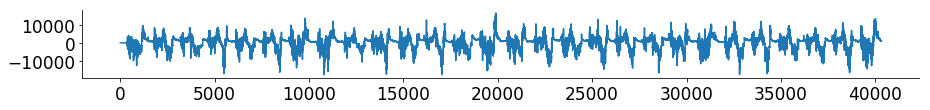

In [101]:
tmp6 = pop_idv['P_j0toJ_es_ext'].sum(axis=0)
tmp7 = pop_col['P_j0toJ_es_ext'].sum(axis=0)
fig, axs = plt.subplots(1,1, figsize=(15,2.5*0.5))
plt.plot(tmp6-tmp7) #idv v col: + charge more, - dch more, inbetween 10kW charge diff, EXCLUDED but in text
''

In [102]:


# (2242, '/tmp/tmpn0s24dvcgk_model8037', 2, 0, 1) bpopt with loss solved x iters LATER talk gekko model?  
#  Adjusting variables to interior region of bounds until conv
#      Iter    Objective  Convergence
#         0  1.95795E+05  1.84892E+05
#        48  8.08373E+02  1.36016E-07
#     Successful solution
# might table 2242: model.apm, .out, .results.csv, model.csv
#  also see -> def build_solve_nlp

In [103]:
pop_col['SDR_k0toK'].shape

(40320,)

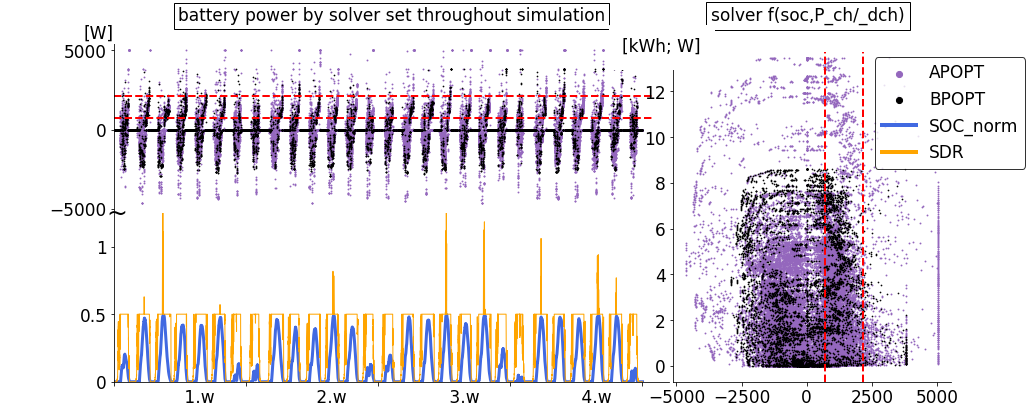

In [104]:
J = 18#es
tmp00 = np.zeros( (Resource.K) )#solver index
for v,i in zip(Control.gekko_log, range(Resource.K)):
    if v is not None and v[-1] == 1:#succ solve
        tmp00[i] = v[2]#get solver

tmp0 = np.repeat(tmp00, J)
tmp1 = mdata['hh_es'][:,0].flatten()#P along k in J chunks; MODEL MUST be intact: read mdata
tmp2 = to_kWh(mdata['hh_es'][:,3].flatten())*-1#soc

x1 = np.ma.masked_where(tmp0 != 1, tmp1)
x2 = np.ma.masked_where(tmp0 != 2, tmp1)
x3 = np.ma.masked_where(tmp0 != 3, tmp1)
y1 = np.ma.masked_where(tmp0 != 1, tmp2)
y2 = np.ma.masked_where(tmp0 != 2, tmp2)
y3 = np.ma.masked_where(tmp0 != 3, tmp2)

tmp4 = pop_col['SDR_k0toK']
tmp5 = pop_col['E_j0toJ_es_soc'].sum(axis=0) / pop_col['E_j0toJ_es_soc_max'].sum(axis=0)

fig, axs = plt.subplots(figsize=(15,2.5*2.5))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 0.5], height_ratios=[1, 1])
axs0 = plt.subplot(gs[0,0])
axs1 = plt.subplot(gs[1,0])
axs2 = plt.subplot(gs[:,1])

ind = np.tile(np.arange(Resource.K),J)
axs0.scatter(ind, x1, marker='.', s=3, c='#9467BD')
axs0.scatter(ind, x2, marker='.', s=2, c='k')
axs0.set_xticks([])
axs0.spines['bottom'].set_visible(False)
axs0.set_xlim(0)

axs1.plot(tmp5, lw=3, ls='-', color='royalblue')
axs1.plot(tmp4, lw=1, ls='-', color='orange')
axs1.text(-550,2.38, r'~', fontsize=25)
axs1.set_xticks(np.arange(0,1440*28+120, 1440*7))
axs1.set_xticklabels( [*(f'                                 {i}.w ' for i in range(1,5))])
axs1.set_xlim(0)
axs1.set_ylim(0,2.5)
axs1.set_yticklabels([0,0.5,1,1.5,2])

axs2.scatter(x1, y1, marker='.', s=3, c='#9467BD')
axs2.scatter(x2, y2, marker='.', s=2, c='k')
# axs2.scatter(x3, y3, marker='.', s=100, c='#17BECF')#empty, no IPOPT
axs0.text(0.5,1.1,'battery power by solver set throughout simulation', va='bottom', ha='center', transform=axs0.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs2.text(1.25,1.1,'solver f(soc,P_ch/_dch)', va='bottom', ha='center', transform=axs0.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':5})
axs0.text(0,1,'[W]', va='bottom', ha='right', transform=axs0.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':1})
axs2.text(0.1,0.96,'[kWh; W]', va='bottom', ha='right', transform=axs2.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':13})
leg = fig.legend(('APOPT', 'BPOPT', 'SOC_norm', 'SDR'), markerscale=10, scatterpoints=1, bbox_to_anchor=(1.3,0.98), bbox_transform=axs2.transAxes, frameon=True, edgecolor='k')
plt.setp(leg.get_lines(), linewidth=4)
plt.setp(leg.get_lines(), linewidth=4)
leg.legendHandles[0]._sizes = [150]
leg.legendHandles[1]._sizes = [150]

axs0.axhline(y=2142, xmax=0.97, linestyle='--', lw=2, color='red')
axs0.axhline(y=712, xmax=0.97, linestyle='--', lw=2, color='red')
axs2.axvline(x=2142, ymax=0.97, linestyle='--', lw=2, color='red')
axs2.axvline(x=712, ymax=0.97, linestyle='--', lw=2, color='red')
# axs0.axhline(y=0, linestyle='-', lw=1, color='k')
plt.subplots_adjust(wspace=0.01, hspace=0.01, right=None)#left=None, bottom=None, right=None, top=None, 
plt.show()

In [105]:
# plot does need PV output included, not time

# left plot: charge/discharge power versus time colored by solver [kW] 
#     power range of es is utilized but rather kept low from max 3800 since max eff since 0.9684773180040092, 2142W-range  (j12 5000)
#   dashed lines: eff range from 712W,0.90 up to opt to 0.96 at 2142W
#     bpopt on loc soc solutions end of day, curve, extended by apopt 5k
#     spot-check: towards end tail :5k range happens when others depleted, only one to deliver, running in low eff, since autonomy higher weighted in obj eg ifdusgk_model731 cpaste to apmmonitor
#      why only on 2d: state+heavy ld_profiles constellation leads to 
#         pop_col['P_j0toJ_es_ext'][:,22000]
#         for i in range(3000):
#             if np.any(pop_col['P_j0toJ_es_ext'][:,22000+i] > 5000):
#                 print(pop_col['P_j0toJ_es_ext'][:,22000+i], i, '\n')
#         Control.gekko_log[205000:]

# right plot: state of charge [kWh] versus charge and discharge power [W]
#    the ch/dch power range is kept off xaxis  to jump over low inv eff -> gap,  , seldom above opt.  why:
display( ((1-0.8) *80 , (1-0.9) *90, (1-0.95) *180 , (1-0.96) *190,) )
#     instead rather one opt: use plateau for many 'close to opti' to not have one operate on low eff
#         gap more visible on the right, closes on low soc due range constraint
#    no gap  on ch is close to one since using pv output and linear loss, can only charge pv if charge
#         mean P_J_ld = 11kW / 18 = 610W per es
#     no solver correlation with soc, apopt is default, explain solver APOPT unable to find sol when bopot can: cases unident in logs ; 


# SDR upwards when SOC close to full, close since model no dof, 
tmp2 = np.sort(pop_col['SDR_k0toK'])
tmp3 = np.where(tmp2>1.01)
tmp4 = pop_col['P_j0toJ_res'].sum(axis=0)[tmp3].sum() * Resource.kclock
print(f'for {tmp3[0].shape[0] / (4*7*1440)*100:.3f}% of K is SOC full and comm feeds out, marginal diff to opt SSR, fed out{to_kWh(tmp4):.3f}kWh {to_kWh(tmp4)/-2000*100:.3f}%')#2k inflow xfmr

# SDR upwards is ok since pv dim on, ld and the grid might not be able to absorb all pv on low load
# comm is longterm silightly short but are the es enough

(15.999999999999996, 8.999999999999998, 9.000000000000007, 7.600000000000007)

for 1.066% of K is SOC full and comm feeds out, marginal diff to opt SSR, fed out-86.094kWh 4.305%


In [106]:
# (x,0,1=succ) is nec&suff to say its loss_opt solve, conseq two is no_loss_closed_xfmr, then no_loss_open_xfmr, 
# why open xfmr no loss: obj2 is nonlinear +no_loss obj1 makes solver no conv, ok since only transition short long or long short 
#     on Pv>ld and es_dch < ld
# when assume solver always find sol when exists (neglec. non-conv xfmr opens) how often does solver end on (x,1,1=succ):
c = 0
cc = 0
for log in  Control.gekko_log:
    if log is not None and log[-2] ==1 and log[-1] ==1:
        c+=1
    if log is not None and log[-2] ==0 and log[-1] ==1:
        cc+=1
# non_opt, opt, 8% apopt & bpopt unable to find no_loss conv, 3:ipopt does yet online DOS
c, cc, c/(c+cc)
# Control.gekko_log

(1745, 18832, 0.08480342129562132)

##### About hh

    About hh energy zoom in

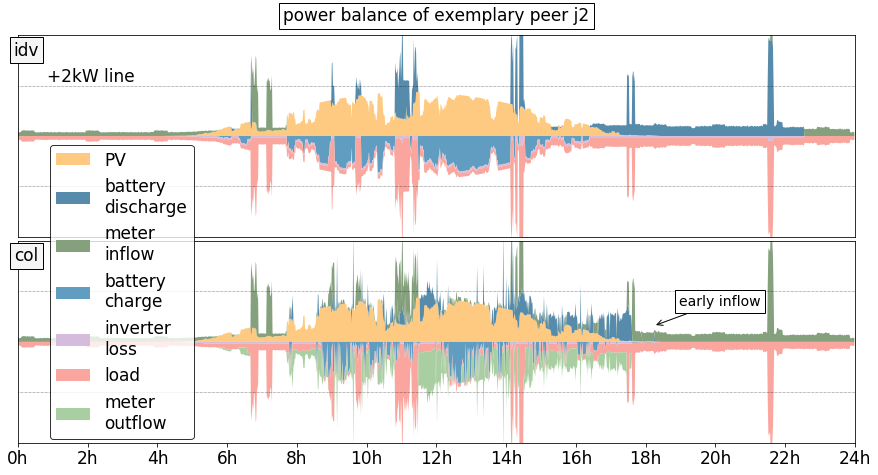

In [107]:
days = 1
tmp01 = pop_idv['P_j0toJ_es_ext'][2,:1440*days]
tmp02 = pop_idv['P_j0toJ_res'][2,:1440*days]
tmp1 = np.vstack([pop_idv['P_j2_pv'][:1440*days], np.where(tmp01>=0, tmp01, 0), np.where(tmp02<0, tmp02*-1, 0), ])
tmp10 = np.vstack([ np.where(tmp01<0, tmp01, 0), pop_idv['P_j2_inv_loss'][:1440*days], pop_idv['P_j2_ld'][:1440*days], np.where(tmp02>=0, tmp02*-1, 0), ])

tmp03 = pop_col['P_j0toJ_es_ext'][2,:1440*days]
tmp04 = pop_col['P_j0toJ_res'][2,:1440*days]
tmp2 = np.vstack([pop_col['P_j2_pv'][:1440*days], np.where(tmp03>=0, tmp03, 0), np.where(tmp04<0, tmp04*-1, 0)])
tmp20 = np.vstack([np.where(tmp03<0, tmp03, 0), pop_col['P_j2_inv_loss'][:1440*days], pop_col['P_j2_ld'][:1440*days], np.where(tmp04>=0, tmp04*-1, 0)])
 
tmp0 = np.arange(1440*days)
tmp3 = [mcolor['pv'], mcolor['es']*0.8, mcolor['grid']*0.7 ]
tmp4 = [mcolor['es']*0.9, mcolor['inv'], mcolor['ld'], mcolor['grid']*0.9 ]
fig, axs = plt.subplots(2,1, figsize=(15,5*1.5), sharey=True)#, sharex=True)
axs[0].stackplot(tmp0, tmp1, colors=tmp3)
axs[0].stackplot(tmp0, tmp10, colors=tmp4)
axs[0].set_ylim(-4000,4000)
# axs[0].spines['bottom'].set_visible(False)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].text(50,2150, r'+2kW line', fontsize=17)
# axs[0].text(50,-2000-20, r'-2kW line', fontsize=17, va='bottom')

axs[1].stackplot(tmp0, tmp2, colors=tmp3)
axs[1].stackplot(tmp0, tmp20, colors=tmp4)
axs[1].set_xticks(np.arange(0,1440+120, 120))
axs[1].set_xticklabels( [*(f'{i}h' for i in range(0,25,2))])
axs[1].set_yticks([])

axs[0].set_xlim(0,1440)
axs[1].set_xlim(0,1440)
axs[0].spines['top'].set_visible(True)
axs[1].spines['top'].set_visible(True)
axs[0].spines['right'].set_visible(True)
axs[1].spines['right'].set_visible(True)

fig.legend(('PV','battery\ndischarge','meter\ninflow','battery\ncharge','inverter\nloss','load','meter\noutflow'), bbox_to_anchor=(0.22,0.5), bbox_transform=axs[0].transAxes, frameon=True, edgecolor='k')
axs[0].axhline(y=2000, linestyle=':', linewidth=0.5, color='k')
axs[0].axhline(y=-2000, linestyle=':', linewidth=0.5, color='k')
axs[1].axhline(y=2000, linestyle=':', linewidth=0.5, color='k')
axs[1].axhline(y=-2000, linestyle=':', linewidth=0.5, color='k')
axs[0].text(0.5,1.05,'power balance of exemplary peer j2', va='bottom', ha='center', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.01,0.88,'idv', va='bottom', ha='center', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[1].text(0.01,0.88,'col', va='bottom', ha='center', transform=axs[1].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
xy = np.array([0.76,0.58])
axs[1].annotate('early inflow', xy, xytext=xy+[0.03,0.1], size=14, xycoords='axes fraction', bbox={'facecolor':'white'}, arrowprops={'arrowstyle':'->'})
plt.subplots_adjust(wspace=0.022, hspace=0.02, right=None)#left=None, bottom=None, right=None, top=None, 
plt.show()



In [108]:
# power balance of exemplary peer j2 on individual and collective control [W]
# simulator energy conservation, how its balanced differs greatly on control, say totals e-foo but not plots here


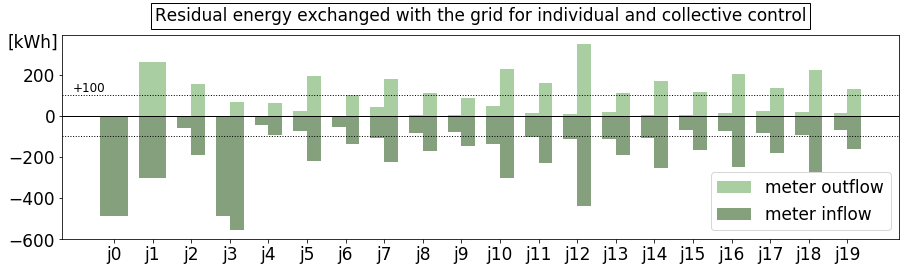

In [109]:
tmp0 = to_kWh(np.where(pop_idv['P_j0toJ_res']>0, pop_idv['P_j0toJ_res'], 0).sum(axis=1) * Resource.kclock)#prod
tmp1 = to_kWh(np.where(pop_idv['P_j0toJ_res']<0, pop_idv['P_j0toJ_res'], 0).sum(axis=1) * Resource.kclock)#cons
tmp2 = to_kWh(np.where(pop_col['P_j0toJ_res']>0, pop_col['P_j0toJ_res'], 0).sum(axis=1) * Resource.kclock)
tmp3 = to_kWh(np.where(pop_col['P_j0toJ_res']<0, pop_col['P_j0toJ_res'], 0).sum(axis=1) * Resource.kclock)

layer0 = np.zeros( (20*2) )#idv and col interweaved
layer0[0::2] = tmp0#idv 
layer0[1::2] = tmp2#col 
layer1 = np.zeros( (20*2) )
layer1[0::2] = tmp1
layer1[1::2] = tmp3
offset = layer0 + layer1#E_res = E_prod + E_cons; bar bottom under horizontal is short
ind = np.repeat(np.arange(20, dtype=np.float64), 2)*1.4#cordx
ind[1::2] = ind[1::2] + 0.5#between bar pair

fig, axs = plt.subplots(1,1, figsize=(15,1.5*2.5), sharey=True)
axs = [axs]
axs[0].bar(ind, layer0, width=-0.5, color=mcolor['grid']*0.9, bottom=0, align='edge')
axs[0].bar(ind, layer1, width=-0.5, color=mcolor['grid']*0.7, bottom=0, align='edge')
axs[0].set_xticks(ind[0::2])
axs[0].set_xticklabels([*(f'j{i}' for i in range(20))])
axs[0].legend(('meter outflow', 'meter inflow'), loc='best', frameon=True)
axs[0].axhline(y=0, linestyle='-', linewidth=1, color='k')
axs[0].axhline(y=100, linestyle=':', linewidth=1, color='k')
axs[0].axhline(y=-100, linestyle=':', linewidth=1, color='k')
axs[0].text(-1.5,115, r'+100', fontsize=12)
axs[0].text(-0.005,0.92,'[kWh]', va='bottom', ha='right', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':1})
axs[0].spines['top'].set_visible(True)
axs[0].spines['right'].set_visible(True)
axs[0].set_title('Residual energy exchanged with the grid for individual and collective control', y=1, pad=+10, va="bottom",ha='center', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
plt.show()

In [110]:
# j0 j1 no variation, other more in and out
print(f'''idv prod:{tmp0.sum():.3f} cons:{tmp1.sum():.3f}kWh
idv prod:{tmp2.sum():.3f} cons:{tmp3.sum():.3f}kWh''')


idv prod:511.800 cons:-2728.546kWh
idv prod:3052.127 cons:-4971.205kWh


    About self-suff and price

In [111]:
 pop_idv['SCR_j0toJ']

array([1.        , 0.389098  , 0.99927867, 0.99954678, 1.        ,
       0.95578035, 0.99997027, 0.91233075, 0.97624193, 0.9812444 ,
       0.93306181, 0.96813627, 0.99030685, 0.95069556, 0.98931275,
       0.99224727, 0.97966157, 0.94251904, 0.96429113, 0.96556062])

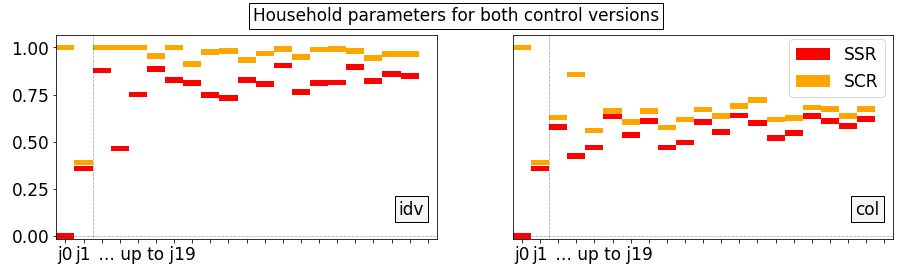

In [112]:
layer = np.zeros( (4,20) )#idv and col interweaved
layer[0] = pop_idv['SSR_j0toJ']
layer[1] = pop_idv['SCR_j0toJ']
layer[2] = pop_col['SSR_j0toJ']
layer[3] = pop_col['SCR_j0toJ']

fig, axs = plt.subplots(1,2, figsize=(15,1.5*2.5))
ind = np.arange(1,21, dtype=np.float64)*1#cordx
height = 0.03
width = 1
axs[0].bar(ind-width/2, height, width=width, bottom=layer[0]-height/2, color='red')
axs[0].bar(ind-width/2, height, width=width, bottom=layer[1]-height/2, color='orange')
axs[1].bar(ind-width/2, height, width=width, bottom=layer[2]-height/2, color='red')#col
axs[1].bar(ind-width/2, height, width=width, bottom=layer[3]-height/2, color='orange')

axs[0].set_xlim(0)
axs[1].set_xlim(0)
axs[0].set_xticks([i+0.5 for i in range(0,21)])
axs[0].set_xticklabels(['j0', 'j1', '                 ... up to j19', ])
axs[1].set_xticks([i+0.5 for i in range(0,21)])
axs[1].set_xticklabels(['j0', 'j1', '                 ... up to j19', ])
axs[1].set_yticks([])
# axs[1].spines['left'].set_visible(False)
# axs[1].spines['bottom'].set_visible(False)
axs[0].spines['top'].set_visible(True)
axs[1].spines['top'].set_visible(True)
axs[0].spines['right'].set_visible(True)
axs[1].spines['right'].set_visible(True)
fig.legend(('SSR', 'SCR'), bbox_to_anchor=(1.,1.02), bbox_transform=axs[1].transAxes, frameon=True)#, markerscale=0.8, labelspacing=1.5,)
# plt.delaxes(axs[0])
axs[0].axvline(x=2, linestyle=':', linewidth=0.5, color='k')
axs[1].axvline(x=2, linestyle=':', linewidth=0.5, color='k')
axs[0].axhline(y=0., linestyle=':', linewidth=0.5, color='k', xmax=2) 
axs[1].axhline(y=0., linestyle=':', linewidth=0.5, color='k', xmax=2) 
# plt.subplots_adjust(wspace=0.0, hspace=None, right=None)#left=None, bottom=None, right=None, top=None, 
axs[0].set_title('Household parameters for both control versions', x=1.05,y=1, pad=+10, va="bottom",ha='center', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.9,0.1,'idv', va='bottom', ha='left', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[1].text(0.9,0.1,'col', va='bottom', ha='left', transform=axs[1].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
plt.show()

In [113]:
# SSR, SCR on individual and collective control; left two j same - 0 var # hhxhh, axis 
# SSR how much of consumed came locally, SCR how much of produced stayed locally
# es increase until SCR close 1
# pv increase until SSR close to 1, while keeping SCR 1 otherwise unable to hold E locally ->show effect
# j2 only SSR > SCR ? same SCR but more less SSR
pop_idv['SCR_j0toJ'][2:].mean(), pop_col['SCR_j0toJ'][2:].mean()

(0.9722325573142953, 0.655419506325848)

In [114]:

#allocate data in pop dicts:
tmp000 = to_kWh(np.where(pop_idv['P_j0toJ_res']>0, pop_idv['P_j0toJ_res'], 0) * Resource.kclock)
tmp100 = to_kWh(np.where(pop_idv['P_j0toJ_res']<0, pop_idv['P_j0toJ_res'], 0) * Resource.kclock)
tmp200 = to_kWh(np.where(pop_col['P_j0toJ_res']>0, pop_col['P_j0toJ_res'], 0) * Resource.kclock)
tmp300 = to_kWh(np.where(pop_col['P_j0toJ_res']<0, pop_col['P_j0toJ_res'], 0) * Resource.kclock)#RENAME other 00 000
tmp5 = mimp['de_epex_spot_intraday_continuous.csv'].iloc[:4*7*24,[4]].values.flatten() /1000#eur/mWh to eur/kWh, hourly for 4*7*24+3*24 hours alias 31 days, need 28d
tmp700 = np.repeat(tmp5,60)*-1#upsample shape, negate to fit sign; epex ticker
tmp800 = to_kWh(pop_col['E_dss_zone'][0] + pop_col['E_J_loss_grid']*-1)#xfmr

c_cons_ = [-0.28, -0.28, -0.28, -0.32] #eur/kWh, <0 since pov swap from system to peer FOOBAR
c_prod_ = [-0.12, -0.24, tmp700, -0.17] #eur/kWh, feed-in
c_eeg = [-0.12, -0.24, -0.]#now:past_2012;future; compensating up to this value to close epex_delta to hh
# EEG pv 2012 24ct/kWhh, but will 0
#     https://modernus.de/solar-photovoltaik-anlagen/photovoltaik-foerderung-finanzierung-einspeiseverguetung-2011-2012-kfw-verguetung
#     https://www.zolar.de/blog/entwicklung-der-eeg-einspeiseverguetung

pop_idv['C_j0toJ_res'] = np.zeros( (3,20) )#i012 above alias 'now', '2012', 'sym'
pop_col['C_j0toJ_res'] = np.zeros( (3+3+1,20) )#i012003-'now', '2012', 'sym', 'mmr', 'mmr1:', 'mmr^', 'epex'
pop_col['C_ktoK_prod'] = np.zeros( (3+3+1,40320) )
pop_col['C_ktoK_cons'] = np.zeros( (3+3+1,40320) )
pop_idv['R_ktoK_prod'] = np.zeros( (3,40320,) )#revenue = cost *-1
pop_col['R_ktoK_prod'] = np.zeros( (3+3+1,40320,) )
pop_idv['R_ktoK_cons'] = np.zeros( (3,40320,) )#
pop_col['R_ktoK_cons'] = np.zeros( (3+3+1,40320,) )
pop_idv['R_ktoK_bfepx'] = np.zeros( (3,40320,) )
pop_col['R_ktoK_bfepx'] = np.zeros( (3+3+1,40320,) )
pop_idv['R_ktoK_stepx'] = np.zeros( (3,40320,) )
pop_col['R_ktoK_stepx'] = np.zeros( (3+3+1,40320,) )
pop_idv['R_ktoK_eegd'] = np.zeros( (3,40320,) )
pop_col['R_ktoK_eegd'] = np.zeros( (3+3+1,40320,) )
pop_idv['R_ktoK_loss'] = np.zeros( (3,40320,) )
pop_col['R_ktoK_loss'] = np.zeros( (3+3+1,40320,) )

#### about EPEX:

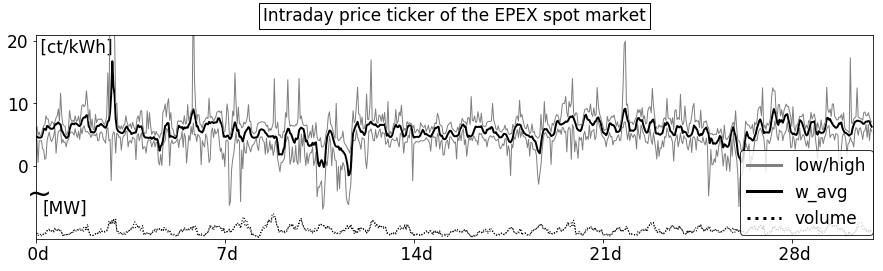

In [115]:
tmp1 = mimp['de_epex_spot_intraday_continuous.csv'].iloc[:,[1,2,3,4,-2,-1]].values *100/1000#to ct/kWh

fig, axs = plt.subplots(2,1, figsize=(15,2.5*1.5), gridspec_kw = {'width_ratios':[1], 'height_ratios':[1,0.15]}) 
axs[0].plot(tmp1[:,0], ls='-', color='gray', lw=1)
axs[0].plot(tmp1[:,3], ls='-', color='k', lw=2)
axs[0].set_ylim(-7.5,21)
axs[0].set_xlim(0,744)
axs[0].set_xticks([])
axs[0].spines['bottom'].set_visible(False)
axs[0].spines['top'].set_visible(True)
axs[0].spines['right'].set_visible(True)
axs[1].spines['right'].set_visible(True)

axs[1].plot(tmp1[:,-2], ls=':', color='k', lw=1.1)
axs[1].plot(tmp1[:,-1:], ls=':', color='k', lw=1.1)
axs[1].set_xlim(0)
axs[1].set_yticks([5000])
axs[1].text(-8,1800, r'~', fontsize=30)
axs[1].set_xlim(0,744)

leg = fig.legend(('low/high', 'w_avg', 'volume'), bbox_to_anchor=(1.01,0.4), bbox_transform=axs[0].transAxes, frameon=True, framealpha=0.8, edgecolor='k')
plt.setp(leg.get_lines(), linewidth=3)
plt.subplots_adjust(wspace=0., hspace=0.)
axs[0].plot(tmp1[:,1], ls='-', color='gray', lw=1)

axs[0].set_ylabel(' [ct/kWh]', rotation=0, fontsize=17)
axs[1].set_ylabel('[MW]', rotation=0, fontsize=17)
axs[0].yaxis.set_label_coords(0.045,0.88)
axs[1].yaxis.set_label_coords(0.035,0.8)
axs[1].set_xticks([i for i in range(0,31*24+1,24*7)])
axs[1].set_xticklabels( [*(f' {int(i)}d' for i in range(0,33,7))])#quick
axs[0].set_title('Intraday price ticker of the EPEX spot market', y=1, pad=+10, va="bottom",ha='center', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
plt.show()

In [116]:
# price cheap since no addons, but permissioned & min amount

#     summry: https://www.epexspot.com/document/39275/2018-07-03_EPEX%20SPOT_Power%20Trading%20Results%2006-2018.pdf
print(f'{45*100/1e3} ct/kWh: monthly average Price base_peak about 45 Eur/MWh')
display(mimp['de_epex_spot_intraday_continuous.csv'][:3])
#     chart: https://www.energy-charts.de/price.htm?auction=1h&year=2018
#     meta: https://www.epexspot.com/document/38579/Epex_TradingBrochure_180129_Web.pdf
#     or another exchange exaa time-series (offers data while epx payed only):
#         spot should be tied, more now: https://commons.wikimedia.org/wiki/File:Vola2011.png#/media/File:Vola2011.png
#         data DE: bhttps://open-power-system-data.org/data-sources

4.5 ct/kWh: monthly average Price base_peak about 45 Eur/MWh


h  Low(Eur/MWh)  High(Eur/MWh)  Last(Eur/MWh)  \
24  00 - 01         39.71           56.6           46.0   
25  01 - 02         41.93           62.7           48.0   
26  02 - 03          4.90           49.0           40.2   

    Weight. Avg.(Eur/MWh)  Index(Eur/MWh)  ID₃-Price(Eur/MWh)  \
24                  45.36           45.36               45.20   
25                  46.69           46.69               46.33   
26                  45.01           45.01               45.40   

    ID₁-Price(Eur/MWh)  Buy Vol(MW)  Sell Vol(MW)  
24               45.88       3109.4        2728.8  
25               51.39       3827.5        2962.2  
26               46.09       3004.4        2280.9

##### about mid-market-rate:

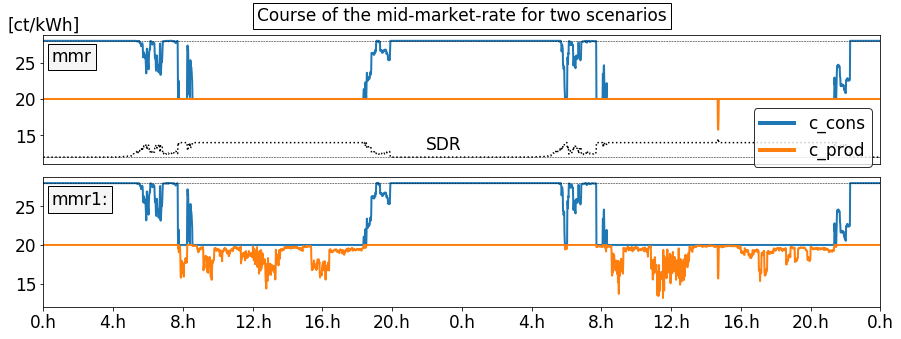

In [117]:
c_cons = c_cons_[0]#buyfromgrid
c_prod = c_prod_[0]#stg

def calc_mmr(tmp0):
    """implements mid-market rate from paper [1]
    takes residual hh loads in J,K ndarray
    returns course of mmr cons/prod and price mask (j,K)
    side-effect: read c_cons/c_prod/c_mm
    [1] https://doi.org/10.1109/PESGM.2017.8274546
    """
    prod_sum = np.where(tmp0>0, tmp0, 0).sum(axis=0)
    cons_sum = np.where(tmp0<0, tmp0, 0).sum(axis=0)*-1

    c_cons_mmr = np.where(prod_sum==cons_sum, c_mm, 0)#(16a)
    c_prod_mmr = np.where(prod_sum==cons_sum, c_mm, 0)

    f17b_ = cons_sum * c_mm + (prod_sum - cons_sum) * c_prod
    f17b = np.divide(f17b_, prod_sum, where=prod_sum!=0)
    c_cons_mmr_b = np.where(prod_sum>cons_sum, c_mm, 0)
    c_prod_mmr_b = np.where(prod_sum>cons_sum, f17b, 0)#(17b)

    f16c_ = prod_sum * c_mm + (cons_sum - prod_sum) * c_cons
    f16c = np.divide(f16c_, cons_sum, where=cons_sum!=0)
    c_cons_mmr_c = np.where(prod_sum<cons_sum, f16c, 0)#(16c)
    c_prod_mmr_c = np.where(prod_sum<cons_sum, c_mm, 0)

    c_cons_mmr[c_cons_mmr==0] = c_cons_mmr_b[c_cons_mmr==0]#take _b where 0
    c_cons_mmr[c_cons_mmr==0] = c_cons_mmr_c[c_cons_mmr==0]#take _c where still 0
    c_prod_mmr[c_prod_mmr==0] = c_prod_mmr_b[c_prod_mmr==0]
    c_prod_mmr[c_prod_mmr==0] = c_prod_mmr_c[c_prod_mmr==0]
    c_j0toJ = np.where(tmp0>=0, c_prod_mmr, c_cons_mmr)#price mask each j each k
    return c_cons_mmr, c_prod_mmr, c_j0toJ

c_mm = (c_prod + c_cons) / 2#(15)

c_cons_mmr_0,c_prod_mmr_0, c_j0toJ_0 = calc_mmr(pop_col['P_j0toJ_res'])
tmp00 = to_kWh(pop_col['P_j0toJ_res'] * Resource.kclock)
tmp0 = c_j0toJ_0 * tmp00

pop_col['C_k0toK_j0toJ_mmr'] = tmp0#store course
pop_col['C_j0toJ_res'][3] = tmp0.sum(axis=1)#store bill
pop_col['C_ktoK_prod'][3] = (tmp200 * c_prod_mmr_0).sum(axis=0) 
pop_col['C_ktoK_cons'][3] = (tmp300 * c_cons_mmr_0).sum(axis=0)
resJ_kwh = (tmp200 + tmp300).sum(axis=0)
pop_col['R_ktoK_prod'][3] = np.where(resJ_kwh>0, resJ_kwh, 0) *c_prod
pop_col['R_ktoK_cons'][3] = np.where(resJ_kwh<0, resJ_kwh, 0) *c_cons
pop_col['R_ktoK_stepx'][3] = np.where(resJ_kwh>0, resJ_kwh, 0)*-1 *tmp700
pop_col['R_ktoK_bfepx'][3] = np.where(resJ_kwh<0, resJ_kwh, 0)*-1 *tmp700 
pop_col['R_ktoK_loss'][3:7] = to_kWh(pop_col['E_J_loss_grid'])*-1 *tmp700 #<0
pop_col['R_ktoK_eegd'][3] = np.where(resJ_kwh>0, resJ_kwh, 0) *(c_eeg[0] - tmp700)*-1 # v idv tmp200 only, now res at xfmr

c_cons_mmr_1,c_prod_mmr_1, c_j1toJ = calc_mmr(pop_col['P_j0toJ_res'][1:])#only pv hh, excl j0
tmp11 = to_kWh(pop_col['P_j0toJ_res'][1:] * Resource.kclock)
tmp1 = c_j1toJ * tmp11
pop_col['C_k0toK_j1toJ_mmr'] = tmp1
pop_col['C_j0toJ_res'][4][1:] = tmp1.sum(axis=1)
pop_col['C_ktoK_prod'][4] = (tmp200[1:] * c_prod_mmr_1).sum(axis=0) 
pop_col['C_ktoK_cons'][4] = (tmp300[1:] * c_cons_mmr_1).sum(axis=0)
resJ_kwh = (tmp200[1:] + tmp300[1:]).sum(axis=0)
pop_col['R_ktoK_prod'][4] = np.where(resJ_kwh>0, resJ_kwh, 0) *c_prod
pop_col['R_ktoK_cons'][4] = np.where(resJ_kwh<0, resJ_kwh, 0) *c_cons
pop_col['R_ktoK_stepx'][4] = np.where(resJ_kwh>0, resJ_kwh, 0)*-1 *tmp700
pop_col['R_ktoK_bfepx'][4] = np.where(resJ_kwh<0, resJ_kwh, 0)*-1 *tmp700 
# loss about same as [3]
pop_col['R_ktoK_eegd'][4] = np.where(resJ_kwh>0, resJ_kwh, 0) *(c_eeg[0] - tmp700)*-1 # v idv tmp200 only, now res at xfmr

fig, axs = plt.subplots(2,1, figsize=(15,2.5*2))#, sharey=True)
axs[0].plot(c_cons_mmr_0[:1440*2]*-100, lw=2)
axs[0].plot(c_prod_mmr_0[:1440*2]*-100, lw=2)
axs[0].plot(pop_col['SDR_k0toK'][:1440*2]*2+12, ls=':', color='k')
axs[0].set_xlim(0, 1440*2)
axs[0].set_ylim(11)
axs[0].set_xticks([])

c_cons_mmr,c_prod_mmr, c_j1toJ = calc_mmr(pop_col['P_j0toJ_res'][1:])#no j0, so only pv hhs
axs[1].plot(c_cons_mmr_1[:1440*2]*-100, lw=2)
axs[1].plot(c_prod_mmr_1[:1440*2]*-100, lw=2)
axs[1].set_xlim(0, 1440*2)
axs[1].set_ylim(12)

leg = fig.legend(('c_cons', 'c_prod'), bbox_to_anchor=(1.0,0.5), bbox_transform=axs[0].transAxes, frameon=True, edgecolor='k')
plt.setp(leg.get_lines(), linewidth=4)
axs[0].axhline(y=c_cons*-100, linestyle='--', lw=0.5, color='k')
axs[0].axhline(y=c_prod*-100, linestyle='--', lw=0.5, color='k')
axs[1].axhline(y=c_cons*-100, linestyle='--', lw=0.5, color='k')
axs[1].axhline(y=c_prod*-100, linestyle='--', lw=0.5, color='k')
axs[0].set_ylabel('[ct/kWh]', rotation=0, fontsize=17)
axs[0].yaxis.set_label_coords(0,1)

plt.subplots_adjust(wspace=0., hspace=0.1, right=None)
axs[1].set_xticks([x for x in range(0,1440*2+1,60*4)])
axs[1].set_xticklabels( [*(f'{i%24}.h' for i in range(0,24*2+1,4))])

c_cons = c_cons_[3]#mmr^: test to increase dso rev
c_prod = c_prod_[3]
c_mm = (c_prod + c_cons) / 2
c_cons_mmr,c_prod_mmr, c_j0toJ = calc_mmr(pop_col['P_j0toJ_res'])
tmp00 = to_kWh(pop_col['P_j0toJ_res'] * Resource.kclock)
tmp0 = c_j0toJ * tmp00
pop_col['C_j0toJ_res'][5] = tmp0.sum(axis=1)
pop_col['C_ktoK_prod'][5] = (tmp200 * c_prod_mmr_0).sum(axis=0) 
pop_col['C_ktoK_cons'][5] = (tmp300 * c_cons_mmr_0).sum(axis=0)
resJ_kwh = (tmp200 + tmp300).sum(axis=0)
pop_col['R_ktoK_prod'][5] = np.where(resJ_kwh>0, resJ_kwh, 0) *c_prod
pop_col['R_ktoK_cons'][5] = np.where(resJ_kwh<0, resJ_kwh, 0) *c_cons
pop_col['R_ktoK_stepx'][5] = np.where(resJ_kwh>0, resJ_kwh, 0)*-1 *tmp700
pop_col['R_ktoK_bfepx'][5] = np.where(resJ_kwh<0, resJ_kwh, 0)*-1 *tmp700 
pop_col['R_ktoK_eegd'][5] = np.where(resJ_kwh>0, resJ_kwh, 0) *(c_eeg[0] - tmp700)*-1 
pop_col['R_ktoK_topup'] = np.where(resJ_kwh>0, resJ_kwh, 0) *(c_prod - c_eeg[0]) #delta upped mmr to eegprice, for energy sold

axs[0].spines['top'].set_visible(True)
axs[0].spines['right'].set_visible(True)
axs[1].spines['top'].set_visible(True)
axs[1].spines['right'].set_visible(True)
axs[0].set_title('Course of the mid-market-rate for two scenarios', y=1, pad=+10, va="bottom",ha='center', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.01,0.76,'mmr', va='bottom', ha='left', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[1].text(0.01,0.76,'mmr1:', va='bottom', ha='left', transform=axs[1].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.5,0.08,'SDR', va='bottom', ha='right', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':0})
plt.show()

In [118]:
# course of mmr and 'mmr1:', talk about drop where graph SDR above 1 
# upper plot:
#     cons and prod at max, cons pure extern, potential prod best price,
#     midday price drop until self-suff; control to SDR1 -> both middle; until no pv/soc left back to start state,
#         sdr to show its p(sdr)
# below: exclude pure consumer j0 to show price drop on long: same energy-flow/layer reinterprets to long drops price considered xfmr sold;
#     note: SDR>1: cons min & pv down
#           SDR=1: cons min & pv max -> both parties benefit
#           SDR<1: cons up & pv max
# rather not fancy but basic: whats core: redistribute cost fairly, no local 'agent race of smarter/better_logic/computer'
# good: post-calc: no decision on the fly, if unsatisfied conv calc possible

# fairly distributed yes: see Pdch/dch

    experimental mmr pmech: direct epex coupled

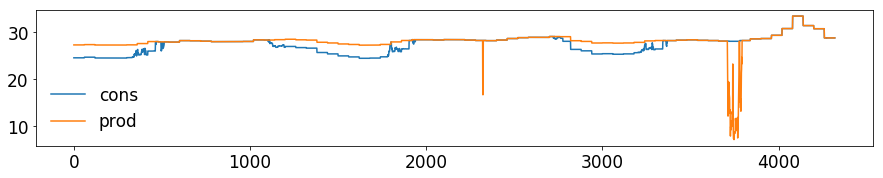

0         1        2          3         4         5         6   \
0  133.318913  9.614944  8.51559  130.15801  7.241719  5.979902  8.266492   

          7          8          9          10         11         12  \
0  11.676306  15.481953  14.819244  19.570444  17.152704  21.956081   

          13        14         15         16         17         18        19  
0  21.792209  22.99476  12.043082  11.787558  11.220616  12.742346  7.967245

In [119]:
c_ = -0.30 #LATER push to appendix
# c_cons = #c_cons_[3]#now mmr+epex combi
# c_prod = #c_prod_[3]
c__ = mimp['de_epex_spot_intraday_continuous.csv'].iloc[:,4].values *-1/1000# wavg
tax = -0.20

c_cons_mmrx = np.zeros( (28*1440) )
c_prod_mmrx = np.zeros( (28*1440) )
c_j0toJ_mmrx = np.zeros( (20,28*1440) )

tmp0 = pop_col['P_j0toJ_res'].reshape(20,672,60)#how much each hh per h, gird?loss
tmp1 = tmp0.sum(axis=2).sum(axis=0)

for i in range(28*24):#hours of ticker
    if tmp1[i] >= 0:#SDR > 1
        c_prod = c__[i]
        c_cons = c_
    else:#short
        c_prod = c_
        c_cons = c__[i]
    c_cons += tax
    
    c_mm = (c_prod + c_cons) / 2
    c_cons_mmrx[60*i:60*(i+1)],c_prod_mmrx[60*i:60*(i+1)], c_j0toJ_mmrx[:,60*i:60*(i+1)] = calc_mmr(tmp0[:,i,:])
    
    
tmp8 = c_j0toJ_mmrx * to_kWh(pop_col['P_j0toJ_res'] * Resource.kclock)
pop_col['C_j0toJ_res'][6] = tmp8.sum(axis=1)

plt.plot(c_cons_mmrx[:1440*3]*-100)
plt.plot(c_prod_mmrx[:1440*3]*-100)
plt.legend(('cons','prod'))
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.show()

pd.DataFrame(pop_col['C_j0toJ_res'][6]).T

In [120]:
# EXPERMINETAL: either prod/cons take ticker c__ to counterside c_: 
#     prod if oversupply bad epx price OR swap cons good epx price on short
#     consumers are forced to consume local pv and cons are tax_offset
# parameters and rev streams unclear yet it 'works'.


##### about hh price meachanism:

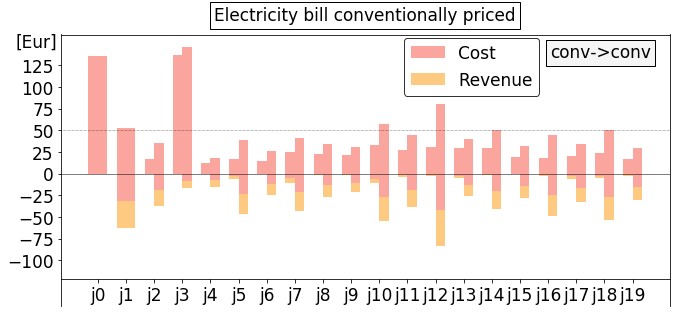

In [121]:
fig, axs = plt.subplots(1,2, figsize=(15*1.6,2.5*2), sharey=True)
ind = np.repeat(np.arange(20, dtype=np.float64), 2)*1.5#cordx
ind[1::2] = ind[1::2] + 0.5#between bar pair

for i in range(4):
    if i < 3:
        c_cons = c_cons_[i]
        c_prod = c_prod_[i]
    
        layer0 = np.zeros( (20*2) )#idv and col interweaved
        layer0[0::2] = (tmp000 * c_prod).sum(axis=1)#idv 
        layer0[1::2] = (tmp200 * c_prod).sum(axis=1)#col 
        layer1 = np.zeros( (20*2) )
        layer1[0::2] = (tmp100 * c_cons).sum(axis=1)#idv
        layer1[1::2] = (tmp300 * c_cons).sum(axis=1)#col
        
        C_res = layer0 + layer1#per hh C_prod + C_cons; negative cost is revenue
        pop_idv['C_j0toJ_res'][i] = C_res[0::2]#save
        pop_col['C_j0toJ_res'][i] = C_res[1::2] 
        pop_idv['R_ktoK_prod'][i] = (tmp000 * c_prod).sum(axis=0) #sumJ; R_res revenue from hhs, hh_prod is <0 since dso pays hh lowering R_res (view_change); <0
        pop_col['R_ktoK_prod'][i] = (tmp200 * c_prod).sum(axis=0)
        pop_idv['R_ktoK_cons'][i] = (tmp100 * c_cons).sum(axis=0) #>0
        pop_col['R_ktoK_cons'][i] = (tmp300 * c_cons).sum(axis=0)
        
        pop_idv['R_ktoK_stepx'][i] = (tmp000).sum(axis=0)*-1 *tmp700 # sell to epx
        pop_idv['R_ktoK_bfepx'][i] = (tmp100).sum(axis=0)*-1 *tmp700 # buy from epx
        pop_col['R_ktoK_stepx'][i] = (tmp200).sum(axis=0)*-1 *tmp700
        pop_col['R_ktoK_bfepx'][i] = (tmp300).sum(axis=0)*-1 *tmp700 
        
        pop_idv['R_ktoK_loss'][i] = to_kWh(pop_idv['E_J_loss_grid'])*-1 *tmp700 #<0
        pop_col['R_ktoK_loss'][i] = to_kWh(pop_col['E_J_loss_grid'])*-1 *tmp700
        if i < 2:
            pop_idv['R_ktoK_eegd'][i] = tmp000.sum(axis=0) *(c_eeg[i] - tmp700)*-1#only delta state subsidzed is rev for PS
            pop_col['R_ktoK_eegd'][i] = tmp200.sum(axis=0) *(c_eeg[i] - tmp700)*-1
            
    else:#plot only mmr
        tmp4 = pop_col['C_k0toK_j0toJ_mmr']
        layer0 = np.zeros( (20*2) )#idv and col interweaved
        layer0[0::2] = tmp000.sum(axis=1) * c_prod_[0]#idv conv., prod
        layer0[1::2] = np.where(tmp4<0, tmp4, 0).sum(axis=1)#col mmr, prod
        layer1 = np.zeros( (20*2) )
        layer1[0::2] = tmp100.sum(axis=1) * c_cons_[0]
        layer1[1::2] = np.where(tmp4>0, tmp4, 0).sum(axis=1) 

    if i == 0 or i == 3:#plot only two
        ax = axs[i%2]
        ax.bar(ind, layer1, width=-0.5, color=mcolor['ld'], bottom=layer0, align='edge')
        ax.bar(ind, layer0, width=-0.5, color=mcolor['pv'], bottom=layer0, align='edge')
        ax.set_xticks(ind[0::2])
        ax.set_xticklabels([*(f'j{i}' for i in range(20))])
        ax.set_yticks([i for i in range(-100,150,25)])
        ax.spines['bottom'].set_position(('axes', +0.1))

# plt.subplots_adjust(wspace=0.00, hspace=0, right=None)#left=None, bottom=None, right=None, top=None
plt.delaxes(axs[1])
leg = fig.legend(('Cost','Revenue'), bbox_to_anchor=(0.8,1.02), bbox_transform=axs[0].transAxes, frameon=True, edgecolor='k')
axs[0].axhline(y=0, linestyle='-', linewidth=0.5, color='k')
axs[1].axhline(y=0, linestyle='-', linewidth=0.5, color='k')
axs[0].axhline(y=50, linestyle=':', linewidth=0.5, color='k')
axs[1].axhline(y=50, linestyle=':', linewidth=0.5, color='k')
# axs[1].spines['left'].set_visible(False)
for ax in axs:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
axs[0].set_ylabel('[Eur]', rotation=0, fontsize=17)
axs[0].yaxis.set_label_coords(-0.04,0.94)
axs[0].set_title('Electricity bill conventionally priced', y=1, pad=+10, va="bottom",ha='center', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[1].set_title('Electricity bill MMR priced', y=1, pad=+10, va="bottom",ha='center', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.97,0.9,'conv->conv', va='bottom', ha='right', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[1].text(0.97,0.9,'conv->mmr', va='bottom', ha='right', transform=axs[1].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
plt.show()    

In [122]:
# left: idv:conv|conv; read cost from top: all hh pay since top >0
#     conv pricing in colv hinders collab., price-wise not reflected
#     cost of j01 same since no es, no dof
# right: col:conv|mmr 
#     price drops for j12 50cent inc. due short: shoort due j0
#         -> effect: short comm. on pure cons paid/less profit by others. 
#     energy flow the same but area scaled diff since pv  better / ld less compensated


##### about revenue streams

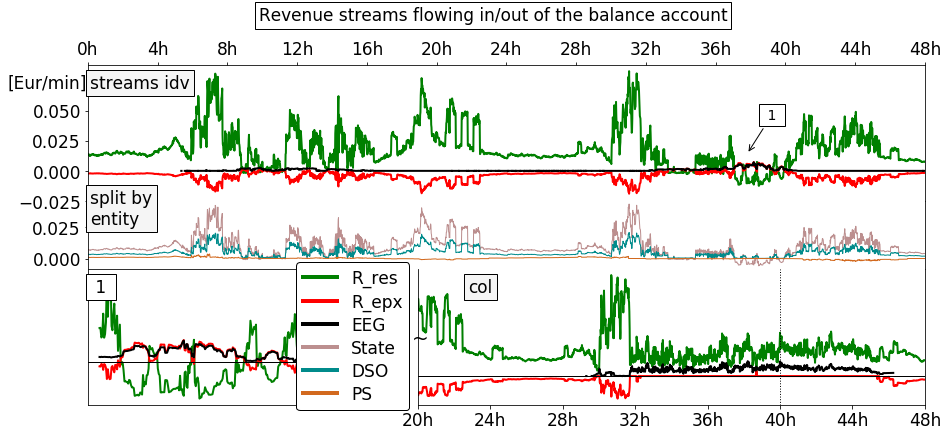

In [123]:
m = 0
up_to_k = 1440*2
tmp1 = pop_idv['R_ktoK_cons'][m,:up_to_k] + pop_idv['R_ktoK_prod'][m,:up_to_k] 
tmp4 = pop_idv['R_ktoK_bfepx'][m,:up_to_k] + pop_idv['R_ktoK_stepx'][m,:up_to_k]
tmp5 = np.ma.masked_where(pop_idv['R_ktoK_eegd'][m,:up_to_k] ==0, pop_idv['R_ktoK_eegd'][m,:up_to_k])
tmp6 = pop_idv['R_ktoK_cons'][m,:up_to_k] *0.23 + pop_idv['R_ktoK_bfepx'][m,:up_to_k]
tmp7 = pop_idv['R_ktoK_cons'][m,:up_to_k] *0.25 + pop_idv['R_ktoK_loss'][m,:up_to_k]
tmp8 = pop_idv['R_ktoK_cons'][m,:up_to_k] *0.52 + pop_idv['R_ktoK_eegd'][m,:up_to_k]*-1

fig = plt.figure(figsize=(15,2.5*2.5))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 2], height_ratios=[1, 0.5, 1])
ax = plt.subplot(gs[0,:])#R streams
ax.plot(tmp1, ls='-', color='green', lw=2)
ax.plot(tmp4, ls='-', color='red', lw=2)
ax.plot(tmp5, ls='-', color='k', lw=2)
ax.set_xlim(0,1440*2)
ax.set_xticks([i for i in range(0,60*24*2+1,60*4)])
ax.set_xticklabels( [*(f'{int(i)}h' for i in range(0,24*2+1,4))])
ax.set_yticks([-0.025, 0.,0.025,0.05])
ax.set_ylabel('[Eur/min]', rotation=0, fontsize=17)
ax.yaxis.set_label_coords(-0.049,0.8)
ax.xaxis.tick_top()
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

ax = plt.subplot(gs[1,:])#R entys
ax.plot(tmp8, ls='-', color='rosybrown', lw=1)
ax.plot(tmp7, ls='-', color='darkcyan', lw=1)
ax.plot(tmp6, ls='-', color='chocolate', lw=1)
ax.set_xlim(0,1440*2)
ax.set_xticks([])
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(False)

ax1 = plt.subplot(gs[2,0])#zoomed
ax1.plot(tmp1[2200:2450], ls='-', color='green', lw=2)
ax1.plot(tmp4[2200:2450], ls='-', color='red', lw=2)
ax1.plot(tmp5[2200:2450], ls='-', color='k', lw=2)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.axhline(y=0, linestyle='-', linewidth=1, color='k')

m = 0#VARY here to study c_cons_ vs c_prod_ different price gaps
up_to_k = 1440*2
tmp1 = pop_col['R_ktoK_cons'][m,1200:up_to_k] + pop_col['R_ktoK_prod'][m,1200:up_to_k] 
tmp4 = pop_col['R_ktoK_bfepx'][m,1200:up_to_k] + pop_col['R_ktoK_stepx'][m,1200:up_to_k]
tmp5 = np.ma.masked_where(pop_col['R_ktoK_eegd'][m,1200:up_to_k] ==0, pop_col['R_ktoK_eegd'][m,1200:up_to_k])
# tmp6 = pop_col['R_ktoK_cons'][m,1200:up_to_k] *0.23 + pop_col['R_ktoK_bfepx'][m,1200:up_to_k]
# tmp7 = pop_col['R_ktoK_cons'][m,1200:up_to_k] *0.25 + pop_col['R_ktoK_loss'][m,1200:up_to_k]
# tmp8 = pop_col['R_ktoK_cons'][m,1200:up_to_k] *0.52 + pop_col['R_ktoK_eegd'][m,1200:up_to_k]*-1

ax = fig.add_subplot(gs[2,1:])#, sharey=ax)#col 2012
ax.plot(tmp1, ls='-', color='green', lw=2)
ax.plot(tmp4, ls='-', color='red', lw=2)
ax.plot(tmp5, ls='-', color='k', lw=2)
ax.set_yticks([])
ax.set_xlim(0,1440*2-1200)
ax.set_xticks([i for i in range(0,60*28+1,60*4)])
ax.set_xticklabels( [*(f'{int(i)}h' for i in range(20,24*2+1,4))])
ax.spines['right'].set_visible(True)
ax.text(-20,0.028, r'~', fontsize=20)
ax.axhline(y=0, linestyle='-', linewidth=1, color='k')
ax.axvline(x=2400-1200, linestyle=':', linewidth=1, color='k')

plt.subplots_adjust(hspace=0., right=None)

leg = fig.legend(('R_res', 'R_epx', 'EEG', 'State', 'DSO', 'PS'), bbox_to_anchor=(0.,1.11), bbox_transform=ax.transAxes, edgecolor='k', frameon=True, framealpha=1, labelspacing=0.3)
plt.setp(leg.get_lines(), linewidth=4)
fig.text(0.5,0.97,'Revenue streams flowing in/out of the balance account',\
         va='bottom', ha='center', transform=fig.transFigure, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
ax.text(0.01,2.3,'streams idv', va='bottom', ha='left', transform=ax1.transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
ax.text(0.01,1.3,'split by\nentity', va='bottom', ha='left', transform=ax1.transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
ax.text(0.01,0.8,' 1 ', va='bottom', ha='left', transform=ax1.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
ax.text(1.5,0.8,'col', va='bottom', ha='left', transform=ax1.transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
xy = np.array([0.65,1.85])
ax.annotate(' 1 ', xy, xytext=xy+[0.03,0.25], size=14, xycoords='axes fraction', bbox={'facecolor':'white'}, arrowprops={'arrowstyle':'->'})
plt.show()

In [124]:
# verify the 40h mark:

In [125]:
tmp200.sum(axis=0)[2400] *(c_eeg[0] - tmp700[2400])*-1

0.012766334813966612

In [126]:
tmp200.sum(axis=0)[2400] ,(c_eeg[0] - tmp700[2400])*-1


(0.23654502156691892, 0.05396999999999999)

In [127]:
(tmp200 ).sum(axis=0)[2400],(tmp200 * c_prod).sum(axis=0)[2400]

(0.23654502156691892, -0.015619067774063659)

In [128]:
(tmp300 ).sum(axis=0)[2400], (tmp300 * c_cons).sum(axis=0)[2400]

(-0.23654501667099131, 0.06623260466787757)

In [129]:
(tmp200 * c_prod).sum(axis=0)[2400] + (tmp300 * c_cons).sum(axis=0)[2400]

0.05061353689381391

##### summary on cost:

In [131]:
#idv
pop_idv['tbl_C'] = pd.DataFrame(pop_idv['C_j0toJ_res'], index=['now', '2012', 'no_eeg']) 
pop_idv['tbl_C_meta'] = pd.DataFrame([], index=['now', '2012', 'no_eeg'])

pop_idv['tbl_C_meta']['hh_mean'] = pop_idv['C_j0toJ_res'].mean(axis=1)#describe data
pop_idv['tbl_C_meta']['hh_cons'] = pop_idv['R_ktoK_cons'].sum(axis=1)#reinterpret revenue to someone elses cost, so no *-1
pop_idv['tbl_C_meta']['hh_prod'] = pop_idv['R_ktoK_prod'].sum(axis=1)
pop_idv['tbl_C_meta']['hh_total'] = pop_idv['C_j0toJ_res'].sum(axis=1)
pop_idv['tbl_C_meta']['hh_tax'] = pop_idv['R_ktoK_cons'].sum(axis=1) * 0.52#tax portion
pop_idv['tbl_C_meta']['ps_rev_hh'] =  pop_idv['R_ktoK_cons'].sum(axis=1) *0.23#ps portion
pop_idv['tbl_C_meta']['ps_rev_bepx'] = pop_idv['R_ktoK_bfepx'].sum(axis=1)#ps from buy/sell on epex
pop_idv['tbl_C_meta']['ps_rev_sepx'] = pop_idv['R_ktoK_stepx'].sum(axis=1)#ps from buy/sell on epex
pop_idv['tbl_C_meta']['ps_rev'] = pop_idv['R_ktoK_cons'].sum(axis=1) *0.23 + pop_idv['R_ktoK_bfepx'].sum(axis=1)#ps from buy/sell on epex
pop_idv['tbl_C_meta']['dso_rev_loss'] = pop_idv['R_ktoK_loss'].sum(axis=1)
pop_idv['tbl_C_meta']['dso_rev'] = pop_idv['R_ktoK_cons'].sum(axis=1) * 0.25 + pop_idv['R_ktoK_loss'].sum(axis=1)#dso portion
pop_idv['tbl_C_meta']['state_rev_eegd'] = pop_idv['R_ktoK_eegd'].sum(axis=1)*-1#eeg payed to hh
pop_idv['tbl_C_meta']['state_rev'] = pop_idv['R_ktoK_cons'].sum(axis=1) * 0.52 + pop_idv['R_ktoK_eegd'].sum(axis=1)*-1 #state tax_rev is ps_total portion - what he payed EEG; *-1 since ps rev is state cost
display(pop_idv['tbl_C'].round(2))

#collective
pop_col['tbl_C'] = pd.DataFrame(pop_col['C_j0toJ_res'], index=['now', '2012', 'no_eeg', 'mmr', 'mmr1:', 'mmr^', 'mmr_epx']) 
pop_col['tbl_C_meta'] = pd.DataFrame([], index=['now', '2012', 'no_eeg', 'mmr', 'mmr1:', 'mmr^', 'mmr_epx'])

pop_col['tbl_C_meta']['hh_mean'] = pop_col['C_j0toJ_res'].mean(axis=1)#describe data
pop_col['tbl_C_meta']['hh_cons/_res_cons'] = [*pop_col['R_ktoK_cons'].sum(axis=1)[:3], *[f'{C:.2f}/{R:.2f}' for C,R in zip(pop_col['C_ktoK_cons'].sum(axis=1)[3:], pop_col['R_ktoK_cons'].sum(axis=1)[3:])]]
pop_col['tbl_C_meta']['hh_prod/_res_prod'] = [*pop_col['R_ktoK_prod'].sum(axis=1)[:3], *[f'{C:.2f}/{R:.2f}' for C,R in zip(pop_col['C_ktoK_prod'].sum(axis=1)[3:], pop_col['R_ktoK_prod'].sum(axis=1)[3:])]]
pop_col['tbl_C_meta']['hh_total'] = pop_col['C_j0toJ_res'].sum(axis=1)

# pop_col['tbl_C_meta']['hh_res_cons'] = [*pop_col['R_ktoK_cons'].sum(axis=1)[:3],*pop_col['C_ktoK_cons'].sum(axis=1)[3:]] # C vs R ; _res vs not what is xfmr?
# pop_col['tbl_C_meta']['hh_res_prod'] = [*pop_col['R_ktoK_prod'].sum(axis=1)[:3],*pop_col['C_ktoK_prod'].sum(axis=1)[3:]]

pop_col['tbl_C_meta']['hh_tax'] = pop_col['R_ktoK_cons'].sum(axis=1) * 0.52#tax portion
pop_col['tbl_C_meta']['ps_rev_hh'] =  pop_col['R_ktoK_cons'].sum(axis=1) *0.23#ps portion
pop_col['tbl_C_meta']['ps_rev_bepx'] = pop_col['R_ktoK_bfepx'].sum(axis=1)#ps from buy/sell on epex
pop_col['tbl_C_meta']['ps_rev_sepx'] = pop_col['R_ktoK_stepx'].sum(axis=1)#ps from buy/sell on epex
pop_col['tbl_C_meta']['ps_rev'] = pop_col['R_ktoK_cons'].sum(axis=1) *0.23 + pop_col['R_ktoK_bfepx'].sum(axis=1)#ps from buy/sell on epex
pop_col['tbl_C_meta']['dso_rev_loss'] = pop_col['R_ktoK_loss'].sum(axis=1)
pop_col['tbl_C_meta']['dso_rev'] = pop_col['R_ktoK_cons'].sum(axis=1) * 0.25 + pop_col['R_ktoK_loss'].sum(axis=1)#dso portion
pop_col['tbl_C_meta']['state_rev_eegd'] = pop_col['R_ktoK_eegd'].sum(axis=1)*-1#eeg payed to hh
pop_col['tbl_C_meta']['state_rev'] = pop_col['R_ktoK_cons'].sum(axis=1) * 0.52 + pop_col['R_ktoK_eegd'].sum(axis=1)*-1 #state tax_rev is ps_total portion - what he payed EEG; *-1 since ps rev is state cost
pop_col['tbl_C_meta'] = pop_col['tbl_C_meta'].drop('mmr_epx')#drop last, no rev streams split defined
display(pop_col['tbl_C'].round(2))
display(pop_idv['tbl_C_meta'].round(2))

df_ = pop_col['tbl_C_meta'].round(2)
df_.loc['mmr^', 'ps_rev'] = f"{pop_col['tbl_C_meta'].loc['mmr^', 'ps_rev']:.2f}{pop_col['R_ktoK_topup'].sum():.2f}" # ps pays topup
display(df_)

0      1      2       3      4      5      6      7      8   \
now     135.97  52.59  16.42  136.67  12.72  16.91  14.61  25.18  22.77   
2012    135.97  21.20  16.38  136.64  12.72  13.86  14.61  19.76  22.04   
no_eeg  135.97  70.07  16.45  136.68  12.72  18.95  14.61  28.48  23.22   

           9      10     11     12     13     14     15     16     17     18  \
now     21.44  33.03  26.85  30.55  29.09  29.18  19.04  18.45  20.29  23.73   
2012    20.95  27.37  25.17  29.28  26.82  28.59  18.76  16.90  17.48  21.21   
no_eeg  21.76  36.53  27.87  31.33  30.59  29.58  19.20  19.34  21.98  25.08   

           19  
now     17.07  
2012    15.48  
no_eeg  18.09

0      1      2       3      4      5      6      7      8   \
now      135.97  52.59  35.09  146.50  18.34  38.66  26.08  41.77  34.31   
2012     135.97  21.20  16.44  138.30  10.57  15.24  13.65  20.40  21.01   
no_eeg   135.97  70.07  44.70  150.98  22.67  50.76  32.77  52.82  41.47   
mmr      107.52  19.61  13.87  116.67   8.85  12.92  11.45  17.99  17.19   
mmr1:      0.00  21.53  15.42  117.07   9.35  14.65  12.36  19.65  18.17   
mmr^     128.72  20.59  15.10  137.22   9.94  13.64  12.69  19.59  19.52   
mmr_epx  133.32   9.61   8.52  130.16   7.24   5.98   8.27  11.68  15.48   

            9      10     11      12     13     14     15     16     17  \
now      30.35  57.50  44.82   80.93  40.45  50.84  32.22  44.98  34.07   
2012     19.70  30.11  25.50   39.10  27.33  30.46  17.99  20.71  17.65   
no_eeg   36.21  71.83  54.91  102.52  47.41  61.50  39.78  57.51  42.60   
mmr      16.86  26.36  23.31   31.02  23.27  22.85  15.11  15.98  12.95   
mmr1:    17.63  28.18  24.79   32.96  24.16  24.40  16.22  17.67  14.24   
mmr^     19.12  29.02  25.77   34.25  26.53  26.28  16.89  17.57  14.64   
mmr_epx  14.82  19.57  17.15   21.96  21.79  22.99  12.04  11.79  11.22   

            18     19  
now      50.31  29.88  
2012     23.68  14.44  
no_eeg   63.59  38.04  
mmr      17.29  13.68  
mmr1:    19.36  14.85  
mmr^     19.25  14.73  
mmr_epx  12.74   7.97

hh_mean  hh_cons  hh_prod  hh_total  hh_tax  ps_rev_hh  ps_rev_bepx  \
now       35.13   763.99   -61.42    702.58  397.28     175.72      -159.94   
2012      32.06   763.99  -122.83    641.16  397.28     175.72      -159.94   
no_eeg    36.93   763.99   -25.49    738.51  397.28     175.72      -159.94   

        ps_rev_sepx  ps_rev  dso_rev_loss  dso_rev  state_rev_eegd  state_rev  
now           25.49   15.77         -0.27   190.73          -35.93     361.35  
2012          25.49   15.77         -0.27   190.73          -97.35     299.93  
no_eeg        25.49   15.77         -0.27   190.73           -0.00     397.28

hh_mean hh_cons/_res_cons hh_prod/_res_prod  hh_total  hh_tax  \
now       51.28           1391.94          -366.255   1025.68  723.81   
2012      32.97           1391.94           -732.51    659.43  723.81   
no_eeg    60.91           1391.94          -173.812   1218.13  723.81   
mmr       27.24    1151.48/550.33     -606.72/-5.57    544.76  286.17   
mmr1:     23.13    1042.44/508.64    -579.78/-45.97    462.67  264.49   
mmr^      31.05    1151.48/628.95     -606.72/-7.88    621.06  327.05   

        ps_rev_hh  ps_rev_bepx  ps_rev_sepx      ps_rev  dso_rev_loss  \
now        320.15      -285.02       173.81       35.12         -0.43   
2012       320.15      -285.02       173.81       35.12         -0.43   
no_eeg     320.15      -285.02       173.81       35.12         -0.43   
mmr        126.58      -113.41         2.20       13.17         -0.43   
mmr1:      116.99      -104.17        21.74       12.82         -0.43   
mmr^       144.66      -113.41         2.20  31.25-2.32         -0.43   

        dso_rev  state_rev_eegd  state_rev  
now      347.55         -192.44     531.36  
2012     347.55         -558.70     165.11  
no_eeg   347.55           -0.00     723.81  
mmr      137.15           -3.37     282.80  
mmr1:    126.73          -24.23     240.26  
mmr^     156.80           -3.37     323.69

In [132]:
idv_now = 764 - 61   - 160 +25 -0.27      +0.27 -191    + 160 -176   + 36 - 397     #row test
col_now = 1392 -366    - 285 + 174 - 0.43   +0.43 -348    +285 -320    + 192 -724
col_mmr = 550 -6   -113 +2 - 0.43          +0.43 -137      +113 -127    +3 -286
col_mmr1 = 508 -46  -104 +21  -0.4          + 0.4 -126       +104 -116    +24 -264 
col_mmrup = 628 -7  -113 +2 - 0.43          +0.43 -156         +113 -144   +3 - 327
idv_now, col_now, col_mmr, col_mmr1, col_mmrup # dev from 0 is due non-coma test, use exact values from table

(0.0, 0.0, -1.0, 1.0, -1.0)

In [134]:
# tax actually at the xfmr now?
# eeg diff mmr to now no?

# money created/destroyed test first row: see above eg idv_now

# then rework: 
    # table0: no mmr needed, 2012 smaller bill, sym similar to mmr and vgl. to 2012 col: up is less feed in
    # table1: 

    # current price structure increases cost of pv hhs by 24% due to gap in front of the meter. Cost decreases on symmetric price in second plot which suggests to try price-mechanism. 
    # psp revenue is used as reference

    # except j12 all hh are better off, insignificant result since fairness setting unkown
    # shows effect: longterm oversupply better locally consumed (also comm. isnt)
    # reverse effect: lt shortage better locally produced, leads to pure consumers in SSR/pv grid is parasitic
    #     longterm oversupply good for all to add consumers, longterm short good for all to add producers

    # None of the BS,MMR or APS mechanisms guarantee that peers are at least not worse off than when not sharing. The amount of 'fair' is connected to the longterm SSR of the grid. 
    # The closer to one the better off prosumers in a consumer constituted grid.
    # Assume one prosumer in a pure consumer grid. The feed-in price c_prod is always under the c_cons price, since no other peer is producing eventually pushing the price down. 
    # The prosumer will be worse off looking at the formulas.[1]
    # [1] https://doi.org/10.1109/PESGM.2017.8274546

    # neglect: can swap since postcalc, no price-decisions eg in control

    # conv_now_idv: dso_revenue is sum since pv_payed == epex + eeg_from_state
    # about dso_rev compare: now v mmr,mmr^: dso_revenue = cons_rev - pv_payed_delta(>=0)
    #     since pv payed >= epex sold + state subsidy 12ct/kwh reducing dso_rev

    # mmr^: pushed up mmr gap to increase dso/tax compensation, but mmr high enough

#  revenue flow epex buy/sell, xfmr downwards is 'balancing zone'; *-1 eg buy epx and resell to hh is neg rev    

#####  About energy loss

In [135]:
tmp0 = pop_idv['E_J_loss_es_idle'] + pop_idv['E_J_loss_es_dch'] + pop_idv['E_J_loss_es_ch'] + pop_idv['E_J_loss_inv'] + pop_idv['E_J_loss_grid']
tmp1 = tmp0.reshape(28,1440)
f'index-day {tmp1.sum(axis=1).argmax()} max loss day'

'index-day 7 max loss day'

In [136]:
tmp0 = pop_idv['P_J_pv'][1440*7:1440*8]
sun_up = np.argwhere(tmp0 != 0)[0,0]
sun_down = 1440-np.argwhere(tmp0[::-1] != 0)[0,0]#pv output range

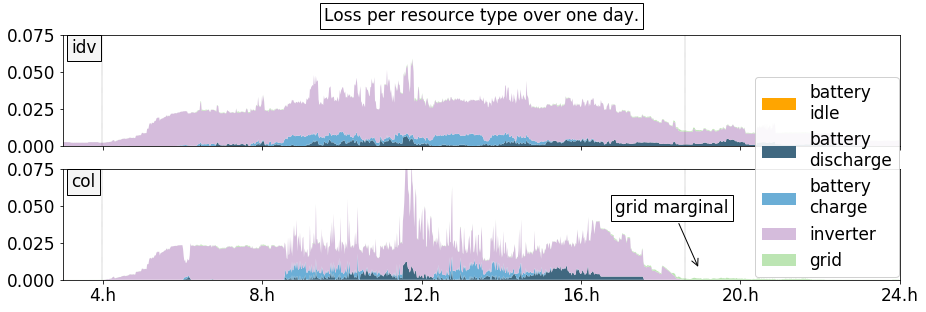

In [137]:
tmp0 = np.arange(1440)
tmp1 = np.vstack([
    to_kWh(pop_idv['E_J_loss_es_idle'][1440*7:1440*8]),
    to_kWh(pop_idv['E_J_loss_es_dch'][1440*7:1440*8]),
    to_kWh(pop_idv['E_J_loss_es_ch'][1440*7:1440*8]),
    to_kWh(pop_idv['E_J_loss_inv'][1440*7:1440*8]),
    to_kWh(pop_idv['E_J_loss_grid'][1440*7:1440*8]),
                 ])*-1
tmp2 = np.vstack([
    to_kWh(pop_col['E_J_loss_es_idle'][1440*7:1440*8]),
    to_kWh(pop_col['E_J_loss_es_dch'][1440*7:1440*8]),
    to_kWh(pop_col['E_J_loss_es_ch'][1440*7:1440*8]),
    to_kWh(pop_col['E_J_loss_inv'][1440*7:1440*8]),
    to_kWh(pop_col['E_J_loss_grid'][1440*7:1440*8]),
                 ])*-1

fig, axs = plt.subplots(2,1, figsize=(15,3*1.5), sharey=True, sharex=True)#LATER ticks per day;
colors = ['orange', mcolor['es']*0.6, mcolor['es']*1, mcolor['inv'], mcolor['grid']]
axs[0].stackplot(tmp0, tmp1, colors=colors)
axs[1].stackplot(tmp0, tmp2, colors=colors)
fig.legend(['battery\nidle', 'battery\ndischarge', 'battery\ncharge', 'inverter', 'grid'], bbox_to_anchor=(1.009,0.7), bbox_transform=axs[0].transAxes, frameon=True, framealpha=0.9)
for ax in axs:
    ax.axvline(x=sun_up, linestyle='--', linewidth=0.2, color='k') # horizontal lines
    ax.axvline(x=sun_down, linestyle='--', linewidth=0.2, color='k') # horizontal lines
    ax.set_xlim(60*3, 1440)
    ax.set_ylim(0,0.075)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
ax.set_xticks([x for x in range(4*60,1440+1,60*4)])
ax.set_xticklabels( [*(f'{i}.h' for i in range(4,24+1,4))])
axs[0].set_title('Loss per resource type over one day.', y=1, pad=+10, va="bottom",ha='center', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[0].text(0.01,0.8,'idv', va='bottom', ha='left', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[1].text(0.01,0.8,'col', va='bottom', ha='left', transform=axs[1].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
xy = np.array([0.76,0.1])
axs[1].annotate('grid marginal', xy, xytext=xy+[-0.1, 0.5], size=17, xycoords='axes fraction', bbox={'facecolor':'white'}, arrowprops={'arrowstyle':'->'})
plt.show()

In [138]:
tmp1.sum(), tmp2.sum()

(26.834616544284085, 19.396989229847865)

In [139]:
# maxs Loss day on individual control and collective control below 
# inv flow during sun updown, longer if soc left; inv flow idv earlier probably some have soc; inv <400 happend?, overall less area, 
# grid almost none
# mostly charge late noon dch (short since lanes earlier)
# pv profile slight early 5:30


    Inverter loss zoomed in:

In [140]:
tmp01 = np.absolute(pop_idv['P_j0toJ_inv_set_normed'][1:,:1440*4*7].flatten()*100)
tmp02 = pop_idv['P_j0toJ_inv_loss'][1:,:1440*4*7].flatten()*-1
tmp1 = tmp01[tmp01!=0]
tmp2 = tmp02[tmp01!=0]#power 0 set is 0 loss
values, bins = np.histogram(tmp1, bins=400)
# calculate loss for each bin
stat, e, nr = stats.binned_statistic(tmp1, tmp2, statistic='sum', bins=bins)
cumulative = np.cumsum(stat/np.sum(stat))#cumulate normed loss to [0;1]

tmp01_col = np.absolute(pop_col['P_j0toJ_inv_set_normed'][1:,:1440*4*7].flatten()*100)
tmp02_col = pop_col['P_j0toJ_inv_loss'][1:,:1440*4*7].flatten()*-1
tmp1_col = tmp01_col[tmp01_col!=0]
tmp2_col = tmp02_col[tmp01_col!=0]#power 0 set is 0 loss
values_col, bins_col = np.histogram(tmp1_col, bins=400)
# calculate loss for each bin
stat_col, e_col, nr_col = stats.binned_statistic(tmp1_col, tmp2_col, statistic='sum', bins=bins_col)
cumulative_col = np.cumsum(stat_col/np.sum(stat))#cumulate normed loss to [0;1] of IDV!

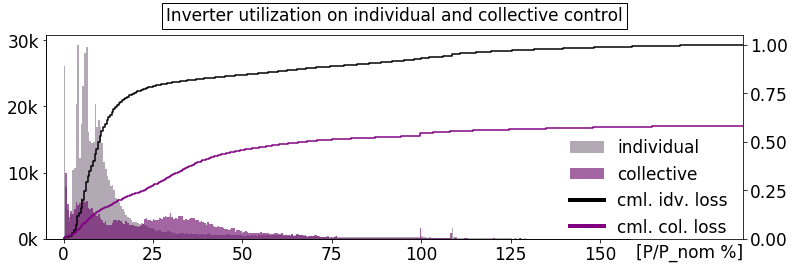

In [141]:
fig, ax = plt.subplots(1,1, figsize=(15/1.2,1.5*2.5))
ax.hist(tmp1, bins=bins, color=[*mcolor['inv'][:3]*0.6, 0.6])
ax.hist(tmp1_col[1:], bins=bins_col[1:], color=[*np.array((0.5019607843137255, 0.0, 0.5019607843137255))*0.8, 0.6])#remove first bin 1e-20 for scale
ax.set_xlim(-5,190)
axt = ax.twinx()
axt.plot(bins[:-1], cumulative, c='k', ls='-', lw=1.5, drawstyle='steps-post')
axt.plot(bins_col[:-1], cumulative_col, c='purple', ls='-', lw=1.5, drawstyle='steps-post')
axt.set_ylim([ax.get_ylim()[0],axt.get_ylim()[1]])
# ax.set_xticklabels( [*(f'{i/100:.2f}' for i in range(0,201,25))])
axt.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.set_yticklabels(('0k','10k', '20k', '30k'))
leg = fig.legend(('individual', 'collective', 'cml. idv. loss', 'cml. col. loss'), bbox_to_anchor=(1,0.565), bbox_transform=ax.transAxes, frameon=False)
plt.setp(leg.get_lines(), linewidth=4)
axs[0].text(0.5,0.91,'day of maximum loss', va='bottom', ha='center', transform=fig.transFigure, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
xy = np.array([0.76,0.1])
ax.text(0.5,1.05,'Inverter utilization on individual and collective control', va='bottom', ha='center', transform=ax.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
ax.text(1.0,-0.11,'[P/P_nom %]', va='bottom', ha='right', transform=ax.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':5})
plt.show()

In [142]:
# histogram for normed power flow [%] of inverter and associated loss
# bin 1e-20excluded alias 0 power on histo

#now ASM3 test talk: mostly below nom 3500-5000kW
print(f'inverter mostly operated low eff pctl.',[90,97,100], np.percentile(tmp1, q=[90,97,100]))
tmp3 = to_kWh(tmp02[tmp01/100*3500<100].sum() * Resource.kclock)
tmp4 = to_kWh(tmp02.sum() * Resource.kclock)#total inv loss
print(f'loss under 100W accounts for {tmp3:.3f}kWh, {tmp3/tmp4*100:.3f}% of total {tmp4:.3f}kWh')
print('inverter mostly operated low eff pctl.',[90,97,100], np.percentile(tmp1_col, q=[90,92,100]))
tmp3_col = to_kWh(tmp02_col[tmp01_col/100*3500<100].sum() * Resource.kclock)
tmp4_col = to_kWh(tmp02_col.sum() * Resource.kclock)#total inv loss
print(f'loss under 100W accounts for {tmp3_col:.3f}kWh, {tmp3_col/tmp4_col*100:.3f}% of total {tmp4_col:.3f}kWh')

inverter mostly operated low eff pctl. [90, 97, 100] [ 41.04291234  84.18108867 192.07376552]
loss under 100W accounts for 20.652kWh, 2.886% of total 715.533kWh
inverter mostly operated low eff pctl. [90, 97, 100] [ 52.10347857  56.56587429 191.4314    ]
loss under 100W accounts for 17.697kWh, 4.241% of total 417.227kWh


##### About summarized loss and its cost

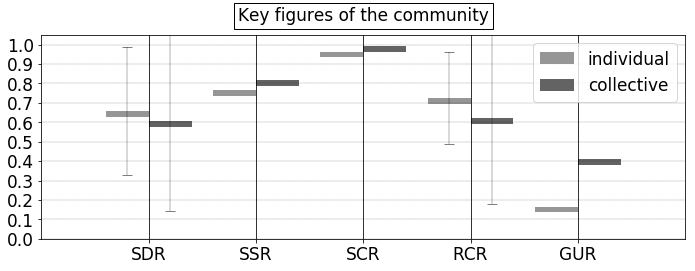

In [143]:
layer0 = np.zeros( (10) )
layer0[0] = pop_idv['SDR_k0toK'].mean()# 1 energy conservation?, use pv/ld actrually no?
layer0[1] = pop_col['SDR_k0toK'].mean()
layer0[2] = pop_idv['SSR']
layer0[3] = pop_col['SSR']
layer0[4] = pop_idv['SCR']
layer0[5] = pop_col['SCR']
layer0[6] = pop_idv['RCR']
layer0[7] = pop_col['RCR']
layer0[8] = pop_idv['GUR']
layer0[9] = pop_col['GUR']
stds = [pop_idv['SDR_k0toK'].std(), pop_col['SDR_k0toK'].std(),\
            pop_idv['RCR_k0toK'].std(), pop_col['RCR_k0toK'].std()]#np.mean so std also

fig, ax = plt.subplots(1,1, figsize=(15/1.3,1.5*2.5),)# sharey=True)
ind = np.arange(10, dtype=np.float64)*1#cordx
height=0.03
width=0.8
ax.bar(ind[0::2]-width/2, height, width=width, bottom=layer0[0::2]-height, color=mcolor['idv'])
ax.bar(ind[0::2]+width/2, height, width=width, bottom=layer0[1::2]-height, color=mcolor['col'])
xerr = np.hstack((ind[0:2], ind[6:8]))
xerr[0::2] -= width/2
xerr[1::2] -= width/2+0.2
ax.errorbar(xerr, [*layer0[0:2], *layer0[6:8]], yerr=stds, ls='none', capsize=5,mew=0.5, c='k', elinewidth=0.3)
# ax.errorbar([*ind[0:2], *ind[6:8]], [*layer0[0:2], *layer0[6:8]], yerr=stds, ls='none', capsize=5,mew=1, c='k', elinewidth=0.5)
ax.set_ylim(-0.,1.05) 
ax.set_xlim(-2,10) 
ax.set_yticks(np.arange(0, 1.1, step=0.1))
ax.set_xticks(ind[0::2])
ax.set_xticklabels( ('SDR', 'SSR', 'SCR', 'RCR', 'GUR') )
fig.legend(('individual', 'collective'), bbox_to_anchor=(1.0,1), bbox_transform=ax.transAxes, frameon=True, markerscale=0.8)#, labelspacing=1.5,)
plt.grid(color='black', which='major', axis='y', linestyle='--', lw=0.2)
plt.grid(color='black', which='major', axis='x', linestyle='-', lw=0.8)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.set_title('Key figures of the community', y=1, pad=+10, va="bottom",ha='center', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
plt.show()

In [144]:
layer0[0::2],layer0[1::2]

(array([0.65818662, 0.76712459, 0.96395987, 0.72340092, 0.16621119]),
 array([0.60771886, 0.81678108, 0.99473465, 0.62370809, 0.41070196]))

In [145]:
# SDR and RCR due to high std meaningless
#     see RCR on xfmr
# no j0, slight higher SSR
# SCR valid compared to idv bars, increases in col
# GUR goes up >2*


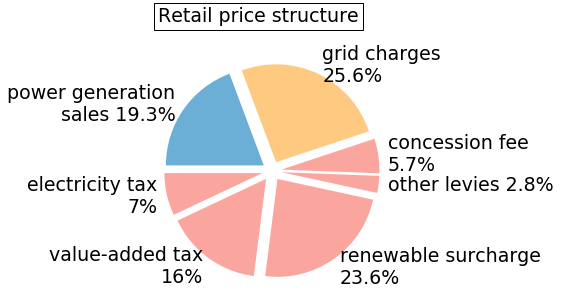

In [146]:
sizes_idv = np.array([7,16,23.6,2.8,5.7,25.6,19.3])

fig, axs = plt.subplots(1,1, figsize=(15,3*1.5))
axs = [axs] 
cols = [mcolor['ld'], mcolor['ld'], mcolor['ld'], mcolor['ld'], mcolor['ld'], mcolor['pv'], mcolor['es'], mcolor['xfmr']]
labels1 = 'electricity tax\n7%', 'value-added tax\n16%', 'renewable surcharge\n23.6%', 'other levies 2.8%', 'concession fee\n5.7%', 'grid charges\n25.6%', 'power generation\nsales 19.3%'
# labels1 = 'load 44.7%', 'pv 36.48%', 'xfmr 13.52%', 'es 0.05%', 'loss 5.23%'#idv style it
# labels2 = 'load 46.39%', 'pv 37.84%', 'xfmr 12.16%', 'es 0.00%', 'loss 3.61%'#col
# labels1 = 'load 89.4%', 'pv 72.96%', 'xfmr 27.04%', 'es 0.10%', 'loss 10.5%'#idv style it
explode = [0.1, 0.1,0.1,0.1,0.1, 0.1, 0.1]#explode loss
patches, texts = axs[0].pie(sizes_idv, labels=labels1, explode=explode, colors=cols,  startangle=180, pctdistance=0.8, labeldistance=1.1) #  autopct='%1.2f%%',
for text in texts:
    text.set_fontsize(19)
# axs[0].axis('equal')
# axs[0].text(0.1,0.9,'idv', va='bottom', ha='center', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
fig.text(0.5,0.95,'Retail price structure', va='bottom', ha='center', transform=fig.transFigure, color='k', fontsize=19, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
plt.show()

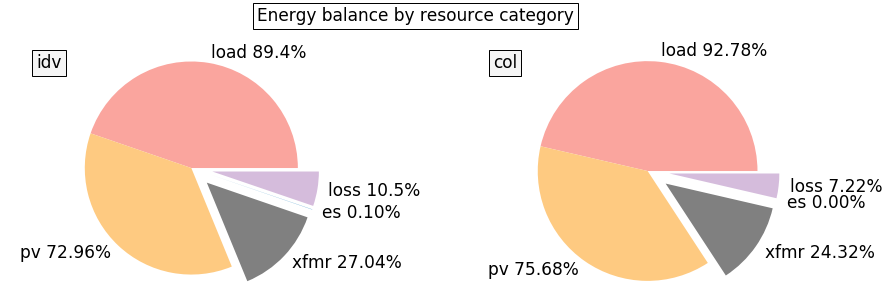

In [147]:
sizes_idv = np.absolute(np.array([pop_idv['P_J_ld'].sum(), 
                      pop_idv['P_J_pv'].sum(),
                      pop_idv['P_xfmr'].sum(),
                      pop_idv['E_j0toJ_es_soc'][:,-1].sum() / Resource.kclock,#actually one step after;  pop_idv['P_j0toJ_es_ext'].sum(),
                      (pop_idv['E_J_loss_inv'].sum() + pop_idv['E_J_loss_grid'].sum() + pop_idv['E_J_loss_es_total'].sum()) / Resource.kclock
                     ]))
sizes_col = np.absolute(np.array([pop_col['P_J_ld'].sum(), 
                      pop_col['P_J_pv'].sum(),
                      pop_col['P_xfmr'].sum(),
                      pop_col['E_j0toJ_es_soc'][:,-1].sum() / Resource.kclock,#pop_col['P_j0toJ_es_ext'].sum(),
                      (pop_col['E_J_loss_inv'].sum() + pop_col['E_J_loss_grid'].sum() + pop_col['E_J_loss_es_total'].sum()) / Resource.kclock
                     ]))
sizes_idv = to_kWh(sizes_idv * Resource.kclock)
sizes_col = to_kWh(sizes_col * Resource.kclock)

fig, axs = plt.subplots(1,2, figsize=(15,3*1.5))
cols = [mcolor['ld'], mcolor['pv'], mcolor['xfmr'], mcolor['es'], mcolor['inv']]
labels = 'load', 'pv', 'xfmr', 'es', 'loss'
# labels1 = 'load 44.7%', 'pv 36.48%', 'xfmr 13.52%', 'es 0.05%', 'loss 5.23%'#idv style it
# labels2 = 'load 46.39%', 'pv 37.84%', 'xfmr 12.16%', 'es 0.00%', 'loss 3.61%'#col
labels1 = 'load 89.4%', 'pv 72.96%', 'xfmr 27.04%', 'es 0.10%', 'loss 10.5%'#idv style it
labels2 = 'load 92.78%', 'pv 75.68%', 'xfmr 24.32%', 'es 0.00%', 'loss 7.22%'#col
explode = [0, 0, 0.2, 0.2, 0.2]#explode loss
axs[0].pie(sizes_idv, explode=explode, labels=labels1, colors=cols,  startangle=0, pctdistance=0.8, labeldistance=1.1) #  autopct='%1.2f%%',
axs[0].axis('equal')
axs[1].pie(sizes_col, explode=explode, labels=labels2, colors=cols, startangle=0, pctdistance=0.8, labeldistance=1.1)
axs[1].axis('equal')
axs[0].text(0.1,0.9,'idv', va='bottom', ha='center', transform=axs[0].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs[1].text(0.1,0.9,'col', va='bottom', ha='center', transform=axs[1].transAxes, color='k', fontsize=17, bbox={'facecolor':'whitesmoke', 'edgecolor':'k', 'alpha':1, 'pad':4})
fig.text(0.5,0.95,'Energy balance by resource category', va='bottom', ha='center', transform=fig.transFigure, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
plt.show()

In [148]:
to_kWh(pop_idv['E_j0toJ_es_soc'][:,-1].sum()), to_kWh(pop_col['E_j0toJ_es_soc'][:,-1].sum())#es soc neglectible at end

(-7.958412320676168, -0.00019014775014064474)

In [149]:
to_kWh(60*np.array([pop_idv['P_J_ld'].sum(),  pop_idv['P_J_pv'].sum(), pop_idv['P_xfmr'].sum(),pop_col['P_J_ld'].sum(),  pop_col['P_J_pv'].sum(), pop_col['P_xfmr'].sum()]))

array([-7349.31488191,  5995.56171107,  2221.20588374, -7349.31488191,
        5995.56171107,  1926.34233572])

In [150]:
# energy by resource idv v col [kWh]
# 50:50 prod:cons halfs, xfmr less inflow since pv output const
# less loss is less xfmr inflow, in sum 18 to 15%; 
# xfmr/pv increased is greater SSR



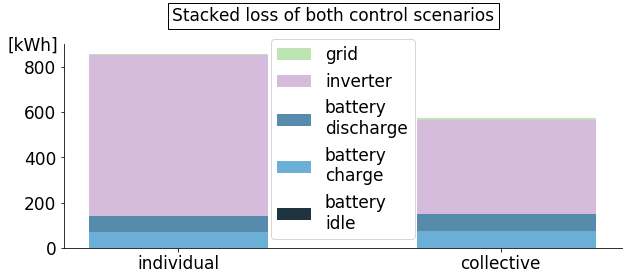

In [151]:
layer00 = to_kWh(np.array([pop_idv['E_J_loss_es_idle'], pop_col['E_J_loss_es_idle']]).sum(axis=1)*-1)
layer01 = to_kWh(np.array([pop_idv['E_J_loss_es_ch'], pop_col['E_J_loss_es_ch']]).sum(axis=1)*-1)
layer02 = to_kWh(np.array([pop_idv['E_J_loss_es_dch'], pop_col['E_J_loss_es_dch']]).sum(axis=1)*-1)
layer1 = to_kWh(np.array([pop_idv['E_J_loss_inv'], pop_col['E_J_loss_inv']]).sum(axis=1)*-1)
layer2 = to_kWh(np.array([pop_idv['E_J_loss_grid'], pop_col['E_J_loss_grid']]).sum(axis=1)*-1)

ind = np.arange(2)*0.55
fig, axs = plt.subplots(1,1, figsize=(10,1.5*2.5))
axs.bar(ind, layer2, width=0.3, bottom=layer00 + layer01 + layer02 + layer1, color=mcolor['grid'])
axs.bar(ind, layer1 , width=0.3, bottom=layer00 + layer01 + layer02 , color=mcolor['inv'])
axs.bar(ind, layer02, width=0.3, bottom=layer00 + layer01, color=mcolor['es']*0.8)
axs.bar(ind, layer01, width=0.3, bottom= layer00, color=mcolor['es'])
axs.bar(ind, layer00, width=0.3, color=mcolor['es']*0.3)
axs.set_xticks([0,0.54])
axs.set_xticklabels(('individual', 'collective'))
axs.legend(('grid', 'inverter', 'battery\ndischarge', 'battery\ncharge', 'battery\nidle'), frameon=True)
fig.text(0.5,0.95,'Stacked loss of both control scenarios', va='bottom', ha='center', transform=fig.transFigure, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'k', 'alpha':1, 'pad':4})
axs.text(-0.01,0.95,'[kWh]', va='bottom', ha='right', transform=axs.transAxes, color='k', fontsize=17, bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':1, 'pad':0})
plt.show()

In [152]:
# to above: inverter dim is critical to least loss: too big on 'low median profile but spikey:std high on wide range is bad, 
# es are linear and amount in/out almost the same in total, mention all totals, also from 'about batteries'
# also talk relations: of loss kinds

In [153]:
tmp0 = pop_idv['E_J_loss_inv'].sum()*-1
tmp2 = pop_col['E_J_loss_inv'].sum()*-1
tmp3 = tmp2 / tmp0
print(f'inv loss col/idv {tmp3*100:.2f}% of idv={to_kWh(tmp0):.2f}kWh to col={to_kWh(tmp2):.2f}kWh reducing {to_kWh(tmp0-tmp2):.2f}kWh')

inv loss col/idv 58.31% of idv=715.53kWh to col=417.23kWh reducing 298.31kWh


In [154]:
tmp0 = np.array([pop_idv['E_J_loss_es_ch'].sum(),pop_idv['E_J_loss_es_dch'].sum(),pop_idv['E_J_loss_es_idle'].sum()])#almost no idle in idv
tmp1 = np.array([pop_col['E_J_loss_es_ch'].sum(),pop_col['E_J_loss_es_dch'].sum(),pop_col['E_J_loss_es_idle'].sum()])
tmp2 = tmp1 / tmp0
for a,b,c,d in zip(['ch','dch','idle'],tmp0, tmp1, tmp2):
    print(f'es loss col/idv {a}={d*100:.2f}% of idv={to_kWh(b):.2f} col={to_kWh(c):.2f}kWh')

es loss col/idv ch=105.87% of idv=-70.84 col=-74.99kWh
es loss col/idv dch=106.40% of idv=-68.69 col=-73.08kWh
es loss col/idv idle=595845.06% of idv=-0.00 col=-0.02kWh


In [155]:
# about loss
#     remention earlier:
#         es: slight more util; 
            # dch/charged below 100W is 38.53kWh which is 0.71% of total 5434.95kWh of which ch:-2791.20 dch:2643.74kWh
            # dch/charged below 100W is 8.98kWh which is 0.16% of total 5773.55kWh of which ch:-2960.82 dch:2812.73kWh
#             idle: idv almost none since profile base load, while col fed by other yet no pv and eventually soc
                
    # about grid COPYED
    # idv loss is 4.46kWh of fed-in 2221.21kWh which is 0.20% in on 28ct/kWh 1.25 Eur cost
    # col loss is 7.26kWh of fed-in 1926.34kWh which is 0.38% in on 28ct/kWh 2.03 Eur cost



In [156]:
# loss cost estimate denoted in conv price
c_cons = c_cons_[0]
c_prod = c_prod_[0]
tmp0 = (pop_idv['E_J_loss_es_total'] + pop_idv['E_J_loss_inv'] + pop_idv['E_J_loss_grid']).sum()
tmp1 = to_kWh(tmp0) * c_cons
tmp2 = pop_idv['tbl_C_meta'].loc['now','hh_total']
print(f'conv: idv loss {tmp1:.2f}Eur, which is {tmp1/tmp2 *100:.2f}% of total {tmp2:.2f}Eur; {tmp2/20:.2f} Eur payed by hh/month') 
print(to_kWh(tmp0))
tmp0 = (pop_col['E_J_loss_es_total'] + pop_col['E_J_loss_inv'] + pop_col['E_J_loss_grid']).sum()
tmp1 = to_kWh(tmp0) * c_cons
tmp2 = pop_idv['tbl_C_meta'].loc['now','hh_total']
print(f'conv: col loss {tmp1:.2f}Eur, which is {tmp1/tmp2 *100:.2f}% of total {tmp2:.2f}Eur; {tmp2/20:.2f} Eur payed by hh/month')
print(to_kWh(tmp0)) 

conv: idv loss 240.66Eur, which is 34.25% of total 702.58Eur; 35.13 Eur payed by hh/month
-859.5157692617229
conv: col loss 160.32Eur, which is 22.82% of total 702.58Eur; 35.13 Eur payed by hh/month
-572.5889747278841


In [157]:
# TOTALS reduced ^ to wrap up on pos. note, ??so much payed
# col on conv price to compare
# included grid here since ends up at hhs and <2 eur
# also reprint conv/mmr two row table
# stop

In [158]:
to_kWh(25*28*24*60*60), to_kWh(4*28*24*60*60) , to_kWh(4*28*24*60*60) /(4199.608504/12) *100 #[%]

(16.8, 2.6879999999999997, 0.7680715945135631)

### Appendix <a name="aeZae4ai"></a>

    example of  lookuperr inv eff by out better than by P to load, causing slight short, 
        despite P increasing on left of extrema n(P); all good 

    P_j_res = P_j_ch_pv_xr + P_j_ld
    
    ipdb> P_j_res , P_j_ch_pv_xr , P_j_ld
    (-0.04277047244461585, 94.94958515755539, -94.99235563)
    ipdb> P_j_ld_xl_pv , rs_es.P_ch_max
    (1010.8979028488804, -1010.8874664761353)
    ipdb> rs_es.E_soc
    -298330.5264919554
    ipdb> rs_es.E_soc / rs_es.E_soc_max
    0.8346123813588421
    ipdb> (1010*60 + rs_es.E_soc )/ rs_es.E_soc_max
    0.6650772321902917
    ipdb> (-1010*60 + rs_es.E_soc )/ rs_es.E_soc_max
    1.0041475305273926
    ipdb> rs_inv.set_P(k, P_j_ch_pv).get_eff(k)
        0.6216560175023202     <<< EXACT
    ipdb> rs_inv.set_P_by_out(k, P_j_ld_xl).get_eff(k)
    0.7292805907752541
    ipdb> rs_inv.set_P_by_out(k, abs(P_j_ld)).get_eff(k)
        0.6219785446098767    <<< HAS ERROR
    ipdb> P_j_ch_pv
    152.73653352386475
    ipdb> P_j_ld / rs_inv.set_P_by_out(k, abs(P_j_ld)).get_eff(k)
    -152.7260971511196 

#### Notebook version: Platform information used for this notebook <a name="aeeae4ai"></a>
    

In [159]:
from IPython.utils.sysinfo import get_sys_info
get_sys_info()

{'ipython_version': '7.4.0',
 'ipython_path': '/home/user/anaconda3/lib/python3.7/site-packages/IPython',
 'commit_source': 'installation',
 'commit_hash': 'd774f565b',
 'sys_version': '3.7.3 (default, Mar 27 2019, 22:11:17) \n[GCC 7.3.0]',
 'sys_executable': '/home/user/anaconda3/bin/python',
 'sys_platform': 'linux',
 'platform': 'Linux-4.9.0-9-amd64-x86_64-with-debian-9.9',
 'os_name': 'posix',
 'default_encoding': 'UTF-8'}

#### License notice <a name="aefae4ai"></a>

    MIT License

    Copyright (c) 2019
        -----BEGIN PUBLIC KEY-----
        MIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAtAgeP1hhQHBHPICTc2ho
        vJFNXA2qtf0HjuXXV7i+imaN7RI4hUPQMo4nNCYjeiD3vzAdBTtWRQrI2ONmiFTk
        ntAuD0Mg03q+mj/88aawnZbtXBF4QM5sYClInIuW23uhSq17SseWCXtEhmHtz155
        4LllN4FBC11/R0shrAvFH4dAn2sM8PBg+FGze2wUaJbEl2rLe+qoek10krbSrpUP
        VXCsyVyicR1IaOhldH4I8zpvB6CSPzOkzhQhbxRhxvKwN7kaVlzVGg2u3ccgffHP
        dldIk2D14rz0hJ0Ix1qheAQW/+2haBP/lbwW2iLtiyC47sVeDbCpd66Zi9lKDUe4
        nwIDAQAB
        -----END PUBLIC KEY-----

    Permission is hereby granted, free of charge, to any person obtaining a copy
    of this software and associated documentation files (the "Software"), to deal
    in the Software without restriction, including without limitation the rights
    to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
    copies of the Software, and to permit persons to whom the Software is
    furnished to do so, subject to the following conditions:

    The above copyright notice and this permission notice shall be included in all
    copies or substantial portions of the Software.

    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
    IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
    FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
    AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
    LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
    OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
    SOFTWARE.

    https://tldrlegal.com/license/mit-license